In [1]:
source('/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/scripts/R_functions/cdr3-QTL_functions.R')
source('/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/scripts/libraries_analysis.R')
source('/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/scripts/libraries_visuals.R')
library(data.table)
library(dplyr)
library(ggbump)
library(robCompositions)
library(ggpubr)
library(WGCNA)
library(effsize)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘tidyr’


The following object is masked from ‘package:magrittr’:

    extract


Loading required package: ggplot2

Loading required package: lattice


Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths


The following objects are masked from ‘package:data.table’:

    dcast, melt



---------------------
Welcome to dendextend version 1.17.1
Type citation('dendextend') for how to cite the package.

Type browseVignettes(package = 'dendextend') for the package vignette.
The github page is: https://github.com/talgalili/dendextend/

Suggestions and bug-reports can be submitted at: https://github.com/talgalili/dendextend/issues
You may ask qu

### Visualisation of CDR3 repertoires

In [40]:
cdr3_summary <- fread('/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/data/summary_cdr3_dt.tsv')

In [41]:
phenotypes <- fread("/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/data/phenotypes.tsv")
cdr3_summary <- merge(cdr3_summary, phenotypes, by = 'patient_id')


In [42]:
head(cdr3_summary)

patient_id total_number_of_seq productive_CDR3 n_unique group
1 H0         263782              215515          205070   HLH  
2 H1         363217              302480          282918   HLH  
3 H10        210889              171305          163451   HLH  
4 H100       250933              205133          195459   HLH  
5 H101       480405              393953          367668   HLH  
6 H102       342888              285480          267043   HLH

In [310]:
res.aov <- aov(total_number_of_seq ~ group, data = cdr3_summary)
summary(res.aov)  # ANOVA table
TukeyHSD(res.aov)

              Df    Sum Sq   Mean Sq F value   Pr(>F)    
group          2 4.799e+11 2.399e+11   14.86 3.93e-07 ***
Residuals   1970 3.181e+13 1.615e+10                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = total_number_of_seq ~ group, data = cdr3_summary)

$group
             diff       lwr      upr     p adj
HLH-CD 31079.4335  16444.18 45714.68 0.0000021
UC-CD  31922.3669  12164.85 51679.88 0.0004562
UC-HLH   842.9334 -19313.52 20999.38 0.9947098


In [43]:
cdr3_summary %>% dplyr::select(-patient_id) %>% 
    group_by(group) %>% 
    summarise(mean_repertoire = mean(total_number_of_seq), 
        mean_prod = mean(productive_CDR3),
        mean_unique = mean(n_unique)) %>%
    mutate(proportion_prod = mean_prod / mean_repertoire,
           proportion_unique = mean_unique / mean_repertoire)

group mean_repertoire mean_prod mean_unique proportion_prod proportion_unique
1 CD    208066.2        172275.4  163096.9    0.8279833       0.7838700        
2 HLH   239145.7        197475.1  186955.6    0.8257525       0.7817644        
3 UC    239988.6        198054.8  186730.9    0.8252675       0.7780823

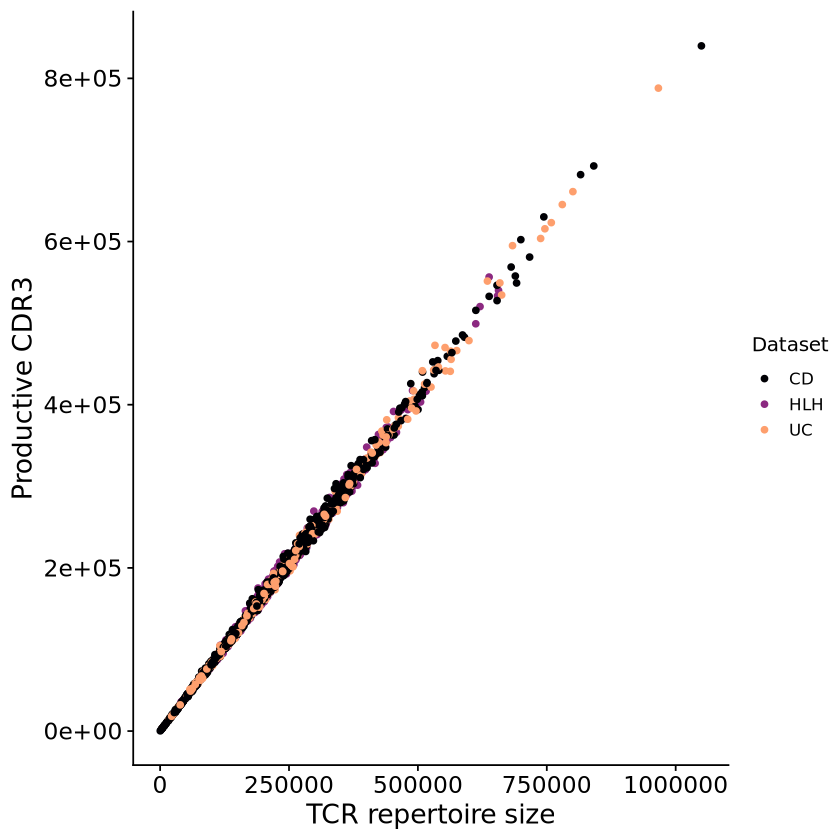

In [288]:
ggplot(cdr3_summary, aes(x = total_number_of_seq, y = productive_CDR3, color = group)) + 
    geom_point() + 
    theme_cowplot() + 
    scale_color_viridis_d(option = "magma", end = 0.8) + 
    labs(x = 'TCR repertoire size', y = 'Productive CDR3', color = 'Dataset') +
    theme(legend.title = element_text(size = 12),
          legend.text = element_text(size = 10),
          axis.title = element_text(size = 16),
          axis.text = element_text(size = 14)) +
ggsave("/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/plots/repertoire_size_vs_productive_cdr3.pdf", width = 6, height = 6, dpi = 600)

In [335]:
table(cdr3_summary$group)
896 + 305


 CD HLH  UC 
896 772 305 

[1] 1201

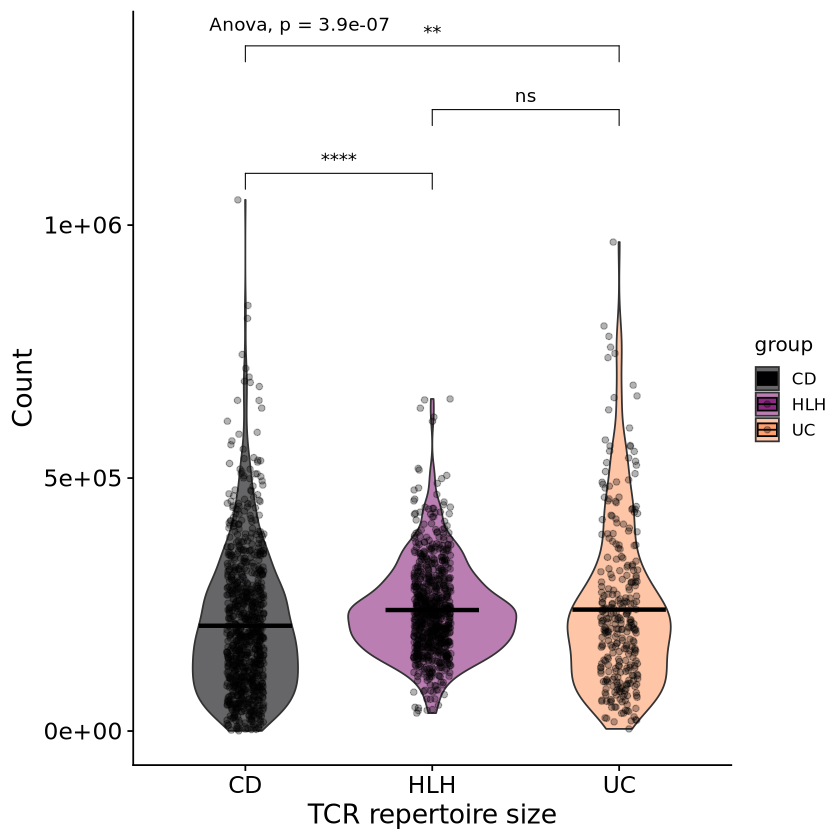

In [44]:
pl <- ggplot(cdr3_summary, aes(x = group, y = total_number_of_seq, fill = group)) + 
    geom_violin(alpha = 0.6) + 
    stat_summary(fun = mean, #fun.min = mean, fun.max = mean,
               geom = "crossbar", width = 0.5, color = "black") +
    geom_jitter(width = 0.1, alpha = 0.3) +
    theme_cowplot() + 
    scale_fill_viridis_d(option = "magma", end = 0.8) + 
    labs(x = 'TCR repertoire size', y = 'Count', color = 'Dataset') +
    theme(legend.title = element_text(size = 12),
          legend.text = element_text(size = 10),
          axis.title = element_text(size = 16),
          axis.text = element_text(size = 14)) +
    stat_compare_means(method = "anova",vjust = -13) +               # Adds global p-value
    stat_compare_means(method = "t.test", label = "p.signif",
                     comparisons = list(c("CD", "HLH"),
                                        c("HLH", "UC"),
                                        c("CD", "UC")))
pl
#ggsave("/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/plots/violon_repertoire_size_cdr3.pdf", pl, width = 6, height = 6, dpi = 600)

In [45]:
ggsave("/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/plots/violon_repertoire_size_cdr3.png", pl, width = 6, height = 6, dpi = 600)

### Look at differences of CDR3 composition by PERMANOVA null models

In [22]:
permanova_files <- list.files('/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/conditional_analysis/permanova/DRB1/', 
    pattern = "\\.tsv$", 
    full.names = TRUE)
permanova_cond <- rbindlist(lapply(permanova_files, fread))

In [23]:
permanova_cdr3 <- permanova_cond[Site_hla == 'null']

In [ ]:
source('/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/scripts/R_scripts/Comparing_CDR3_distributions_PERMANOVA.r')

In [ ]:
cdr3_freq <- fread('/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/data/cdr3_all_freq_with_IRT.tsv')

### Comparing HLH and HLH_Emerson

In [47]:
head(cdr3_freq_emerson)

patient_id length_seq IMGT AA cum_expansion_freq unique_count
1 P1         13         P104 R  4.631218e-06        6          
2 P1         14         P104 A  1.130017e-04       43          
3 P1         13         P104 Y  1.790738e-05        7          
4 P1         12         P104 R  4.631218e-06        5          
5 P1         13         P104 F  6.174957e-06        5          
6 P1         12         P104 F  5.279588e-05       26          
  total_imgt_count norm_freq_expand norm_freq_unique n_carriers
1 26               0.06048387       0.2307692        571       
2 77               0.39312567       0.5584416        142       
3 26               0.23387097       0.2692308        559       
4 35               0.05535055       0.1428571        456       
5 26               0.08064516       0.1923077        415       
6 35               0.63099631       0.7428571        389       
  n_ind_high_expand_freq irt_freq_unique irt_freq_expand
1 110                    -0.9862856      -1.2677040     
2   0                     2.6948395       2.6948395     
3   0                     1.7176108       1.2754594     
4  37                    -1.5708045      -1.4047766     
5   2                     1.1201482       0.6315043     
6   1                     3.0148936       3.0148936

In [68]:
amino_acids <-c('A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y') 
X_reduced <- "group"
first <- TRUE

cdr3_freq_emerson <- fread('/work_beegfs/sukmb667/projects/cdr3-qtl/Emerson_DeWitt/cdr3_all_irt_with_expansion_excluded_germ_long.tsv')
cdr3_freq_emerson$group <- "HLH_EMERSON"
cdr3_freq_our <- fread('/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/data/cdr3_all_freq_with_IRT.tsv')[group == "HLH"]
cols_to_keep <- c('patient_id', 'group', 'IMGT', 'AA', 'norm_freq_unique', 'length_seq')

In [73]:
cdr3_freq <- rbind(cdr3_freq_our[, ..cols_to_keep], cdr3_freq_emerson[, ..cols_to_keep])

phen <- c('HLH', 'HLH_EMERSON')
imgt_to_discard <- c('P104', 'P105', 'P106', 'P117', 'P118')
cdr3_freq <- cdr3_freq[, n_carriers := .N, by = c('IMGT', 'length_seq', 'AA')]
cdr3_freq <- cdr3_freq[n_carriers >= 300][!(IMGT %in% imgt_to_discard)]
cdr3_freq$length_seq <- paste0('L', cdr3_freq$length_seq)
cdr3_freq$pair <- paste0(cdr3_freq$length_seq, '_', cdr3_freq$IMGT)

phen_dt <- unique(cdr3_freq[, .(patient_id, group)])

cdr3_freq_split_length <- split(cdr3_freq, cdr3_freq$length_seq)
cdr3_freq_split_length_wide <- lapply(cdr3_freq_split_length, function(x){
    l <- unique(x$length_seq)
    z <- split(x, x$IMGT)
    lapply(z, function(y){
        p <- unique(y$IMGT)
        df <- dcast(y, patient_id ~ AA, value.var = 'norm_freq_unique', fill = 0)
        as.data.table(df)[, pair := paste0(l, '_', p)]
    })
})
cdr3_lengths <- names(cdr3_freq_split_length_wide)

dataset_combination <- paste0(phen[1], '_', phen[2])

man_whit_results <- data.table(matrix(nrow = 0, ncol = 5) )
colnames(man_whit_results) <- c('datasets', 'pair', 'AA', 'p_val', 'cliff_delta')


for (l in cdr3_lengths){
    for (dt in cdr3_freq_split_length_wide[[l]]){
        cdr3_hla_matrix <- merge(dt, phen_dt, by = 'patient_id')
        pair <- cdr3_hla_matrix$pair[1]
        aa_in_matrix <- colnames(cdr3_hla_matrix)[colnames(cdr3_hla_matrix) %in% amino_acids]

        Y_matrix <- cdr3_hla_matrix %>% dplyr::select(all_of(aa_in_matrix))
        Y_matrix <- as.data.frame(as.matrix(Y_matrix))
        
        formula_null <- as.formula(str_c('Y_matrix ~', X_reduced))
        permod0 <- adonis2(formula_null, data = cdr3_hla_matrix, parallel = (detectCores() - 2) , method="robust.aitchison", permutations = 9999)

        permanova_dt <- as.data.table(permod0[1,])
        permanova_dt$datasets <- dataset_combination

        aic_permod0 <- AICc_permanova2(permod0)
        permanova_dt$aic <- c(aic_permod0$AICc)
        permanova_dt$variance_explained <- permod0$R2[1]
        permanova_dt$pair <- pair

        if (first){
            permanova_dt_all <- permanova_dt
            first <- FALSE  
        } else {
            permanova_dt_all <- rbind(permanova_dt_all, permanova_dt)
        } 
        if (permanova_dt[[grep('Pr',  names(permanova_dt), value = TRUE)]] < 0.01) {
            for (aa in aa_in_matrix) {
                
                man_whit <- wilcox.test(cdr3_hla_matrix[[aa]] ~ group, data = cdr3_hla_matrix)
                if (man_whit$p.value < 0.05){
                    cliff_delta <- cliff.delta(d = cdr3_hla_matrix[[aa]],
                            f = cdr3_hla_matrix$group)
                    man_whit_results_row <- c(dataset_combination, pair, aa, man_whit$p.value, cliff_delta$estimate )
                    names(man_whit_results_row) <- c('datasets', 'pair', 'AA', 'p_val', 'cliff_delta')

                    man_whit_results_row <- data.table(t(man_whit_results_row))
                    man_whit_results <- rbind(man_whit_results, man_whit_results_row)
                }
            }}

}
}
man_whit_results <- man_whit_results[,c("Length_cdr3", "IMGT") := tstrsplit(pair, "_", keep = c(1,2))]
permanova_dt_all <- permanova_dt_all %>% rename( Pvalue = grep("Pr", colnames(permanova_dt_all), value = TRUE)) %>% arrange(Pvalue)
permanova_dt_all <- permanova_dt_all[, c('Length_cdr3', 'IMGT'):= tstrsplit(pair, '_', keep = c(1,2))]
fwrite(permanova_dt_all, paste0('/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/cdr3_compositions_permanova/',dataset_combination,'.tsv'), sep = '\t')
fwrite(man_whit_results, paste0('/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/cdr3_compositions_permanova/man_whit_results_for_',dataset_combination,'.tsv'), 
    sep = '\t')


Warning message in cliff.delta.default(d = cdr3_hla_matrix[[aa]], f = cdr3_hla_matrix$group):
“The samples are fully disjoint, using approximate Confidence Interval estimation”
Warning message in cliff.delta.default(d = cdr3_hla_matrix[[aa]], f = cdr3_hla_matrix$group):
“The samples are fully disjoint, using approximate Confidence Interval estimation”
Warning message in cliff.delta.default(d = cdr3_hla_matrix[[aa]], f = cdr3_hla_matrix$group):
“The samples are fully disjoint, using approximate Confidence Interval estimation”
Warning message in cliff.delta.default(d = cdr3_hla_matrix[[aa]], f = cdr3_hla_matrix$group):
“The samples are fully disjoint, using approximate Confidence Interval estimation”
Warning message in cliff.delta.default(d = cdr3_hla_matrix[[aa]], f = cdr3_hla_matrix$group):
“The samples are fully disjoint, using approximate Confidence Interval estimation”
Warning message in cliff.delta.default(d = cdr3_hla_matrix[[aa]], f = cdr3_hla_matrix$group):
“The samples are full

In [147]:
head(permanova_dt_all)

Df SumOfSqs  R2         F          Pvalue datasets        aic       
1 1  1044.7332 0.63413194 2480.24604 1e-04  HLH_HLH_EMERSON -1236.9593
2 1   188.0278 0.03818506   56.81220 1e-04  HLH_HLH_EMERSON  1717.0770
3 1   334.7593 0.11363177  183.45317 1e-04  HLH_HLH_EMERSON   863.8882
4 1  1365.8900 0.20211603  362.49385 1e-04  HLH_HLH_EMERSON  1902.9589
5 1   268.3937 0.06213460   94.80531 1e-04  HLH_HLH_EMERSON  1493.2291
6 1  1153.0261 0.78189150 5129.95483 1e-04  HLH_HLH_EMERSON -2137.0421
  variance_explained pair     Length_cdr3 IMGT
1 0.63413194         L12_P107 L12         P107
2 0.03818506         L12_P108 L12         P108
3 0.11363177         L12_P114 L12         P114
4 0.20211603         L12_P115 L12         P115
5 0.06213460         L12_P116 L12         P116
6 0.78189150         L13_P107 L13         P107

In [ ]:
man_whit_results_all <- man_whit_results
man_whit_results_all <- man_whit_results_all[,
    p_val := as.numeric(p_val)][,
    cliff_delta := as.numeric(cliff_delta)]
man_whit_results_plot <- man_whit_results_all %>% filter(p_val <= 0.001) %>% 
    filter(abs(cliff_delta) >= 0.2) %>% 
    group_by(IMGT,AA) %>% filter(p_val == min(p_val))

datasets        pair     AA p_val         cliff_delta Length_cdr3 IMGT
1 HLH_HLH_EMERSON L12_P107 A  5.311594e-227 0.9844638   L12         P107
2 HLH_HLH_EMERSON L12_P107 C   5.301882e-65 0.5210860   L12         P107
3 HLH_HLH_EMERSON L12_P107 D  5.928302e-170 0.8505013   L12         P107
4 HLH_HLH_EMERSON L12_P107 E  3.032683e-198 0.9193736   L12         P107
5 HLH_HLH_EMERSON L12_P107 F  3.156120e-150 0.7989837   L12         P107
6 HLH_HLH_EMERSON L12_P107 G  1.900554e-231 0.9941484   L12         P107

In [149]:
aa_order <- c("A", "V", "L", "I", "M", "F", "W", "P", "G", "C", "S", "T", "Y", "H", "K", "R", "D", "E", "N", "Q")

### Visualise differences for all IMGT positions

#### HLH vs HLH_EMERSON

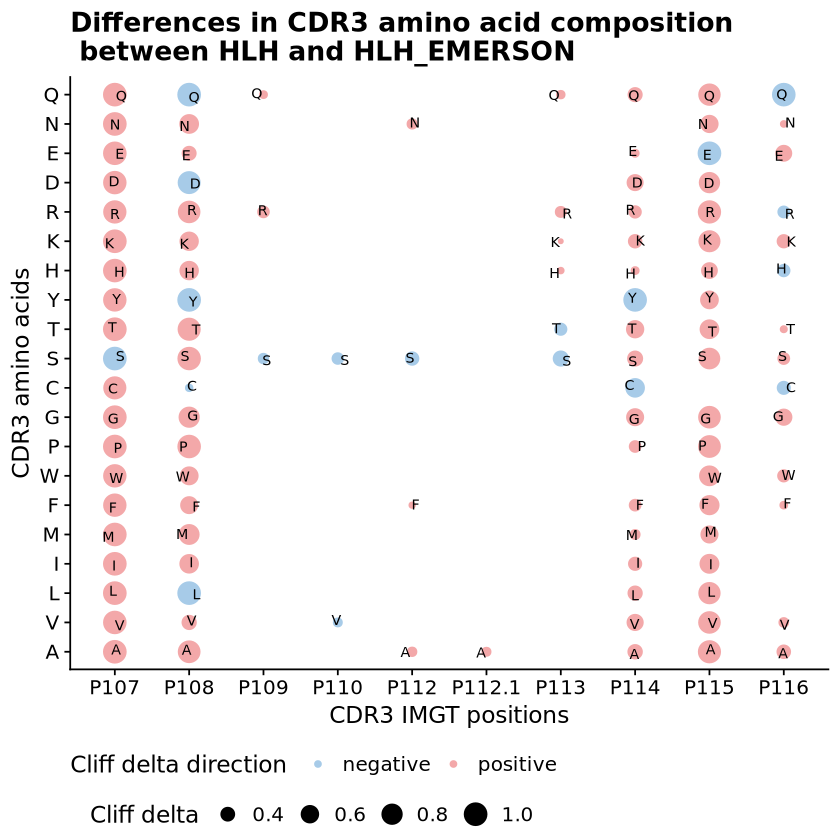

In [185]:
ggplot(man_whit_results_plot,aes(x = IMGT, y = factor(AA, levels = aa_order))) + 
    geom_point(aes(color = ifelse(cliff_delta > 0, 'positive', 'negative'), 
        size = abs(cliff_delta))) +
    scale_color_manual(values = c('positive' = '#f3a8a9', 'negative' = '#a7cbe8')) +
    theme_cowplot() + 
    geom_text(aes(label = AA), size = 3, color = 'black', 
        position = position_jitter(width = 0.1, height = 0.1)) +
    #facet_wrap(~Length_cdr3, nrow = 1) +
    labs(y = 'CDR3 amino acids', x = 'CDR3 IMGT positions', color = 'Cliff delta direction', size = 'Cliff delta',
        title = 'Differences in CDR3 amino acid composition \n between HLH and HLH_EMERSON') +
    theme(legend.position = 'bottom',
        legend.box = 'vertical') + 
    ggsave('/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/plots/cdr3_composition_differences_HLH_vs_HLH_EMERSON.pdf', width = 6, height = 6, dpi = 600) +
    ggsave('/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/plots/cdr3_composition_differences_HLH_vs_HLH_EMERSON.png', width = 6, height = 6, dpi = 600)

#### UC vd CD

In [202]:
man_whit_results_all %>% filter(p_val <= 0.01) %>% 
    filter(abs(cliff_delta) >= 0.1)

datasets pair     AA p_val        cliff_delta Length_cdr3 IMGT
1 CD_UC    L12_P115 A  0.0094560751 -0.1009943  L12         P115
2 CD_UC    L12_P115 K  0.0064947967  0.1059205  L12         P115
3 CD_UC    L15_P113 K  0.0005781747  0.1339381  L15         P113
4 CD_UC    L15_P113 R  0.0025738116  0.1173162  L15         P113
5 CD_UC    L18_P111 D  0.0074743647  0.1041008  L18         P111
6 CD_UC    L18_P111 K  0.0001209312  0.1496047  L18         P111

In [209]:
phen <- c('UC', 'CD')
man_whit_results_all <- fread(paste0('/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/cdr3_compositions_permanova/man_whit_results_for_',phen[2],'_',phen[1],'.tsv'))[,
    p_val := as.numeric(p_val)][,
    cliff_delta := as.numeric(cliff_delta)][,
    c('Length_cdr3', 'IMGT') := tstrsplit(pair, "_", keep = c(1,2))]
man_whit_results_plot <- man_whit_results_all %>% filter(p_val <= 0.01) %>% 
    filter(abs(cliff_delta) >= 0.1) %>% 
    group_by(IMGT,AA) %>% filter(p_val == min(p_val))

In [210]:
pl <- ggplot(man_whit_results_plot,aes(x = IMGT, y = factor(AA, levels = aa_order))) + 
    geom_point(aes(color = ifelse(cliff_delta > 0, 'positive', 'negative'), 
        size = abs(cliff_delta))) +
    scale_color_manual(values = c('positive' = '#f3a8a9', 'negative' = '#a7cbe8')) +
    theme_cowplot() + 
    geom_text(aes(label = AA), size = 3, color = 'black', 
        position = position_jitter(width = 0.1, height = 0.1)) +
    #facet_wrap(~Length_cdr3, nrow = 1) +
    labs(y = 'CDR3 amino acids', x = 'CDR3 IMGT positions', color = 'Cliff delta direction', size = 'Cliff delta',
        title = paste0('Differences in CDR3 amino acid composition \n between ',phen[1],' and ',phen[2])) +
    theme(legend.position = 'bottom',
        legend.box = 'vertical')

ggsave(paste0('/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/plots/cdr3_composition_differences_',phen[1],'_vs_',phen[2],'.pdf'), pl,
     width = 6, height = 6, dpi = 600) +
ggsave(paste0('/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/plots/cdr3_composition_differences_',phen[1],'_vs_',phen[2],'.png'), pl,
    width = 6, height = 6, dpi = 600)

integer(0)

#### CD vs HLH

In [214]:
phen <- c('CD', 'HLH')
man_whit_results_all <- fread(paste0('/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/cdr3_compositions_permanova/man_whit_results_for_',phen[1],'_',phen[2],'.tsv'))[,
    p_val := as.numeric(p_val)][,
    cliff_delta := as.numeric(cliff_delta)][,
    c('Length_cdr3', 'IMGT') := tstrsplit(pair, "_", keep = c(1,2))]
man_whit_results_plot <- man_whit_results_all %>% filter(p_val <= 0.01) %>% 
    filter(abs(cliff_delta) >= 0.1) %>% 
    group_by(IMGT,AA) %>% filter(p_val == min(p_val))
pl <- ggplot(man_whit_results_plot,aes(x = IMGT, y = factor(AA, levels = aa_order))) + 
    geom_point(aes(color = ifelse(cliff_delta > 0, 'positive', 'negative'), 
        size = abs(cliff_delta))) +
    scale_color_manual(values = c('positive' = '#f3a8a9', 'negative' = '#a7cbe8')) +
    theme_cowplot() + 
    geom_text(aes(label = AA), size = 3, color = 'black', 
        position = position_jitter(width = 0.1, height = 0.1)) +
    #facet_wrap(~Length_cdr3, nrow = 1) +
    labs(y = 'CDR3 amino acids', x = 'CDR3 IMGT positions', color = 'Cliff delta direction', size = 'Cliff delta',
        title = paste0('Differences in CDR3 amino acid composition \n between ',phen[1],' and ',phen[2])) +
    theme(legend.position = 'bottom',
        legend.box = 'vertical',
        axis.text.x = element_text(angle = 90, hjust = 1)) 

ggsave(paste0('/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/plots/cdr3_composition_differences_',phen[1],'_vs_',phen[2],'.pdf'), pl,
    width = 6, height = 6, dpi = 600) +
ggsave(paste0('/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/plots/cdr3_composition_differences_',phen[1],'_vs_',phen[2],'.png'), pl,
    width = 6, height = 6, dpi = 600)

integer(0)

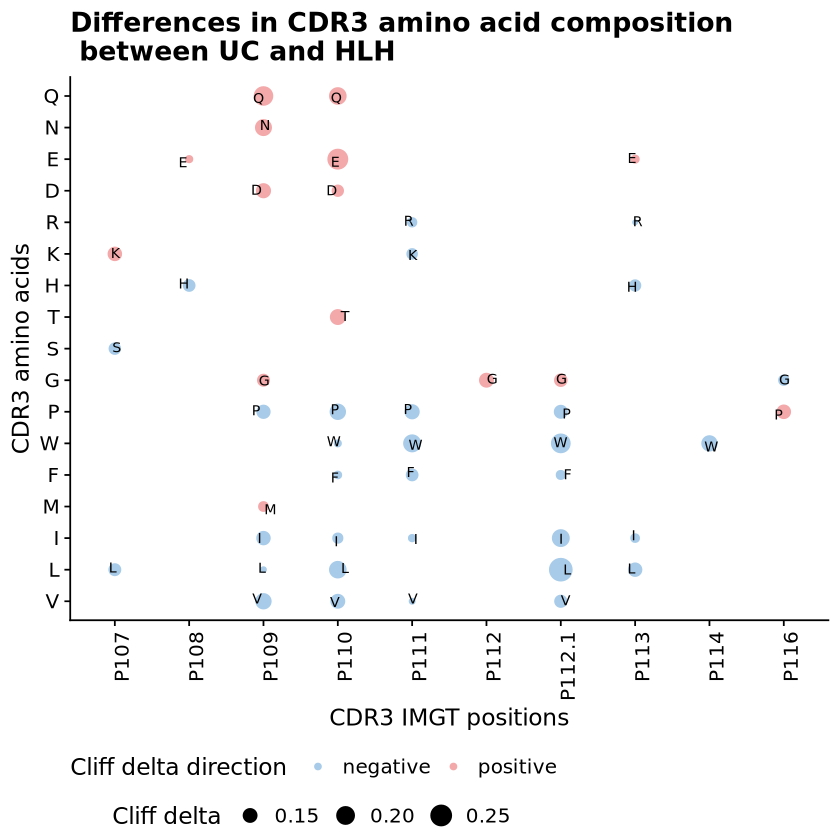

In [217]:
pl

#### UC vs HLH

integer(0)

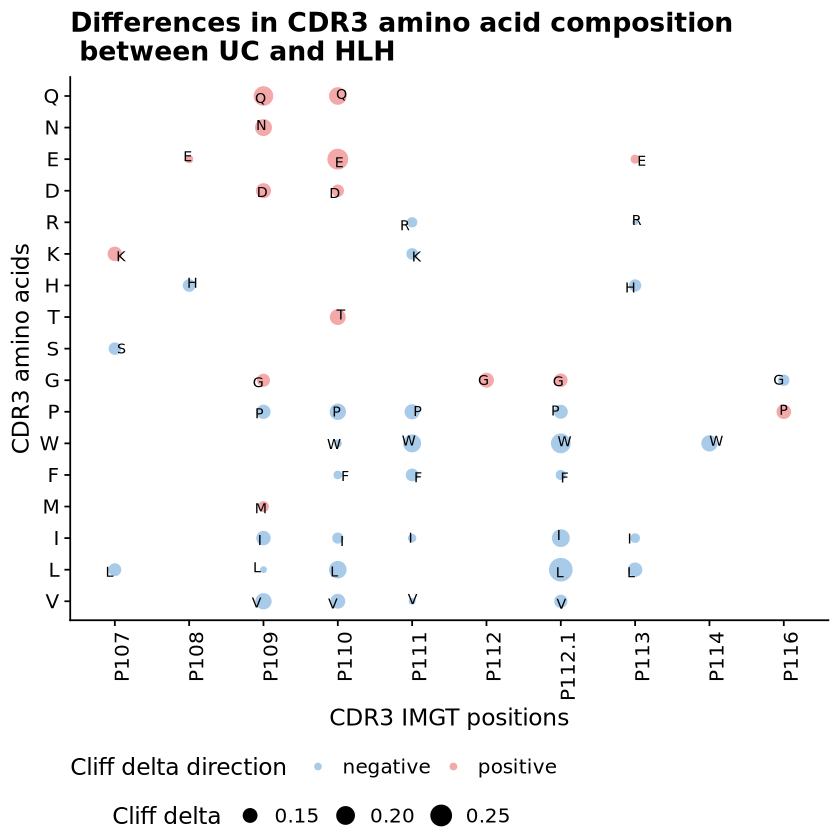

In [216]:
phen <- c('UC', 'HLH')
man_whit_results_all <- fread(paste0('/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/cdr3_compositions_permanova/man_whit_results_for_',phen[1],'_',phen[2],'.tsv'))[,
    p_val := as.numeric(p_val)][,
    cliff_delta := as.numeric(cliff_delta)][,
    c('Length_cdr3', 'IMGT') := tstrsplit(pair, "_", keep = c(1,2))]
man_whit_results_plot <- man_whit_results_all %>% filter(p_val <= 0.01) %>% 
    filter(abs(cliff_delta) >= 0.1) %>% 
    group_by(IMGT,AA) %>% filter(p_val == min(p_val))
pl <- ggplot(man_whit_results_plot,aes(x = IMGT, y = factor(AA, levels = aa_order))) + 
    geom_point(aes(color = ifelse(cliff_delta > 0, 'positive', 'negative'), 
        size = abs(cliff_delta))) +
    scale_color_manual(values = c('positive' = '#f3a8a9', 'negative' = '#a7cbe8')) +
    theme_cowplot() + 
    geom_text(aes(label = AA), size = 3, color = 'black', 
        position = position_jitter(width = 0.1, height = 0.1)) +
    #facet_wrap(~Length_cdr3, nrow = 1) +
    labs(y = 'CDR3 amino acids', x = 'CDR3 IMGT positions', color = 'Cliff delta direction', size = 'Cliff delta',
        title = paste0('Differences in CDR3 amino acid composition \n between ',phen[1],' and ',phen[2])) +
    theme(legend.position = 'bottom',
        legend.box = 'vertical',
        axis.text.x = element_text(angle = 90, hjust = 1)) 
pl
ggsave(paste0('/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/plots/cdr3_composition_differences_',phen[1],'_vs_',phen[2],'.pdf'), pl,
    width = 6, height = 6, dpi = 600) +
ggsave(paste0('/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/plots/cdr3_composition_differences_',phen[1],'_vs_',phen[2],'.png'), pl,
    width = 6, height = 6, dpi = 600)

### Violin plots of actual values between groups

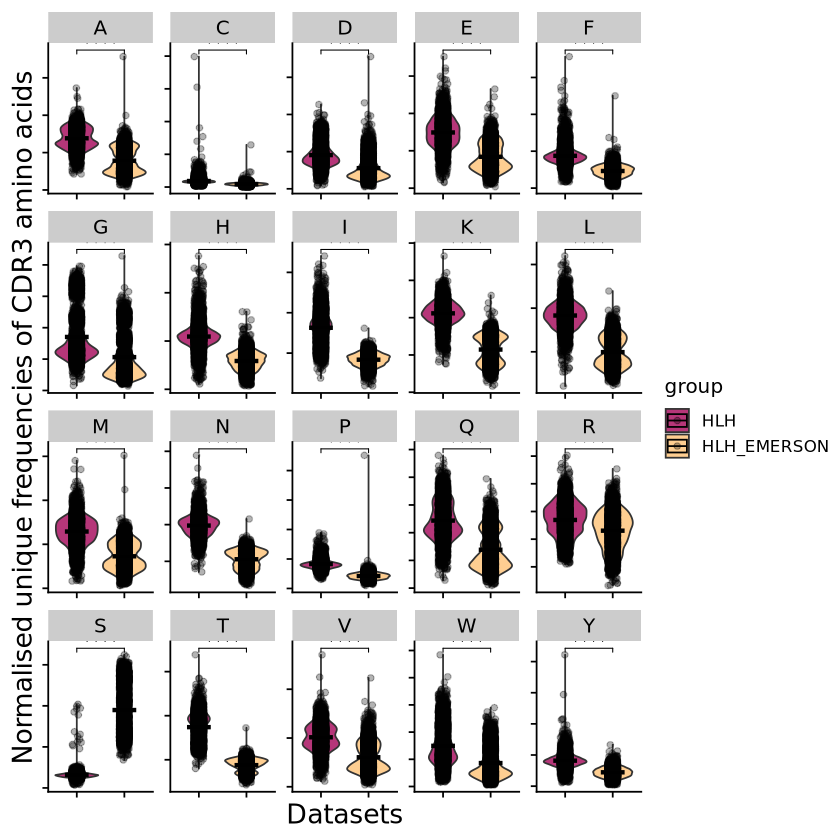

In [208]:
ggplot(cdr3_freq[IMGT == 'P107'], aes(x = group, y = norm_freq_unique, fill = group), show.legend = FALSE) + 
    geom_violin() + 
    stat_summary(fun = mean, #fun.min = mean, fun.max = mean,
               geom = "crossbar", width = 0.5, color = "black") +
    geom_jitter(width = 0.1, alpha = 0.3) +
    theme_cowplot() + 
    facet_wrap(. ~ AA, scales = 'free') +
    scale_fill_viridis_d(option = "magma", begin = 0.5, end = 0.9) + 
    labs(x = 'Datasets', y = 'Normalised unique frequencies of CDR3 amino acids', color = 'Dataset') +
    theme(legend.title = element_text(size = 12),
          legend.text = element_text(size = 10),
          axis.title = element_text(size = 16),
          axis.text = element_blank()) +
    stat_compare_means(method = "anova",vjust = -13) +               # Adds global p-value
    stat_compare_means(method = "t.test", label = "p.signif",
                     comparisons = list(c("HLH_EMERSON", "HLH"))) +
ggsave('/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/plots/cdr3_composition_differences_HLH_vs_HLH_EMERSON_P107.pdf', width = 6, height = 6, dpi = 600) +
ggsave('/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/plots/cdr3_composition_differences_HLH_vs_HLH_EMERSON_P107.png', width = 6, height = 6, dpi = 600)



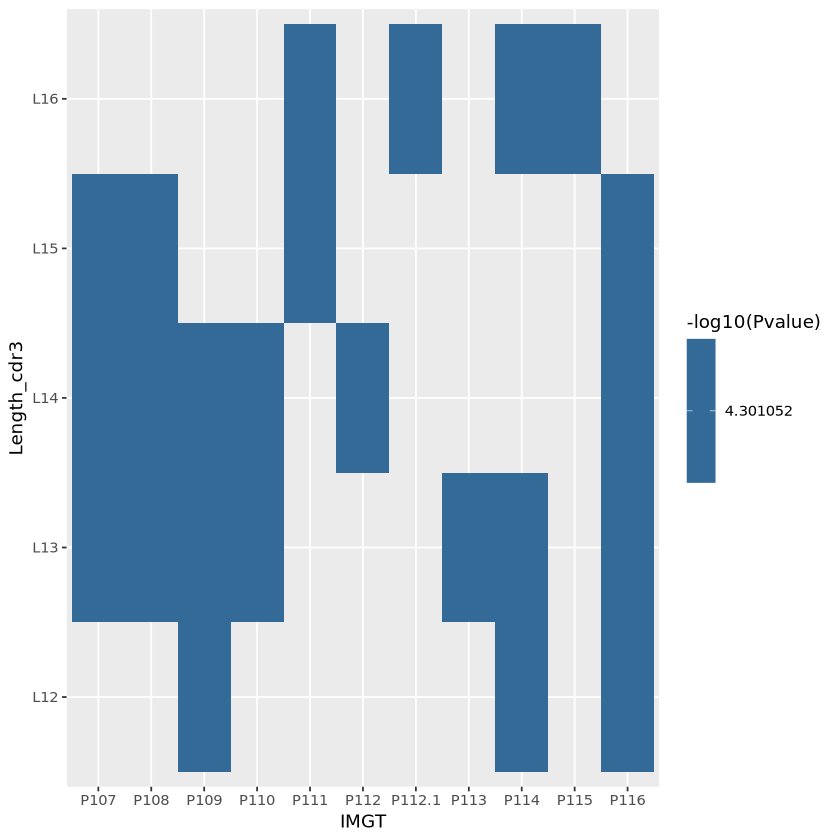

In [ ]:
ggplot(permanova_cdr3[Pvalue == min(Pvalue)], aes(x = IMGT, y = Length_cdr3, fill = -log10(Pvalue))) + 
    geom_tile()

### Correlations between HLA Sites and CDR3 positions all at once

In [221]:
cdr3_freq <- fread('/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/data/cdr3_all_freq_with_IRT.tsv')
n_ind <- uniqueN(cdr3_freq$patient_id)
imgt_to_discard <- c('P104', 'P105', 'P106', 'P117', 'P118')
cdr3_freq <- cdr3_freq[n_carriers >= (n_ind/2)][!(IMGT %in% imgt_to_discard)]
cdr3_freq$length_seq <- paste0('L', cdr3_freq$length_seq)
cdr3_freq_split_length <- split(cdr3_freq, cdr3_freq$length_seq)

phenotypes <- fread('/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/data/phenotypes.tsv')

cdr3_qtl_results <- fread('/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/conditional_analysis/cdr3_qtl_results.tsv', sep = '\t')
cdr3qtl_list <- cdr3_qtl_results[
  , .(Site_hla_list = list(unique(Site_hla))), 
  by = .(HLA, Length_cdr3)
]

#### Calculating correlations and saving only those with > 0.4

In [ ]:
first <- TRUE

hla_gene <- "DRB1"
    
cdr3_length_dt <- dt[, c('patient_id', 'length_seq', 'group', 'IMGT', 'AA', 'irt_freq_unique')]

sites_of_interest <- list.files('/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/hla_matrices/as_in_Ishigaki/')
for (site in sites_of_interest) {
    hla_site <- fread(paste0('/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/hla_matrices/as_in_Ishigaki/', site))
    site <- gsub('_matrix.tsv', '', site)
    hla_site_long <- melt(hla_site %>% dplyr::select('patient_id', contains('allele')), 
                            id.vars = c('patient_id'), variable.name = 'allele', value.name = 'allele_count')
    hla_site_long <- hla_site_long %>% merge(phenotypes) #%>% 
        #group_by(group, allele) %>% mutate(n_car = sum(allele_count)) %>%ungroup()  %>%
        #group_by(group) %>%filter(n_car != max(n_car)) %>% dplyr::select(-n_car)
    hla_cdr3 <- merge(hla_site_long, cdr3_length_dt, by = c('patient_id', 'group'))
    n_patients <- uniqueN(hla_cdr3$patient_id)
    hla_cdr3$allele <- gsub('allele', site, hla_cdr3$allele)
    hla_cdr3_correlations <- hla_cdr3 %>% 
        group_by(allele, length_seq, IMGT, AA, group) %>% 
        summarise('correlations' = cor(allele_count, irt_freq_unique), .groups = 'keep' ) %>%
        ungroup() %>%
        filter(abs(correlations) >= 0.4) %>%
        mutate('site' = site,  'n_ind_in_dts' = n_patients)
    hla_cdr3_high_cor <- merge(hla_cdr3, hla_cdr3_correlations, by = c('allele', 'IMGT', 'AA', "group"))
    if (first){
        hla_cdr3_correlations_all <- hla_cdr3_correlations
        hla_cdr3_all <- hla_cdr3_high_cor
        first <- FALSE
    } else {
        hla_cdr3_correlations_all <- rbind(hla_cdr3_correlations_all, hla_cdr3_correlations) 
        hla_cdr3_all <- rbind(hla_cdr3_all, hla_cdr3_high_cor)
    }
}

head(hla_cdr3_all)

In [ ]:
fwrite(hla_cdr3_all, paste0('/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/data/hla_',hla_gene,'_cdr3_all_irt_freq.tsv'), sep = '\t')
fwrite(hla_cdr3_correlations_all, paste0('/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/data/hla_',hla_gene,'_cdr3_correlations_all_irt_freq.tsv'), sep = '\t')

#### reading hla_cdr3_all and hla_cdr3_correlations_all

In [ ]:
hla_cdr3_correlations_all %>% filter(abs(correlations) >= 0.6)

In [138]:
hla_cdr3_all <- hla_cdr3_all %>% arrange(desc(allele)) %>% mutate(allele = factor(allele, levels = unique(allele)))
head(hla_cdr3_all)

allele    IMGT AA group patient_id allele_count irt_freq_unique correlations
1 DQA1_80_Y P109 Q  CD    I228       0             2.2032740      -0.40037    
2 DQA1_80_Y P109 Q  CD    I1281      1            -0.6469104      -0.40037    
3 DQA1_80_Y P109 Q  CD    I772       1             1.8820185      -0.40037    
4 DQA1_80_Y P109 Q  CD    I116       0             0.6810535      -0.40037    
5 DQA1_80_Y P109 Q  CD    I506       0             0.5155919      -0.40037    
6 DQA1_80_Y P109 Q  CD    I1345      1             1.7292358      -0.40037    
  site   
1 DQA1_80
2 DQA1_80
3 DQA1_80
4 DQA1_80
5 DQA1_80
6 DQA1_80

In [122]:
aa_order <- c("A", "V", "L", "I", "M", "F", "W", "P", "G", "C", "S", "T", "Y", "H", "K", "R", "D", "E", "N", "Q")

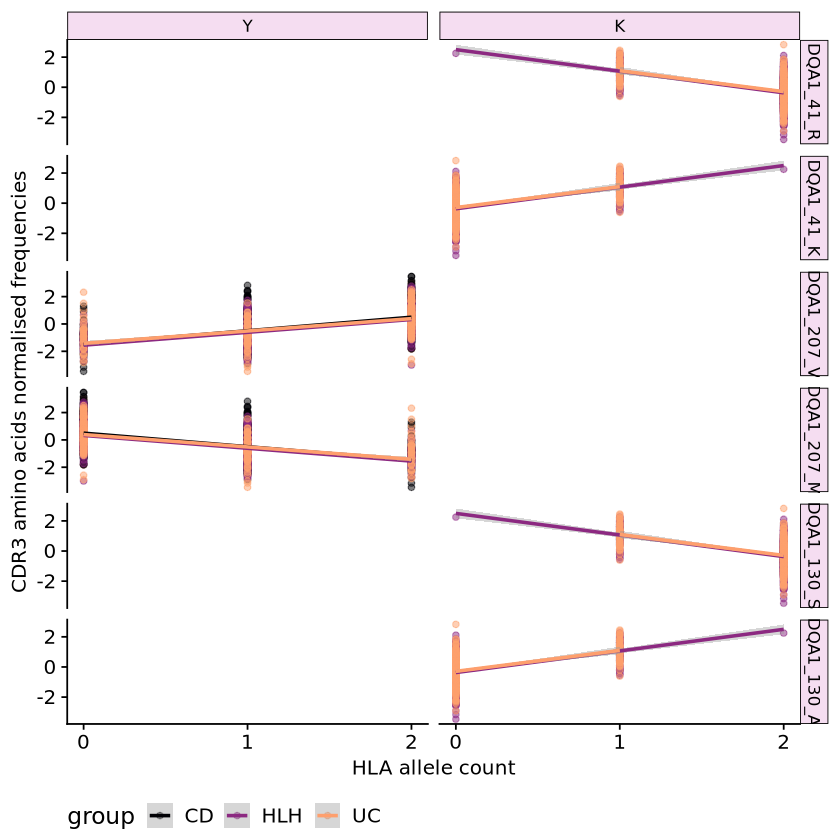

In [ ]:
hla_site <- "DQA1" #"DRB1_71"
hla_cdr3_for_plot <- hla_cdr3_all %>% filter(abs(correlations) >= 0.5)
hla_site_cdr3_plot <- ggplot(hla_cdr3_for_plot, aes(y = irt_freq_unique, x = allele_count, color = group)) + 
    geom_point(alpha = 0.5) + 
    geom_smooth(method = 'lm', formula = 'y ~ x' ) + 
    facet_grid(allele ~ factor(AA, levels = aa_order) , scales = 'free') + 
    theme_cowplot()  + 
    labs(x = 'HLA allele count', y = 'CDR3 amino acids normalised frequencies') +
    scale_color_viridis_d(option = 'magma', end = 0.8) +
    scale_x_continuous(breaks = 0:2, labels = c("0", "1", "2")) +
    theme(axis.text.x = element_text(size = 12), 
        axis.text.y = element_text(size = 12), 
        axis.title = element_text(size = 12), 
        strip.text = element_text(size = 10),
        strip.background = element_rect(fill = "#f5ddf1", color = "black"),
        legend.position = "bottom") 
hla_site_cdr3_plot
ggsave(paste0('/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/plots/',hla_site,'_cdr3_smooth_lines_cor_more_0.4.pdf'), 
    hla_site_cdr3_plot, width = 7, height = 7, dpi = 600)
ggsave(paste0('/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/plots/',hla_site,'_cdr3_smooth_lines_cor_more_0.4.png'), 
    hla_site_cdr3_plot, width = 7, height = 7, dpi = 600)

In [377]:
hla_cdr3_patterns <- hla_cdr3_correlations_all %>% group_by(site, allele, IMGT, AA) %>% 
    summarise(correlations = mean(correlations), .groups = 'keep')

In [378]:
hla_cdr3_patterns

site     allele     IMGT AA correlations
1  DQB1_185 DQB1_185_I P109 Q   0.4051566  
2  DQB1_185 DQB1_185_I P110 E   0.4676337  
3  DQB1_185 DQB1_185_I P110 R  -0.4795841  
4  DQB1_57  DQB1_57_A  P109 Y   0.4325783  
5  DQB1_74  DQB1_74_A  P108 G  -0.4148614  
6  DQB1_74  DQB1_74_A  P109 Y   0.4521295  
7  DQB1_74  DQB1_74_A  P113 Y   0.4172092  
8  DQB1_87  DQB1_87_F  P109 I   0.4162316  
9  DQB1_87  DQB1_87_F  P109 K   0.5541150  
10 DQB1_87  DQB1_87_F  P110 E  -0.5170196  
11 DQB1_87  DQB1_87_F  P113 E  -0.4603316  
12 DQB1_87  DQB1_87_F  P113 V   0.4013199  
13 DQB1_87  DQB1_87_Y  P110 R   0.4601290  
14 DQB1_9   DQB1_9_F   P109 K   0.4891438  
15 DQB1_9   DQB1_9_F   P110 E  -0.4836356  
16 DQB1_9   DQB1_9_F   P113 E  -0.4333956  
17 DQB1_9   DQB1_9_F   P113 V   0.4200479

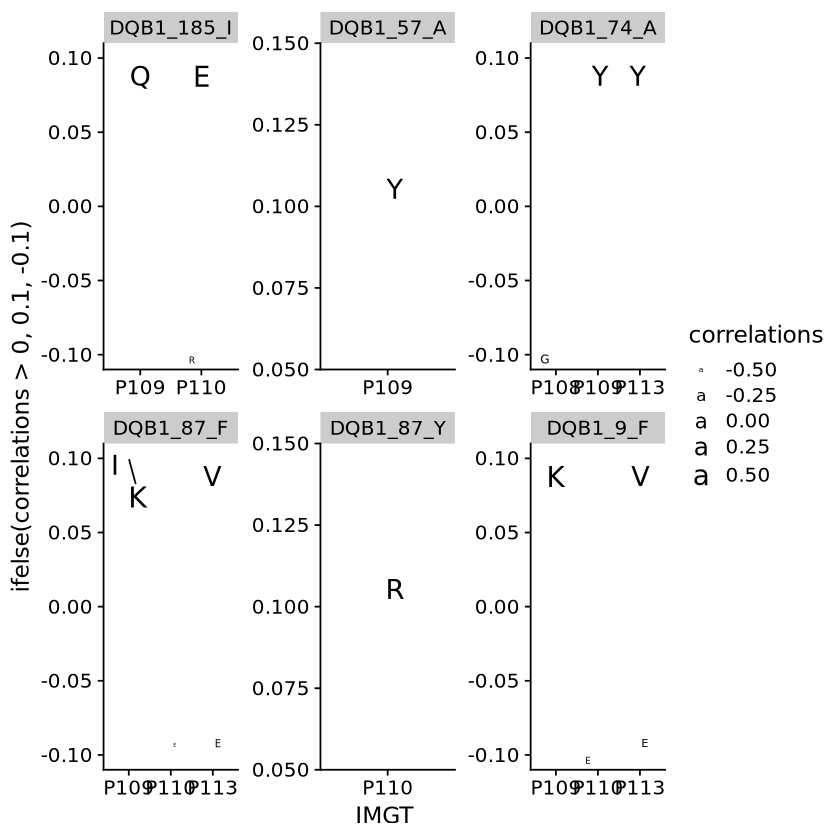

In [380]:
ggplot(hla_cdr3_patterns, aes(x = IMGT, y = ifelse(correlations > 0, 0.1, -0.1), size = correlations)) +
 ggrepel::geom_text_repel(aes(label = AA)) +
 theme_cowplot() +
 facet_wrap( ~ allele, scales = 'free')

In [365]:
aa_hydrophobicity <- list(HYDROPHOBIC = c('I','V','L','F','C','M','A','W'),
     NEUTRAL = c('G','T','S','Y','P','H'),
     HYDROPHILIC = c('N','D','Q','E','K','R'))
aa_charge <- list(Positive_charged = c('R', 'H', 'K'),
    Negative_charged = c('D', 'E'),
    Uncharged = c('A', 'N', 'C', 'Q', 'G', 'I', 'L', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V'))
aa_polarity <- list(Polar = c('D', 'E', 'H', 'K', 'R', 'N', 'Q', 'S', 'T', 'Y'),
    Nonpolar = c('A', 'C', 'G', 'I', 'L', 'M', 'F', 'P', 'V', 'W'))

aa_properties_dt <- data.table(AA = aa_hydrophobicity, property = names(aa_hydrophobicity)) %>% unnest(cols = c(AA))
aa_charge_dt <- data.table(AA = aa_charge, charge = names(aa_charge)) %>% unnest(cols = c(AA))
aa_polarity_dt <- data.table(AA = aa_polarity, polarity = names(aa_polarity)) %>% unnest(cols = c(AA))
aa_properties <- merge(aa_properties_dt, aa_charge_dt, by = 'AA')
aa_properties <- merge(aa_properties, aa_polarity_dt, by = 'AA')

In [ ]:
hla_cdr3_correlations_all <- rename(hla_cdr3_correlations_all, 'variant' = 'allele')
variants_in_data <- unique(hla_cdr3_correlations_all$variant)
hla_alleles_patients <- fread('/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/data/hla/hla_features.tsv')  
hla_variants <- fread(paste0('/work_beegfs/sukmb667/projects/cdr3-qtl/reference_data/hla_msa/', hla_gene, '_long.tsv'))
hla_variants$variant <- paste0(hla_gene,'_', hla_variants$site, '_', hla_variants$AA)
hla_variants <- hla_variants %>% group_by(variant) %>% reframe(allele) %>% 
    ungroup() %>%
    filter(allele %in% hla_alleles_patients$allele) %>% 
    filter(variant %in% variants_in_data)

In [392]:
setDT(hla_variants)
hla_variants_listed <- hla_variants[, .(alleles = unlist(lapply(list(unique(allele)), 
    function(x) paste0(unlist(x),collapse = "\n")))), 
    by = variant]
#hla_variants <- hla_variants[, .(alleles = paste0(alleles, sep = "\n")), by = variant]


In [393]:
hla_variants_listed

variant   
1 DQB1_185_I
2 DQB1_57_A 
3 DQB1_74_A 
4 DQB1_87_F 
5 DQB1_87_Y 
6 DQB1_9_F  
  alleles                                                               
1 DQB1*03:02\nDQB1*03:03\nDQB1*04:02                                    
2 DQB1*02:01\nDQB1*03:02                                                
3 DQB1*02:01                                                            
4 DQB1*06:01\nDQB1*06:02\nDQB1*06:03                                    
5 DQB1*05:01\nDQB1*05:02\nDQB1*05:03\nDQB1*05:04\nDQB1*06:04\nDQB1*06:09
6 DQB1*06:02\nDQB1*04:02

In [397]:
min_max <- hla_cdr3_correlations_all %>% 
    filter(abs(correlations) > 0.4)
min_max_alleles <- merge(merge(min_max, hla_variants_listed, by = 'variant'), aa_properties, by ='AA')
min_max_alleles$HLA_AA <- unlist(lapply(min_max_alleles$variant, function(x) unlist(strsplit(x, '_'))[3]))
min_max_alleles <- merge(min_max_alleles, aa_properties, by.x = 'HLA_AA', by.y = 'AA', suffixes = c('_CDR3', '_HLA'))


In [398]:
min_max_alleles_for_plot <- min_max_alleles %>% 
    group_by(variant, AA) %>% 
    filter(abs(correlations) == max(abs(correlations)))

In [ ]:
for (hla_site in unique(min_max_alleles$site)) {
    df <- min_max_alleles_for_plot %>% filter(site == hla_site)
    n_x <- length(unique(df$HLA_AA))
    n_y <- length(unique(df$AA))
    plot_width <- ifelse(n_x > 3, 3 * n_x, 4 * n_x)
    plot_height <- 2 * n_y
    hla_cdr3_cor_plot <- ggplot(data = df, 
            aes(x = HLA_AA, y = AA, fill = correlations, label = IMGT)) + 
        geom_tile() + 
        scale_fill_gradient2(low = "#4A09E1", mid = "white", high = "#DC2162", midpoint = 0) +
        geom_text(color = 'white', size = 4) +
        theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
        labs(x = paste0('HLA-',paste0(unlist(strsplit(hla_site, '_')), collapse = ' residues at site ')), 
            y = 'CDR3 amino acid', fill = 'Pearson correlation') +
        facet_wrap( ~ alleles, nrow = 1, strip.position = "bottom", scales = 'free') +
        theme_cowplot() +
        theme(axis.text.x = element_text(size = 12),
            strip.background.x = element_blank(),
            strip.text.x = element_text(size = 12), 
            axis.text.y = element_text(size = 12)
        )
    ggsave(paste0('/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/plots/',hla_site,'_cdr3_correlations_min_max.pdf'), 
        hla_cdr3_cor_plot, width = plot_width, height = plot_height, dpi = 600)
}

### Graphical exploration of the HLA and CDR3 relationships based on chemical properties

In [396]:
head(min_max_alleles)

HLA_AA AA variant   IMGT group correlations site    alleles               
1 A      G  DQB1_74_A P108 UC    -0.4148614   DQB1_74 DQB1*02:01            
2 A      Y  DQB1_57_A P109 UC     0.4422841   DQB1_57 DQB1*02:01\nDQB1*03:02
3 A      Y  DQB1_74_A P113 UC     0.4174277   DQB1_74 DQB1*02:01            
4 A      Y  DQB1_74_A P113 HLH    0.4169907   DQB1_74 DQB1*02:01            
5 A      Y  DQB1_57_A P109 HLH    0.4228724   DQB1_57 DQB1*02:01\nDQB1*03:02
6 A      Y  DQB1_74_A P109 UC     0.4231306   DQB1_74 DQB1*02:01            
  property_CDR3 charge_CDR3 polarity_CDR3 property_HLA charge_HLA polarity_HLA
1 NEUTRAL       Uncharged   Nonpolar      HYDROPHOBIC  Uncharged  Nonpolar    
2 NEUTRAL       Uncharged   Polar         HYDROPHOBIC  Uncharged  Nonpolar    
3 NEUTRAL       Uncharged   Polar         HYDROPHOBIC  Uncharged  Nonpolar    
4 NEUTRAL       Uncharged   Polar         HYDROPHOBIC  Uncharged  Nonpolar    
5 NEUTRAL       Uncharged   Polar         HYDROPHOBIC  Uncharged  Nonpolar    
6 NEUTRAL       Uncharged   Polar         HYDROPHOBIC  Uncharged  Nonpolar

In [400]:
prop_levels <- c('Positive', 'Uncharged', 'Negative')
min_max_alleles$charge_CDR3 <- gsub('_charged', '', min_max_alleles$charge_CDR3)
min_max_alleles$charge_HLA <- gsub('_charged', '', min_max_alleles$charge_HLA)
pl_charge <- ggplot(data = min_max_alleles, 
            aes(x = HLA_AA, y = AA, fill = factor(charge_CDR3,levels = prop_levels), color = factor(charge_HLA,levels = prop_levels))) + 
        geom_tile(linewidth = 2) + 
        scale_fill_viridis_d(option = 'turbo', begin = 0.1, end = 0.8, direction = -1) +
        scale_color_viridis_d(option = 'turbo', begin = 0.1, end = 0.8, , direction = -1) +
        #geom_text(color = 'white', size = 4) +
        theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
        labs(x = "HLA residues", #paste0('HLA-',paste0(unlist(strsplit(hla_site, '_')), collapse = ' residues at site ')), 
            y = 'CDR3 amino acid', fill = 'charge CDR3', color = "charge HLA") +
        facet_wrap( ~ variant, strip.position = "bottom", scales = 'free') +
        theme_cowplot() +
        theme(axis.text.x = element_blank(),
            legend.position = 'bottom',
            legend.box = 'vertical',
            strip.background.x = element_blank(),
            strip.text.x = element_text(size = 12), 
            axis.text.y = element_text(size = 12)
        )
ggsave(paste0('/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/plots/',hla_gene,'_cdr3_charge_min_max.pdf'), 
        pl_charge, width = 6, height = 6, dpi = 600)

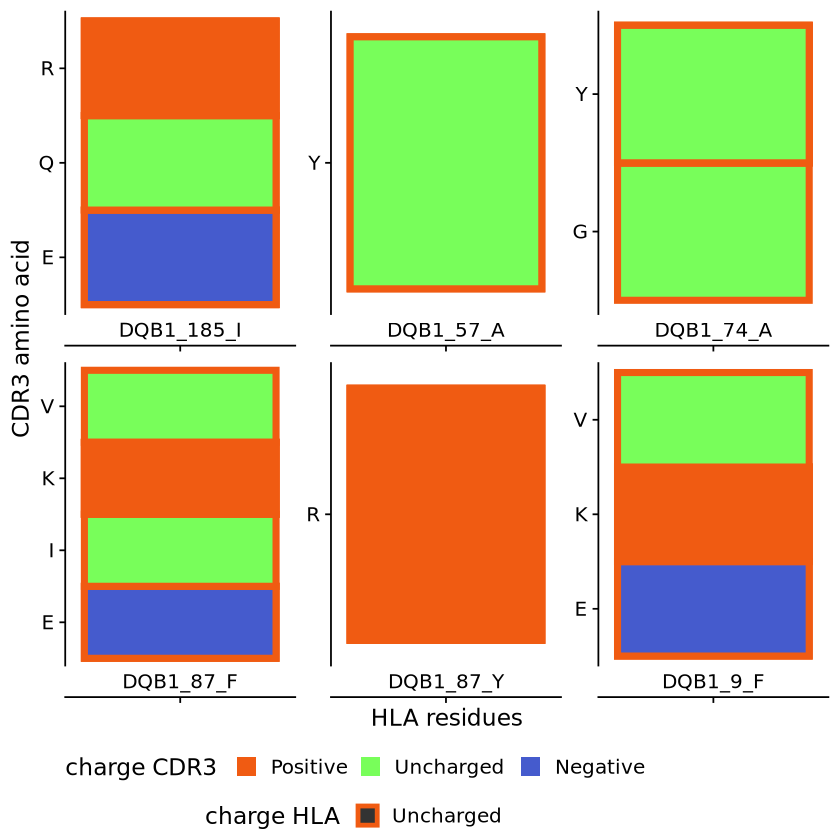

In [401]:
pl_charge

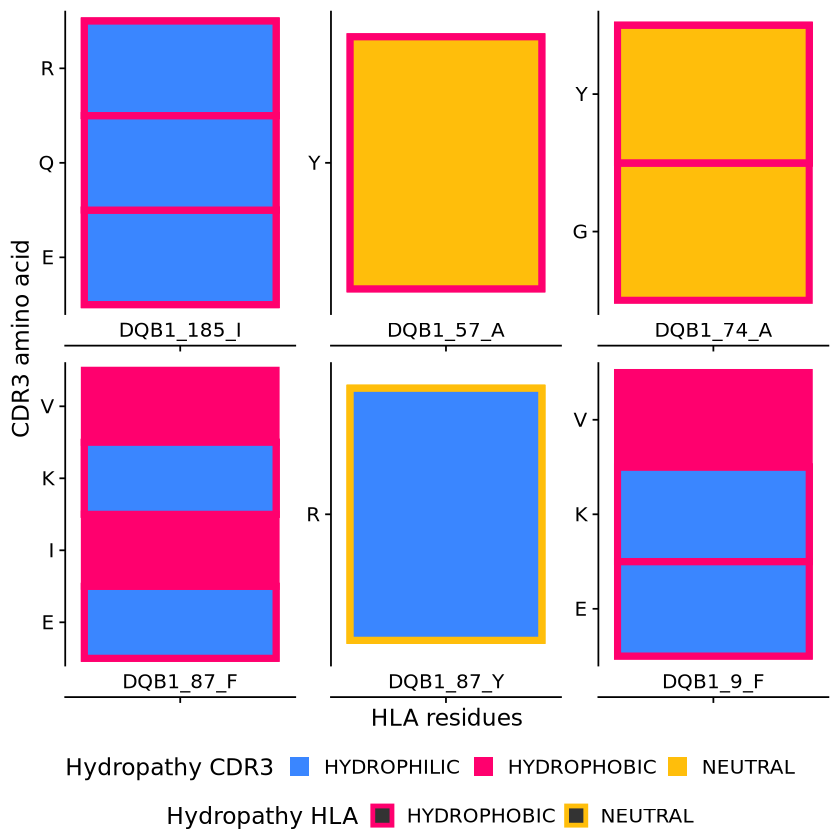

In [402]:
prop_levels <- c('HYDROPHILIC', 'HYDROPHOBIC', 'NEUTRAL')
pl_hydro <- ggplot(data = min_max_alleles, 
            aes(x = HLA_AA, y = AA, fill = factor(property_CDR3, levels = prop_levels), 
            color = factor(property_HLA, levels = prop_levels))) + 
        geom_tile(linewidth = 2) + 
        scale_fill_manual(values = c('HYDROPHILIC' = '#3a86ff', 'HYDROPHOBIC' = '#ff006e', 'NEUTRAL' = '#ffbe0b')) +
        scale_color_manual(values = c('HYDROPHILIC' = '#3a86ff', 'HYDROPHOBIC' = '#ff006e', 'NEUTRAL' = '#ffbe0b')) +
        #geom_text(color = 'white', size = 4) +
        theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
        labs(x = "HLA residues", #paste0('HLA-',paste0(unlist(strsplit(hla_site, '_')), collapse = ' residues at site ')), 
            y = 'CDR3 amino acid', fill = 'Hydropathy CDR3', color = "Hydropathy HLA") +
        facet_wrap( ~ variant, strip.position = "bottom", scales = 'free') +
        theme_cowplot() +
        theme(axis.text.x = element_blank(),
            legend.position = 'bottom',
            legend.box = 'vertical',
            strip.background.x = element_blank(),
            strip.text.x = element_text(size = 12), 
            axis.text.y = element_text(size = 12)
        )
pl_hydro
ggsave(paste0('/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/plots/',hla_gene,'_cdr3_hydro_min_max.pdf'), pl_hydro, width = 6, height = 6, dpi = 600)

### Which HLA alleles contribute the most to the cdr3-QTLs

In [403]:
sites_of_interest
hla_cdr3_patterns <- rename(hla_cdr3_patterns, 'site_variant' = 'allele')

[1] "DQB1_74"  "DQB1_57"  "DQB1_9"   "DQB1_185" "DQB1_13"  "DQB1_45"  "DQB1_87"

In [404]:
hla_alleles_long <- fread(paste0('/work_beegfs/sukmb667/projects/cdr3-qtl/reference_data/hla_msa/',hla_gene,'_long.tsv'))
hla_alleles_long <- hla_alleles_long[allele %in% hla_alleles_patients$allele]
hla_alleles_long$site <- paste0(hla_gene, '_', hla_alleles_long$site)
hla_alleles_long <- hla_alleles_long[site %in% sites_of_interest]
hla_alleles_long <- hla_alleles_long %>% rowwise() %>%
    mutate(site_variant = paste(site, AA, sep = '_')) %>% ungroup() %>%
    dplyr::select(-AA)

In [405]:
dim(hla_cdr3_patterns)
dim(hla_alleles_long)
hla_cdr3_patterns_with_alleles <- merge(hla_cdr3_patterns, hla_alleles_long, by = c('site_variant', 'site'))


[1] 17  5

[1] 98  3

In [476]:
hla_alleles_highest_cdr3_influence <- hla_cdr3_patterns_with_alleles %>% 
    dplyr::select(allele, AA) %>% 
    unique() %>%
    group_by(allele) %>% 
    mutate(n_AA = n()) %>% ungroup() %>% arrange(allele) %>%
    merge(aa_properties, by = 'AA')

In [477]:
head(hla_alleles_highest_cdr3_influence)

AA allele     n_AA property    charge           polarity
1 E  DQB1*03:02 4    HYDROPHILIC Negative_charged Polar   
2 E  DQB1*06:01 4    HYDROPHILIC Negative_charged Polar   
3 E  DQB1*03:03 3    HYDROPHILIC Negative_charged Polar   
4 E  DQB1*06:02 4    HYDROPHILIC Negative_charged Polar   
5 E  DQB1*04:02 5    HYDROPHILIC Negative_charged Polar   
6 E  DQB1*06:03 4    HYDROPHILIC Negative_charged Polar

In [494]:
uniqueN(hla_alleles_highest_cdr3_influence$allele)

[1] 13

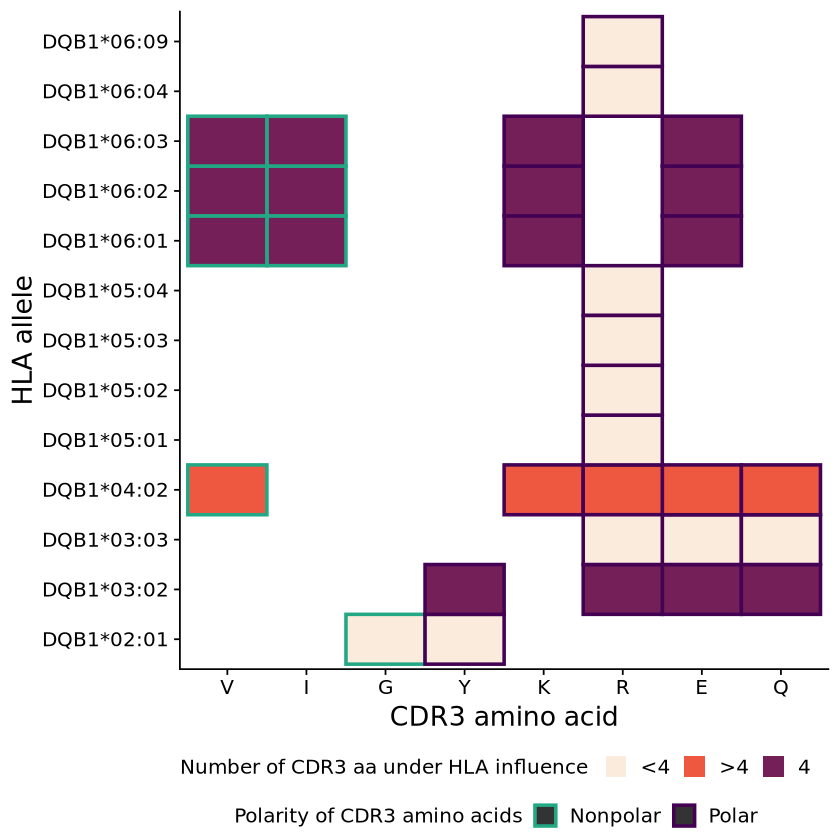

In [486]:
pl <- ggplot(hla_alleles_highest_cdr3_influence, aes(y = allele, x = factor(AA, levels = aa_order), 
    fill = ifelse(n_AA > 3, ifelse(n_AA > 4, '>4', '4'), '<4'))) +
    scale_fill_viridis_d(option = 'rocket', begin = 0.3, direction = -1) +
    scale_color_viridis_d(option = 'viridis', end = 0.6, direction = -1) +
    geom_tile(aes(color = polarity), size = 1) +
    theme_cowplot() +
    theme(axis.text.x = element_text(hjust = 1)) +
    labs(y = 'HLA allele', x = 'CDR3 amino acid', 
        fill = 'Number of CDR3 aa under HLA influence', color = 'Polarity of CDR3 amino acids') +
        theme(axis.text.y = element_text(size = 12 ),
            axis.text.x = element_text(size = 12, hjust = 0.5),
            axis.title = element_text(size = 16),
            legend.text = element_text(size = 12),
            legend.title = element_text(size = 12),
            legend.position = 'bottom', legend.box = 'vertical')
pl

In [487]:
ggsave('/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/plots/dqb1_cdr3_aa_influence.pdf', pl, width = 7, height = 6, dpi = 600)

In [489]:
hla_alleles_wide <- dcast(hla_alleles_long, allele ~ site, value = 'AA')

Using site_variant as value column: use value.var to override.



In [490]:
head(hla_alleles_wide)

allele     DQB1_13   DQB1_185   DQB1_45   DQB1_57   DQB1_74   DQB1_87  
1 DQB1*02:01 DQB1_13_G DQB1_185_T DQB1_45_G DQB1_57_A DQB1_74_A DQB1_87_L
2 DQB1*03:01 DQB1_13_A DQB1_185_T DQB1_45_E DQB1_57_D DQB1_74_E DQB1_87_L
3 DQB1*03:02 DQB1_13_G DQB1_185_I DQB1_45_G DQB1_57_A DQB1_74_E DQB1_87_L
4 DQB1*03:03 DQB1_13_G DQB1_185_I DQB1_45_G DQB1_57_D DQB1_74_E DQB1_87_L
5 DQB1*04:02 DQB1_13_G DQB1_185_I DQB1_45_G DQB1_57_D DQB1_74_S DQB1_87_L
6 DQB1*05:01 DQB1_13_G DQB1_185_T DQB1_45_G DQB1_57_V DQB1_74_S DQB1_87_Y
  DQB1_9  
1 DQB1_9_Y
2 DQB1_9_Y
3 DQB1_9_Y
4 DQB1_9_Y
5 DQB1_9_F
6 DQB1_9_Y

In [155]:
number_zeros <- as.data.frame(colSums(cdr3_hla_matrix == 0 ))
colnames(number_zeros) <- 'num_zero'
number_zeros$variables <- rownames(number_zeros)
number_zeros <- number_zeros %>% filter(!variables %in% c('pair', 'patient_id', 'PC1', 'PC2', 'PC3')) %>% filter(!grepl('allele', variables))

In [156]:
aa_include <- number_zeros %>% filter(num_zero < 300) %>% pull(variables)

[1] "T" "G" "I" "R" "N" "A" "C" "L" "V" "P" "S" "F"

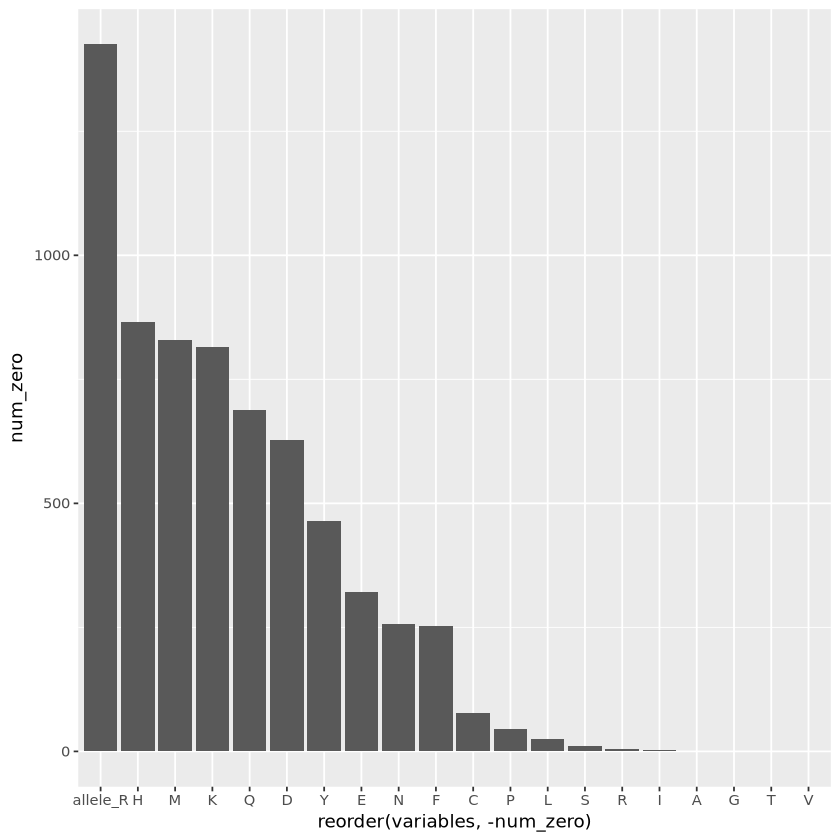

In [138]:
ggplot(number_zeros, aes(x = reorder(variables, -num_zero), y = num_zero)) +
    geom_col()

In [90]:
cor(new_cdr3_hla_matrix %>% select(any_of(amino_acids))) > 0.6

A     C     D     E     F     G     H     I     K     L     M     N     P    
A  TRUE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
C FALSE  TRUE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
D FALSE FALSE  TRUE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
E FALSE FALSE FALSE  TRUE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
F FALSE FALSE FALSE FALSE  TRUE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
G FALSE FALSE FALSE FALSE FALSE  TRUE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
H FALSE FALSE FALSE FALSE FALSE FALSE  TRUE FALSE FALSE FALSE FALSE FALSE FALSE
I FALSE FALSE FALSE FALSE FALSE FALSE FALSE  TRUE FALSE FALSE FALSE FALSE FALSE
K FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE  TRUE FALSE FALSE FALSE FALSE
L FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE  TRUE FALSE FALSE FALSE
M FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE  TRUE FALSE FALSE
N FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE  TRUE FALSE
P FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE  TRUE
Q FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
R FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
S FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
T FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
V FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
Y FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  Q     R     S     T     V     Y    
A FALSE FALSE FALSE FALSE FALSE FALSE
C FALSE FALSE FALSE FALSE FALSE FALSE
D FALSE FALSE FALSE FALSE FALSE FALSE
E FALSE FALSE FALSE FALSE FALSE FALSE
F FALSE FALSE FALSE FALSE FALSE FALSE
G FALSE FALSE FALSE FALSE FALSE FALSE
H FALSE FALSE FALSE FALSE FALSE FALSE
I FALSE FALSE FALSE FALSE FALSE FALSE
K FALSE FALSE FALSE FALSE FALSE FALSE
L FALSE FALSE FALSE FALSE FALSE FALSE
M FALSE FALSE FALSE FALSE FALSE FALSE
N FALSE FALSE FALSE FALSE FALSE FALSE
P FALSE FALSE FALSE FALSE FALSE FALSE
Q  TRUE FALSE FALSE FALSE FALSE FALSE
R FALSE  TRUE FALSE FALSE FALSE FALSE
S FALSE FALSE  TRUE FALSE FALSE FALSE
T FALSE FALSE FALSE  TRUE FALSE FALSE
V FALSE FALSE FALSE FALSE  TRUE FALSE
Y FALSE FALSE FALSE FALSE FALSE  TRUE

In [49]:
head(cdr3_hla_matrix)

patient_id allele_F allele_G allele_H allele_R allele_S allele_Y PC1        
1 H0         0        0        0        1        0        0        -0.02101601
2 H1         0        0        0        1        0        1        -0.02626366
3 H10        0        0        0        0        2        0        -0.02111234
4 H100       0        0        0        0        1        0        -0.01316378
5 H101       0        0        0        1        1        0        -0.02378662
6 H102       0        1        0        0        1        0        -0.02312737
  PC2         PC3         ⋯ N          P          Q          R         
1  0.03112553  0.01169280 ⋯ 0.01521389 0.04534336 0.06741841 0.09781636
2  0.02782574 -0.01372437 ⋯ 0.01584392 0.04308619 0.06944357 0.10125782
3 -0.01396576  0.01319399 ⋯ 0.01480198 0.04718582 0.06816131 0.09502148
4 -0.01334616  0.01165671 ⋯ 0.01959344 0.04356383 0.07111803 0.10061101
5  0.03222019  0.01045732 ⋯ 0.01665108 0.04568794 0.07333038 0.10121889
6 -0.02411205  0.02303986 ⋯ 0.01558114 0.04780427 0.06897695 0.08853626
  S          T          V          W          Y           pair           
1 0.07195275 0.09044806 0.04283754 0.01106736 0.009605632 DRB1_13_13_P109
2 0.07450014 0.09356762 0.03813497 0.01106125 0.011735457 DRB1_13_13_P109
3 0.07718690 0.08776490 0.03278097 0.01223871 0.010361385 DRB1_13_13_P109
4 0.07611186 0.08604077 0.03789437 0.01383585 0.011368310 DRB1_13_13_P109
5 0.06863855 0.09106419 0.03945404 0.01194284 0.010728874 DRB1_13_13_P109
6 0.07775101 0.08811634 0.03606869 0.01160298 0.009945411 DRB1_13_13_P109

In [43]:
cdr3_hla_matrix_allele <- cdr3_hla_matrix %>% dplyr::select(patient_id, allele_R, any_of(amino_acids))

In [53]:
cor(cdr3_hla_matrix$allele_R, cdr3_hla_matrix$K, method = 'spearman')

[1] 0.6297907

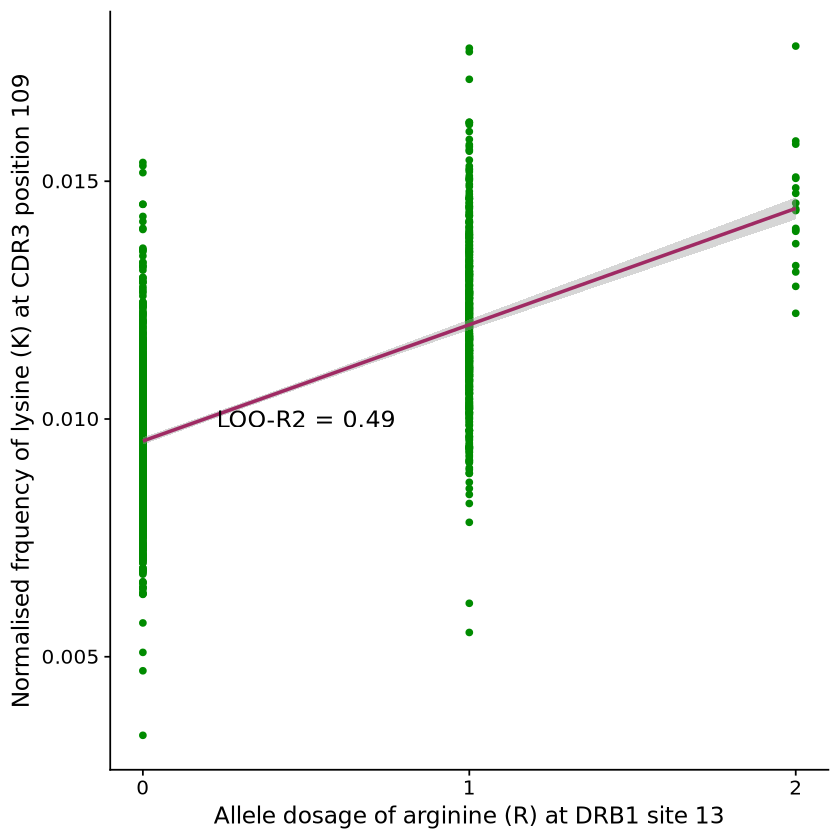

In [52]:
lm_plot_for_allele_r_and_k <- ggplot(cdr3_hla_matrix, aes(x = allele_R, y = K)) +
    geom_point(color = 'green4') +
    scale_x_continuous(breaks = c(0,1,2)) + 
    scale_color_viridis_c() +
    theme_cowplot() +
    stat_smooth(method = "lm", formula = 'y ~ x', se = TRUE, color = '#9f2a63') + 
    labs(x = 'Allele dosage of arginine (R) at DRB1 site 13', y = 'Normalised frquency of lysine (K) at CDR3 position 109') +
    annotate("text", x = 0.5, y=0.01,  label = "LOO-R2 = 0.49", color = "black", size = 5) 
lm_plot_for_allele_r_and_k
#ggsave('../../plots/lm_plot_for_allele_r_and_k_green.png', lm_plot_for_allele_r_and_k)    

In [64]:
cdr3_hla_matrix <- fread('../../cdr3_hla_pairs/norm_freq_unique/DQB1_87_13_P110_matrix.tsv')
amino_acids <-c('A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y') 
cdr3_long <- fread('../../cdr3_hla_pairs/CDR3_GROUPS_FREQ/13_P110.tsv')

In [94]:
cdr3_long_irt <- fread('../../cdr3_hla_pairs/CDR3_GROUPS_IRT/13_P110.tsv')

In [95]:
freq_expand <- ggplot() +
    geom_histogram(data = cdr3_long, aes(norm_freq_expand), bins = 50, color = '#bc3754', alpha = 0.3) +
    #geom_histogram(data = cdr3_long, aes(norm_freq_unique), bins = 50, color = '#28ae80', alpha = 0.3) +
    theme_cowplot() +
    facet_wrap(~AA, scales = 'free', ncol = 5) + 
    theme(legend.position = 'bottom',  
        axis.text.x = element_text(size = 8, angle = 35, hjust = 1),
        axis.text.y = element_text(size = 5),
        strip.background = element_rect(fill = "white")) +
    guides(fill=guide_colourbar(barwidth=15)) + 
    labs(x = 'AA frequency with expansion')
freq_unique <- ggplot() +
    geom_histogram(data = cdr3_long, aes(norm_freq_unique), bins = 50, color = '#28ae80', alpha = 0.3) +
    theme_cowplot() +
    facet_wrap(~AA, scales = 'free', ncol = 5) + 
    theme(legend.position = 'bottom',  
        axis.text.x = element_text(size = 8, angle = 35, hjust = 1),
        axis.text.y = element_text(size = 5),
        strip.background = element_rect(fill = "white")) +
    guides(fill=guide_colourbar(barwidth=15)) + 
    labs(x = 'AA frequency unique')
irt_unique <- ggplot() +
    geom_histogram(data = cdr3_long_irt, aes(irt_freq_unique), bins = 50, color = '#fec488', alpha = 0.3) +
    theme_cowplot() +
    facet_wrap(~AA, scales = 'free', ncol = 5) + 
    theme(legend.position = 'bottom',  
        axis.text.x = element_text(size = 8, angle = 35, hjust = 1),
        axis.text.y = element_text(size = 5),
        strip.background = element_rect(fill = "white")) +
    guides(fill=guide_colourbar(barwidth=15)) + 
    labs(x = 'AA frequency unique (IRT)')

In [98]:
both <-   freq_expand | freq_unique | irt_unique
ggsave('../../plots/comparing_cdr3_frequencies.png', both, width = 20)

Saving 20 x 6.67 in image



# Check if there are differences in frequencies in CDR3 from different lengths

In [66]:
cdr3_hla_matrix %>% summarise(across(contains('allele'), sum)) %>% t() %>% as.data.frame() %>% arrange(desc(V1)) %>% slice(-1) %>% rownames()

[1] "allele_Y" "allele_F"

In [80]:
cdr3_hla_matrix_allele_long <- melt(cdr3_hla_matrix %>% dplyr::select(patient_id, allele_Y, any_of(amino_acids)), 
                                    id.vars = c('patient_id', 'allele_Y'))

Saving 6.67 x 6.67 in image



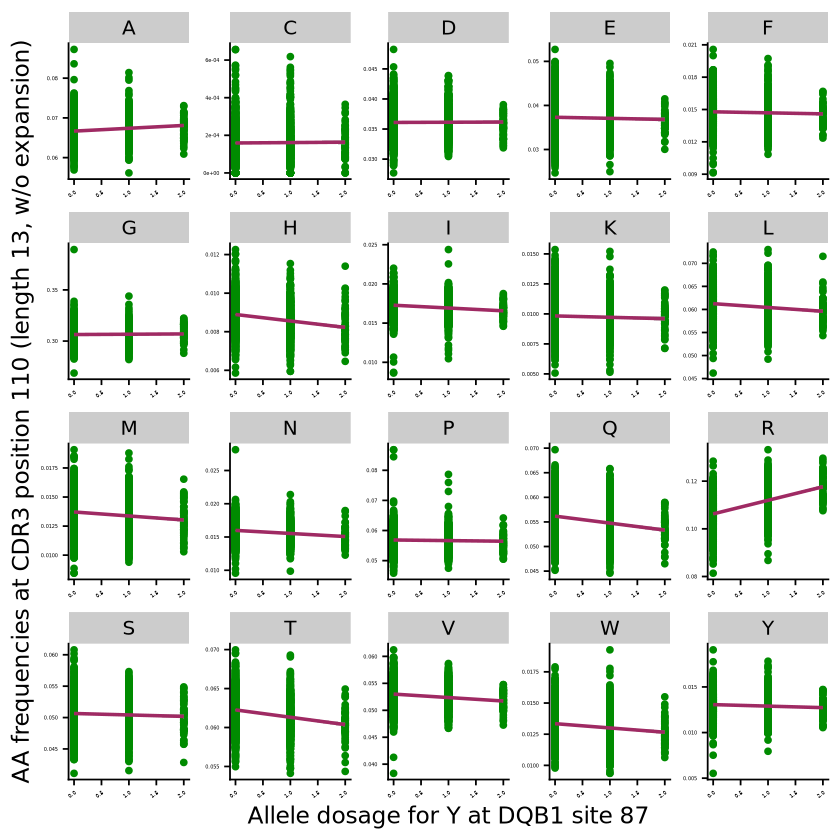

In [81]:
lm_plot_drb1_13_13_p109 <- ggplot(cdr3_hla_matrix_allele_long, aes(x = allele_Y, y = value)) +
    geom_point(color = 'green4') +
    scale_color_viridis_c() +
    theme_cowplot()+
    stat_smooth(method = "lm", formula = 'y ~ x', color = '#9f2a63') + 
    facet_wrap(~variable, scales = 'free') +
    labs( x = 'Allele dosage for Y at DQB1 site 87', y = 'AA frequencies at CDR3 position 110 (length 13, w/o expansion)') +
    theme(axis.text.x = element_text(size = 3, angle = 35, hjust = 1),
        axis.text.y = element_text(size = 3))
lm_plot_drb1_13_13_p109
ggsave('../../plots/lm_plot_for_dqb1_87_13_p110_freq_allele_Y.png', lm_plot_drb1_13_13_p109) 

In [143]:
anova(mod1, mod0)

Res.Df Df Gen.var.  Pillai      approx F  num Df den Df Pr(>F)   
1 1892   NA 0.7607240          NA        NA NA       NA          NA
2 1893    1 0.7606937 0.009240905 0.9199462 19     1874   0.5576034

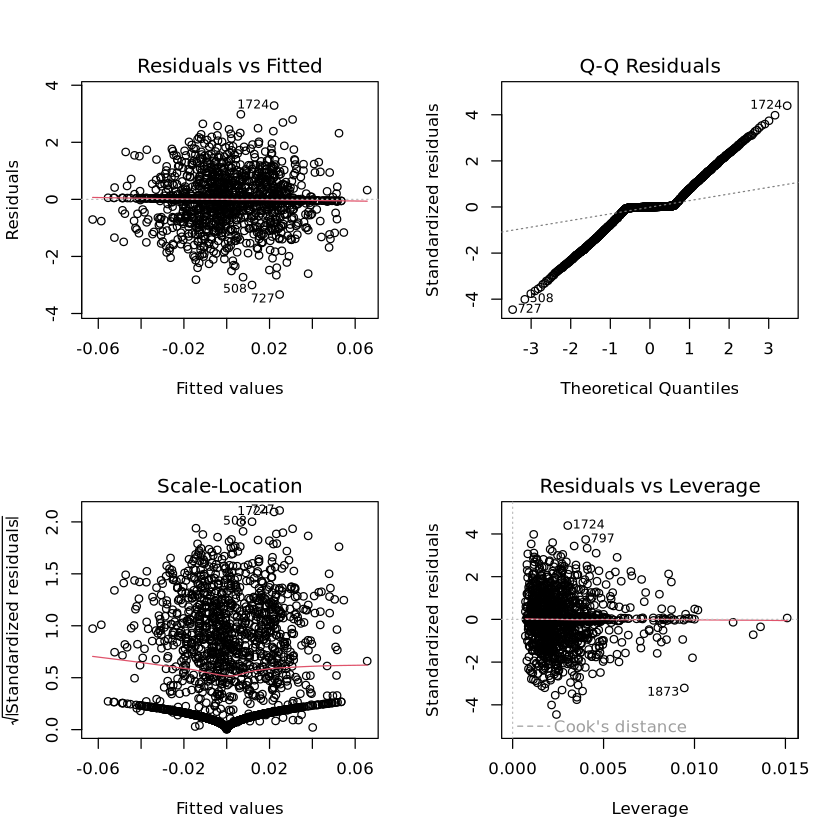

In [159]:
mod1_each_aa <- lm(M ~ allele_R + PC1 + PC2 + PC3, cdr3_hla_matrix)
par(mfrow=c(2,2))
plot(mod1_each_aa)

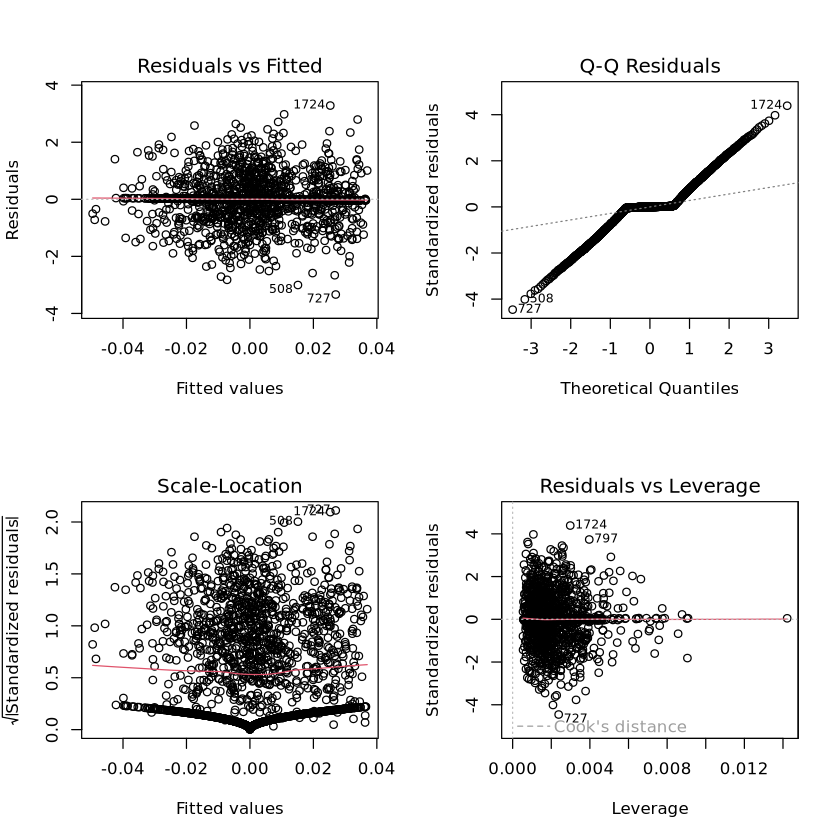

In [160]:
mod0_each_aa <- lm(M ~ PC1 + PC2 + PC3, cdr3_hla_matrix)
par(mfrow=c(2,2))
plot(mod0_each_aa)

# HLA site variation heatmaps


### first, heatmap: how many individuals are carriers of exact AA at exact HLA site

In [265]:
#a <- hla_variation %>% filter(gene == 'A') %>% select(patient_id, site, AA) %>% distinct()
drb1_carr <- hla_variation %>% filter(gene == 'DRB1') %>% 
    select(site, AA, n_carriers) %>% distinct() %>% group_by(site, AA)  %>%
    arrange(site) %>%
    mutate(site = paste0('S_', site))
drb1_carr
sites <- pull(drb1_matrix_df, site)

site  AA n_carriers
1   S_4   R  1156      
2   S_4   Q   309      
3   S_9   W   808      
4   S_9   E   958      
5   S_10  Q   954      
6   S_10  Y   794      
7   S_11  L   283      
8   S_11  P   369      
9   S_11  G   295      
10  S_11  V   286      
11  S_11  S   794      
12  S_12  K   961      
13  S_12  T   794      
14  S_13  F   311      
15  S_13  R   369      
16  S_13  Y   295      
17  S_13  S   711      
18  S_13  H   273      
19  S_13  G   141      
20  S_14  E  1158      
21  S_14  K   295      
22  S_16  H  1188      
23  S_16  Y   141      
24  S_25  R  1158      
25  S_25  Q   295      
26  S_26  L   353      
27  S_26  F  1125      
28  S_26  Y   224      
29  S_28  E   595      
30  S_28  D  1079      
⋮   ⋮     ⋮  ⋮         
82  S_86  G   968      
83  S_86  V   797      
84  S_96  E   283      
85  S_96  Q   382      
86  S_96  H   964      
87  S_96  Y   273      
88  S_98  K  1091      
89  S_98  E   537      
90  S_104 S  1091      
91  S_104 A   537      
92  S_112 H  1191      
93  S_112 Y    69      
94  S_120 S  1171      
95  S_120 N   286      
96  S_133 R  1147      
97  S_133 L   369      
98  S_140 A   818      
99  S_140 T   958      
100 S_142 V  1147      
101 S_142 M   369      
102 S_149 Q   961      
103 S_149 H   794      
104 S_180 V  1172      
105 S_180 L   273      
106 S_181 T  1151      
107 S_181 M   318      
108 S_189 R  1191      
109 S_189 S    80      
110 S_233 T   998      
111 S_233 R   750

In [268]:
drb1_carr_df <- drb1_carr %>% pivot_wider(names_from = 'AA', values_from = n_carriers, values_fill = 0)
drb1_carr_matrix <- drb1_carr_df[,-1] %>% as.matrix
rownames(drb1_carr_matrix) <- sites

In [269]:
drb1_carr_matrix

R    Q   W   E    Y    L   P   G   V    S    K    T    F    H    D    C  
S_4   1156 309   0    0    0   0   0   0    0    0    0    0    0    0    0   0
S_9      0   0 808  958    0   0   0   0    0    0    0    0    0    0    0   0
S_10     0 954   0    0  794   0   0   0    0    0    0    0    0    0    0   0
S_11     0   0   0    0    0 283 369 295  286  794    0    0    0    0    0   0
S_12     0   0   0    0    0   0   0   0    0    0  961  794    0    0    0   0
S_13   369   0   0    0  295   0   0 141    0  711    0    0  311  273    0   0
S_14     0   0   0 1158    0   0   0   0    0    0  295    0    0    0    0   0
S_16     0   0   0    0  141   0   0   0    0    0    0    0    0 1188    0   0
S_25  1158 295   0    0    0   0   0   0    0    0    0    0    0    0    0   0
S_26     0   0   0    0  224 353   0   0    0    0    0    0 1125    0    0   0
S_28     0   0   0  595    0   0   0   0    0    0    0    0    0    0 1079   0
S_30     0   0   0    0 1080 295   0   0    0    0    0    0    0   62    0 283
S_31     0   0   0    0    0   0   0   0    0    0    0    0 1180    0    0   0
S_32     0   0   0    0 1110   0   0   0    0    0    0    0    0  550    0   0
S_33     0   0   0    0    0   0   0   0    0    0    0    0    0  273    0   0
S_37     0   0   0    0  606  62   0   0    0  593    0    0  356    0    0   0
S_38     0   0   0    0    0  62   0   0 1191    0    0    0    0    0    0   0
S_47     0   0   0    0  871   0   0   0    0    0    0    0  883    0    0   0
S_57     0   0   0    0    0   0   0   0  357  122    0    0    0    0 1102   0
S_58     0   0   0  270    0   0   0   0    0    0    0    0    0    0    0   0
S_60     0   0   0    0 1127   0   0   0    0  357    0    0    0   70    0   0
S_67     0   0   0    0    0 712   0   0    0    0    0    0  364    0    0   0
S_70    98 863   0    0    0   0   0   0    0    0    0    0    0    0  868   0
S_71   923   0   0  274    0   0   0   0    0    0  397    0    0    0    0   0
S_73     0   0   0    0    0   0   0 478    0    0    0    0    0    0    0   0
S_74   209 295   0  149    0  82   0   0    0    0    0    0    0    0    0   0
S_77     0   0   0    0    0   0   0   0    0    0    0 1182    0    0    0   0
S_78     0   0   0    0 1156   0   0   0  309    0    0    0    0    0    0   0
S_85     0   0   0    0    0   0   0   0 1190    0    0    0    0    0    0   0
S_86     0   0   0    0    0   0   0 968  797    0    0    0    0    0    0   0
S_96     0 382   0  283  273   0   0   0    0    0    0    0    0  964    0   0
S_98     0   0   0  537    0   0   0   0    0    0 1091    0    0    0    0   0
S_104    0   0   0    0    0   0   0   0    0 1091    0    0    0    0    0   0
S_112    0   0   0    0   69   0   0   0    0    0    0    0    0 1191    0   0
S_120    0   0   0    0    0   0   0   0    0 1171    0    0    0    0    0   0
S_133 1147   0   0    0    0 369   0   0    0    0    0    0    0    0    0   0
S_140    0   0   0    0    0   0   0   0    0    0    0  958    0    0    0   0
S_142    0   0   0    0    0   0   0   0 1147    0    0    0    0    0    0   0
S_149    0 961   0    0    0   0   0   0    0    0    0    0    0  794    0   0
S_180    0   0   0    0    0 273   0   0 1172    0    0    0    0    0    0   0
S_181    0   0   0    0    0   0   0   0    0    0    0 1151    0    0    0   0
S_189 1191   0   0    0    0   0   0   0    0   80    0    0    0    0    0   0
S_233  750   0   0    0    0   0   0   0    0    0    0  998    0    0    0   0
      I   N    A    M  
S_4     0    0    0   0
S_9     0    0    0   0
S_10    0    0    0   0
S_11    0    0    0   0
S_12    0    0    0   0
S_13    0    0    0   0
S_14    0    0    0   0
S_16    0    0    0   0
S_25    0    0    0   0
S_26    0    0    0   0
S_28    0    0    0   0
S_30    0    0    0   0
S_31  297    0    0   0
S_32    0    0    0   0
S_33    0 1172    0   0
S_37    0  448    0   0
S_38    0    0    0   0
S_47    0    0    0   0
S_57    0    0   70   0
S_58  

In [271]:
melted_mat_carr

Var1  Var2 value
1   S_4   R    1156 
2   S_9   R       0 
3   S_10  R       0 
4   S_11  R       0 
5   S_12  R       0 
6   S_13  R     369 
7   S_14  R       0 
8   S_16  R       0 
9   S_25  R    1158 
10  S_26  R       0 
11  S_28  R       0 
12  S_30  R       0 
13  S_31  R       0 
14  S_32  R       0 
15  S_33  R       0 
16  S_37  R       0 
17  S_38  R       0 
18  S_47  R       0 
19  S_57  R       0 
20  S_58  R       0 
21  S_60  R       0 
22  S_67  R       0 
23  S_70  R      98 
24  S_71  R     923 
25  S_73  R       0 
26  S_74  R     209 
27  S_77  R       0 
28  S_78  R       0 
29  S_85  R       0 
30  S_86  R       0 
⋮   ⋮     ⋮    ⋮    
831 S_32  V       0 
832 S_33  V       0 
833 S_37  V       0 
834 S_38  V    1191 
835 S_47  V       0 
836 S_57  V     357 
837 S_58  V       0 
838 S_60  V       0 
839 S_67  V       0 
840 S_70  V       0 
841 S_71  V       0 
842 S_73  V       0 
843 S_74  V       0 
844 S_77  V       0 
845 S_78  V     309 
846 S_85  V    1190 
847 S_86  V     797 
848 S_96  V       0 
849 S_98  V       0 
850 S_104 V       0 
851 S_112 V       0 
852 S_120 V       0 
853 S_133 V       0 
854 S_140 V       0 
855 S_142 V    1147 
856 S_149 V       0 
857 S_180 V    1172 
858 S_181 V       0 
859 S_189 V       0 
860 S_233 V       0

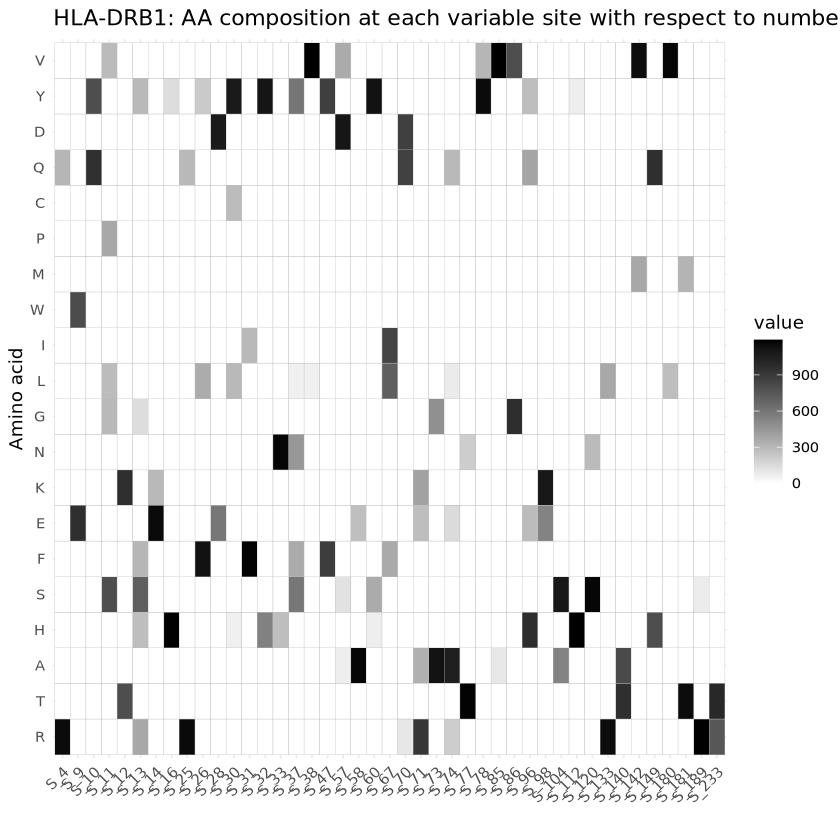

In [272]:
#row_dend <- as.dendrogram(hclust(dist(drb1_matrix)))
col_dend_carr <- as.dendrogram(hclust(dist(t(drb1_carr_matrix))))

# Order the matrix based on clustering
ordered_mat_carr <- drb1_carr_matrix[sites, order.dendrogram(col_dend_carr)]

# Melt the ordered matrix for ggplot2
melted_mat_carr <- melt(ordered_mat_carr)

# Create the heatmap with ggplot2
heatmap_plot_carr <- ggplot(melted_mat_carr, aes(x = Var1, y = Var2, fill = value)) +
  geom_tile(color = 'grey', linetype = 1) +
  scale_fill_gradient(low = "white", high = "black") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  labs(title = "HLA-DRB1: AA composition at each variable site with respect to number of carriers", x = " ", y = "Amino acid")
heatmap_plot_carr
ggsave('../plots/hla_DRB1_allele_AA_carriers.jpg',heatmap_plot_carr, width = 12, height = 4)

### Two plots on the same grid

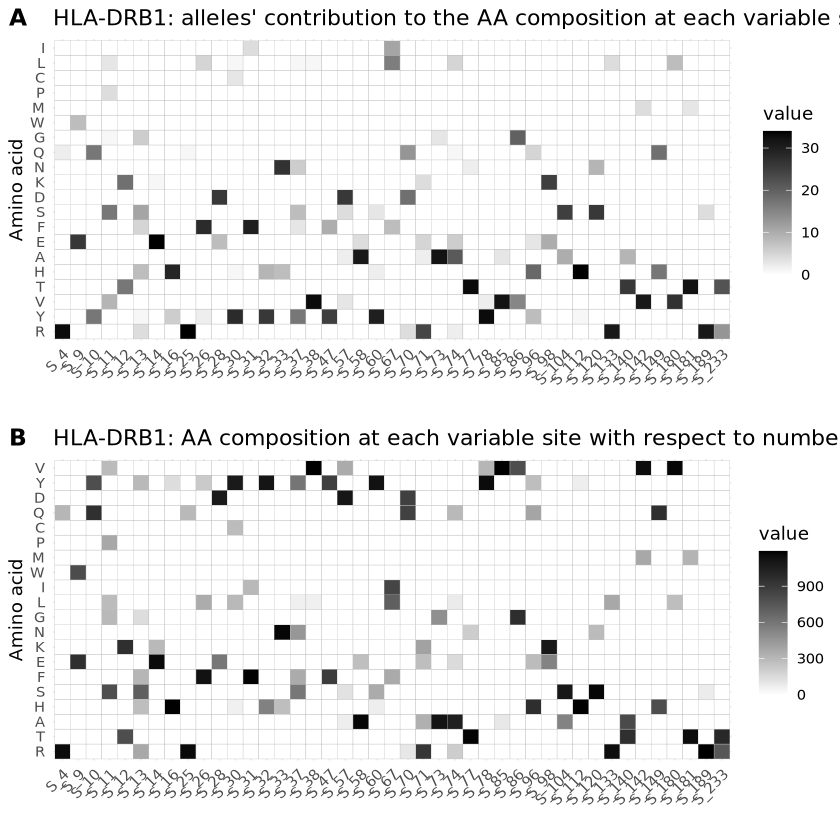

In [278]:
combined_plot <- plot_grid(heatmap_plot, heatmap_plot_carr, labels = "AUTO", align = "v", ncol = 1, rel_heights = c(1, 1))

# Display the combined plot
print(combined_plot)

In [281]:
two_plots <- heatmap_plot / heatmap_plot_carr + plot_layout(ncol = 1, heights = c(1, 1))
ggsave('../plots/hla_DRB1_two_plots_alleles_carriers.jpg',two_plots, width = 12, height = 10)

### Experiment with Sankey plot showing allele contribution to the site of interest

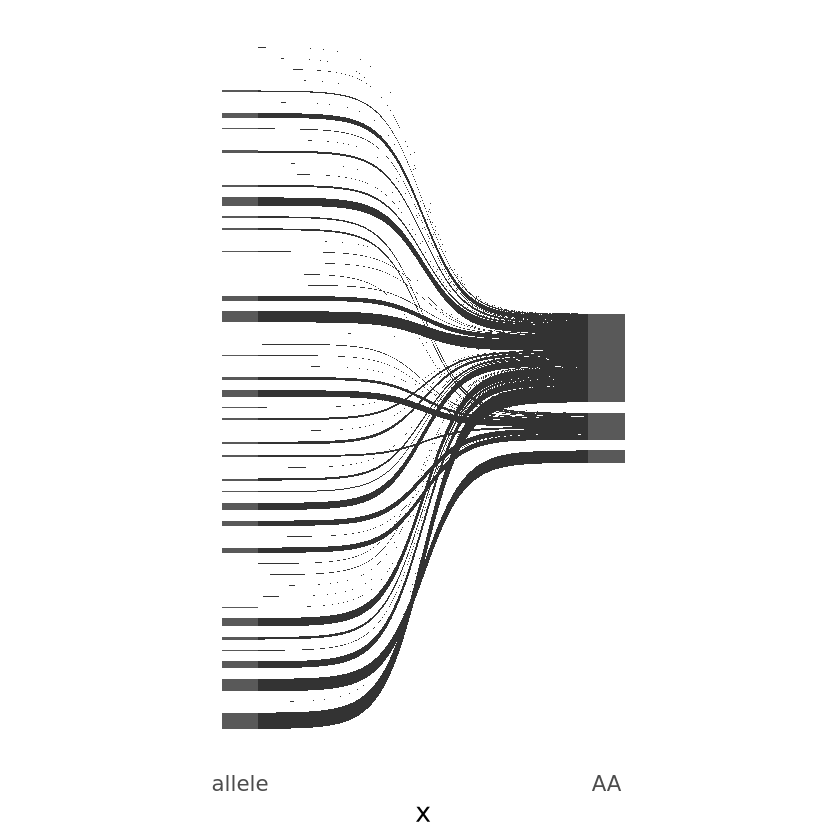

In [198]:
b <- hla_variation %>% filter(gene == 'B', site %in% c(9)) %>% select(patient_id, allele, AA) %>% distinct()
b_long <- b %>% make_long(allele, AA)

ggplot(b_long, aes(x = x, 
               next_x = next_x, 
               node = node, 
               next_node = next_node)) +
               #fill = factor(node))) +
  geom_sankey() +
  theme_sankey(base_size = 16)

In [4]:
df <- data.frame(
  Category1 = as.factor(sample(letters[1:3], 10, replace = TRUE)),
  Category2 = as.factor(sample(letters[4:6], 10, replace = TRUE)),
  Category3 = as.factor(sample(letters[7:9], 10, replace = TRUE)),
  Category4 = as.factor(sample(letters[10:12], 10, replace = TRUE))
)

# Display the data frame
print(df)

# Create a parallel coordinates plot
p <- ggparcoord(df, columns = 1:4, groupColumn = 1, scale = "uniminmax") +
  theme_minimal() +
  labs(title = "Parallel Coordinates Plot for Categorical Data",
       x = "Categories",
       y = "Values")

# Display the plot
print(p)

   Category1 Category2 Category3 Category4
1          a         d         i         j
2          c         e         i         l
3          a         d         h         j
4          c         f         g         k
5          a         f         g         j
6          a         e         i         l
7          a         e         i         l
8          a         f         g         k
9          a         e         g         j
10         a         f         h         k


ERROR: [1m[33mError[39m in `pivot_longer()`:[22m
[33m![39m Can't combine `Category1` <factor<d46a4>> and `Category2` <double>.


### second, heatmap: how many alleles contribute to the same AA at each site

In [222]:
drb1 <- hla_variation %>% filter(gene == 'DRB1') %>% 
    select(allele, site, AA) %>% group_by(site, AA)  %>% 
    summarise(num_alleles = length(unique(allele)), .groups = 'keep') %>%
    arrange(site & desc(num_alleles)) #%>% filter(site == 4, AA == 'R')%>% distinct()
drb1

site AA num_alleles
1    4   Q   2         
2    4   R  33         
3    9   E  26         
4    9   W   8         
5   10   Q  17         
6   10   Y  17         
7   11   G   1         
8   11   L   3         
9   11   P   4         
10  11   S  17         
11  11   V   9         
12  12   K  18         
13  12   T  17         
14  13   F   5         
15  13   G   6         
16  13   H   8         
17  13   R   4         
18  13   S  11         
19  13   Y   1         
20  14   E  34         
21  14   K   1         
22  16   H  29         
23  16   Y   6         
24  25   Q   1         
25  25   R  34         
26  26   F  28         
27  26   L   5         
28  26   Y   2         
29  28   D  26         
30  28   E   8         
⋮   ⋮    ⋮  ⋮          
82   86  G  20         
83   86  V  15         
84   96  E   3         
85   96  H  19         
86   96  Q   5         
87   96  Y   8         
88   98  E  10         
89   98  K  25         
90  104  A  10         
91  104  S  25         
92  112  H  34         
93  112  Y   1         
94  120  N   9         
95  120  S  26         
96  133  L   4         
97  133  R  31         
98  140  A   9         
99  140  T  26         
100 142  M   4         
101 142  V  31         
102 149  H  17         
103 149  Q  18         
104 180  L   8         
105 180  V  27         
106 181  M   3         
107 181  T  32         
108 189  R  31         
109 189  S   4         
110 233  R  13         
111 233  T  22

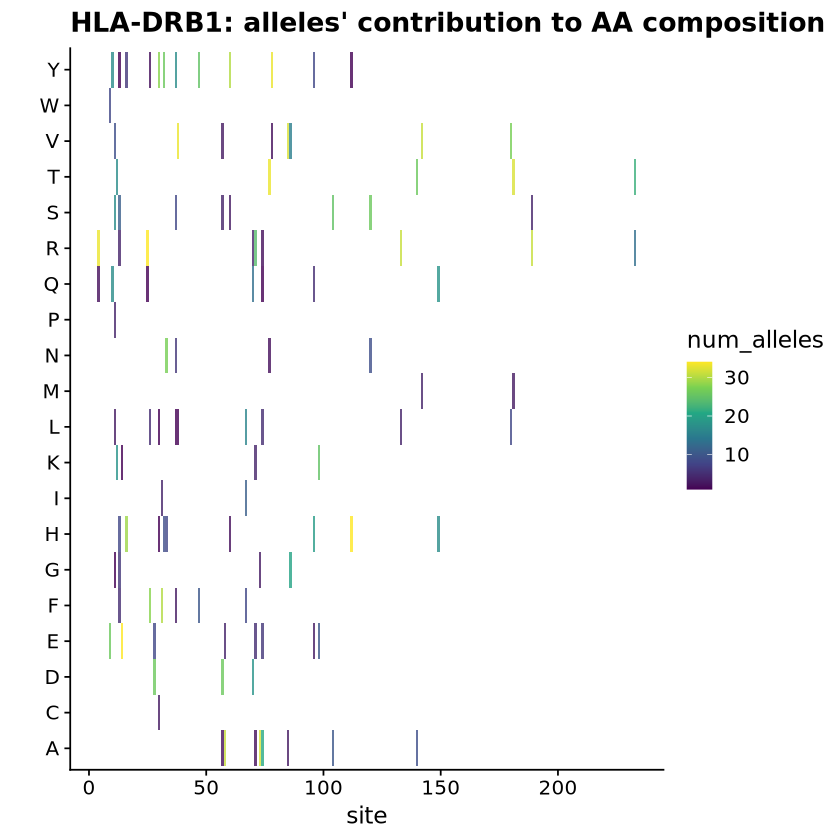

In [223]:
pl <- ggplot(data = drb1, aes(x = site, y = AA, fill = num_alleles, size = num_alleles)) + 
    geom_tile(alpha=0.8, size=1.3) +
    labs(title = "HLA-DRB1: alleles' contribution to AA composition", y = '') + 
    scale_fill_viridis_c() +
    theme_cowplot() 

pl
               
ggsave('../plots/hla_DRB1_allele_AA_contribution_flipped.jpg',pl, width = 12, height = 4)

In [255]:
drb1_matrix_df <- drb1 %>% pivot_wider(names_from = 'AA', values_from = num_alleles, values_fill = 0) %>% mutate(site = paste0('S_', site))
sites <- pull(drb1_matrix_df, site)

In [256]:
sites

[1] "S_4"   "S_9"   "S_10"  "S_11"  "S_12"  "S_13"  "S_14"  "S_16"  "S_25" 
[10] "S_26"  "S_28"  "S_30"  "S_31"  "S_32"  "S_33"  "S_37"  "S_38"  "S_47" 
[19] "S_57"  "S_58"  "S_60"  "S_67"  "S_70"  "S_71"  "S_73"  "S_74"  "S_77" 
[28] "S_78"  "S_85"  "S_86"  "S_96"  "S_98"  "S_104" "S_112" "S_120" "S_133"
[37] "S_140" "S_142" "S_149" "S_180" "S_181" "S_189" "S_233"

In [257]:
drb1_matrix <- drb1_matrix_df[,-1] %>% as.matrix
rownames(drb1_matrix) <- sites
drb1_matrix

Q  R  E  W Y  G  L  P S  V  K  T  F  H  D  C I  N  A  M
S_4    2 33  0 0  0  0  0 0  0  0  0  0  0  0  0 0  0  0  0 0
S_9    0  0 26 8  0  0  0 0  0  0  0  0  0  0  0 0  0  0  0 0
S_10  17  0  0 0 17  0  0 0  0  0  0  0  0  0  0 0  0  0  0 0
S_11   0  0  0 0  0  1  3 4 17  9  0  0  0  0  0 0  0  0  0 0
S_12   0  0  0 0  0  0  0 0  0  0 18 17  0  0  0 0  0  0  0 0
S_13   0  4  0 0  1  6  0 0 11  0  0  0  5  8  0 0  0  0  0 0
S_14   0  0 34 0  0  0  0 0  0  0  1  0  0  0  0 0  0  0  0 0
S_16   0  0  0 0  6  0  0 0  0  0  0  0  0 29  0 0  0  0  0 0
S_25   1 34  0 0  0  0  0 0  0  0  0  0  0  0  0 0  0  0  0 0
S_26   0  0  0 0  2  0  5 0  0  0  0  0 28  0  0 0  0  0  0 0
S_28   0  0  8 0  0  0  0 0  0  0  0  0  0  0 26 0  0  0  0 0
S_30   0  0  0 0 28  0  1 0  0  0  0  0  0  1  0 3  0  0  0 0
S_31   0  0  0 0  0  0  0 0  0  0  0  0 30  0  0 0  4  0  0 0
S_32   0  0  0 0 26  0  0 0  0  0  0  0  0  9  0 0  0  0  0 0
S_33   0  0  0 0  0  0  0 0  0  0  0  0  0  8  0 0  0 27  0 0
S_37   0  0  0 0 17  0  1 0  8  0  0  0  3  0  0 0  0  6  0 0
S_38   0  0  0 0  0  0  1 0  0 33  0  0  0  0  0 0  0  0  0 0
S_47   0  0  0 0 25  0  0 0  0  0  0  0 10  0  0 0  0  0  0 0
S_57   0  0  0 0  0  0  0 0  4  3  0  0  0  0 26 0  0  0  2 0
S_58   0  0  4 0  0  0  0 0  0  0  0  0  0  0  0 0  0  0 31 0
S_60   0  0  0 0 30  0  0 0  3  0  0  0  0  2  0 0  0  0  0 0
S_67   0  0  0 0  0  0 16 0  0  0  0  0  8  0  0 0 11  0  0 0
S_70  13  4  0 0  0  0  0 0  0  0  0  0  0  0 18 0  0  0  0 0
S_71   0 24  5 0  0  0  0 0  0  0  4  0  0  0  0 0  0  0  2 0
S_73   0  0  0 0  0  3  0 0  0  0  0  0  0  0  0 0  0  0 32 0
S_74   1  2  6 0  0  0  5 0  0  0  0  0  0  0  0 0  0  0 21 0
S_77   0  0  0 0  0  0  0 0  0  0  0 33  0  0  0 0  0  2  0 0
S_78   0  0  0 0 33  0  0 0  0  2  0  0  0  0  0 0  0  0  0 0
S_85   0  0  0 0  0  0  0 0  0 32  0  0  0  0  0 0  0  0  3 0
S_86   0  0  0 0  0 20  0 0  0 15  0  0  0  0  0 0  0  0  0 0
S_96   5  0  3 0  8  0  0 0  0  0  0  0  0 19  0 0  0  0  0 0
S_98   0  0 10 0  0  0  0 0  0  0 25  0  0  0  0 0  0  0  0 0
S_104  0  0  0 0  0  0  0 0 25  0  0  0  0  0  0 0  0  0 10 0
S_112  0  0  0 0  1  0  0 0  0  0  0  0  0 34  0 0  0  0  0 0
S_120  0  0  0 0  0  0  0 0 26  0  0  0  0  0  0 0  0  9  0 0
S_133  0 31  0 0  0  0  4 0  0  0  0  0  0  0  0 0  0  0  0 0
S_140  0  0  0 0  0  0  0 0  0  0  0 26  0  0  0 0  0  0  9 0
S_142  0  0  0 0  0  0  0 0  0 31  0  0  0  0  0 0  0  0  0 4
S_149 18  0  0 0  0  0  0 0  0  0  0  0  0 17  0 0  0  0  0 0
S_180  0  0  0 0  0  0  8 0  0 27  0  0  0  0  0 0  0  0  0 0
S_181  0  0  0 0  0  0  0 0  0  0  0 32  0  0  0 0  0  0  0 3
S_189  0 31  0 0  0  0  0 0  4  0  0  0  0  0  0 0  0  0  0 0
S_233  0 13  0 0  0  0  0 0  0  0  0 22  0  0  0 0  0  0  0 0

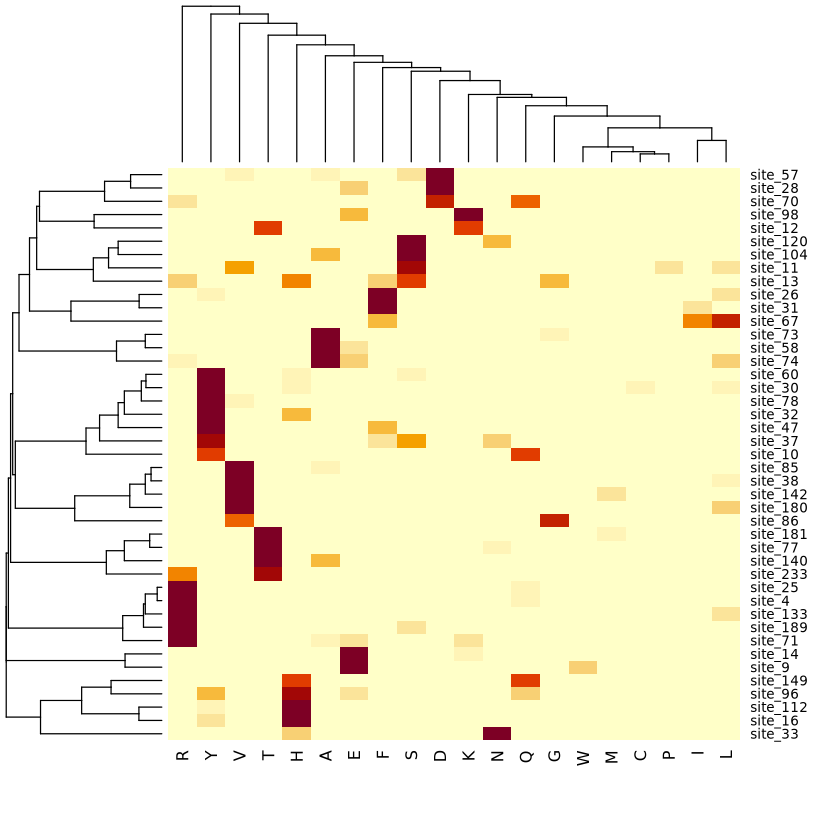

In [236]:
heatmap(drb1_matrix)

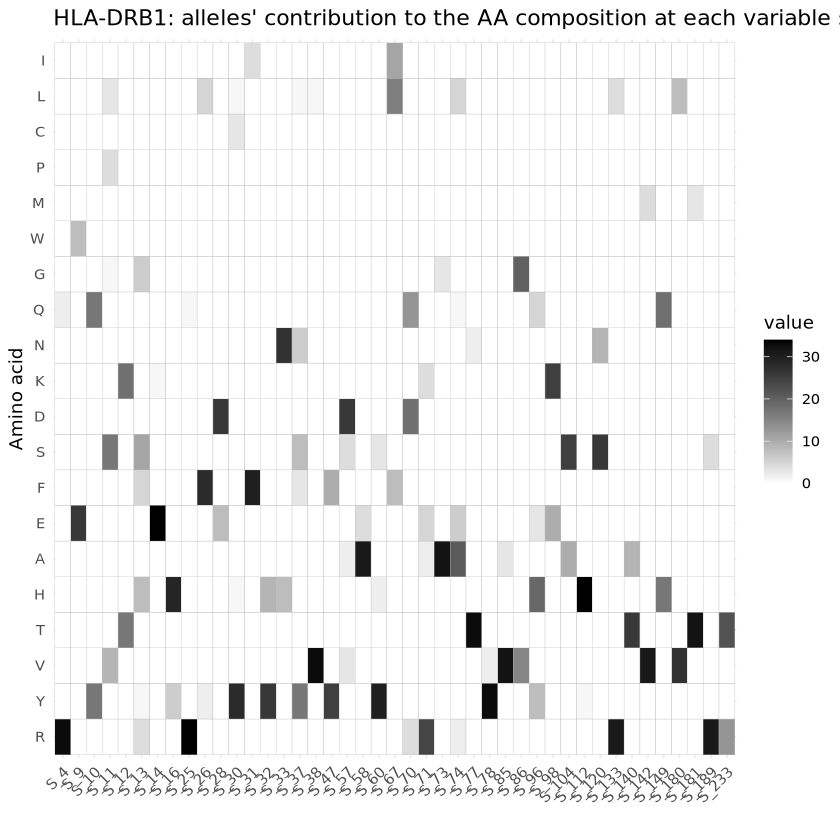

In [258]:
#row_dend <- as.dendrogram(hclust(dist(drb1_matrix)))
col_dend <- as.dendrogram(hclust(dist(t(drb1_matrix))))

# Order the matrix based on clustering
ordered_mat <- drb1_matrix[sites, order.dendrogram(col_dend)]

# Melt the ordered matrix for ggplot2
melted_mat <- melt(ordered_mat)

# Create the heatmap with ggplot2
heatmap_plot <- ggplot(melted_mat, aes(x = Var1, y = Var2, fill = value)) +
  geom_tile(color = 'grey', linetype = 1) +
  scale_fill_gradient(low = "white", high = "black") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  labs(title = "HLA-DRB1: alleles' contribution to the AA composition at each variable site", x = " ", y = "Amino acid")
heatmap_plot
ggsave('../plots/hla_DRB1_allele_AA_contribution_clustered.jpg',heatmap_plot, width = 12, height = 4)

### Correlation for alleles at each HLA sites 

In [74]:
hla_matrix <- read_tsv('../hla_matrices_for_power/400/DRB1_13_size_400_rep_1.tsv')
hla_matrix_2 <- read_tsv('../hla_matrices_for_power/400/DRB1_10_size_400_rep_1.tsv')

Rows: 400 Columns: 8
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): G_S
dbl (7): patient_id, allele_F, allele_Y, allele_H, allele_S, allele_R, allele_G

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 400 Columns: 4
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): G_S
dbl (3): patient_id, allele_Q, allele_Y

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify 

In [75]:
cor(hla_matrix %>% select(contains('allele')))


allele_F    allele_Y    allele_H    allele_S   allele_R   allele_G   
allele_F  1.00000000 -0.12759832 -0.15756347 -0.3081491 -0.1906704 -0.04964951
allele_Y -0.12759832  1.00000000 -0.14365342 -0.3200320 -0.2590874 -0.02820171
allele_H -0.15756347 -0.14365342  1.00000000 -0.3027727 -0.1559448 -0.09653711
allele_S -0.30814911 -0.32003203 -0.30277270  1.0000000 -0.3010952 -0.19676060
allele_R -0.19067043 -0.25908736 -0.15594484 -0.3010952  1.0000000 -0.19380870
allele_G -0.04964951 -0.02820171 -0.09653711 -0.1967606 -0.1938087  1.00000000

In [37]:
hla_variation %>% filter(gene == 'A')  %>% filter(patient_id %in% c(0)) %>% filter(site == 9)

patient_id gene allele  homo_hetero site AA n_carriers variat n_variat
1 0          A    A*01:01 1           9    F  1066       NA     4       
2 0          A    A*02:01 1           9    F  1066       NA     4

In [43]:
for (g in unique(pull(hla_variation, gene))) {
    hla_sites_map <- hla_variation %>% filter(gene == g) %>% select(patient_id, homo_hetero, site, AA) %>% arrange(site) %>%
        pivot_wider(names_from = c(site, AA), values_from = homo_hetero, values_fn = sum, values_fill = 0)
    #write_tsv(hla_sites_map, paste0('../hla/hla_',g,'_sites_map.tsv'))
    cor_mat <- cor(hla_sites_map %>% select(-patient_id))
    p heatmap(cor_mat)
}
    

In [49]:
g

[1] "DRB1"

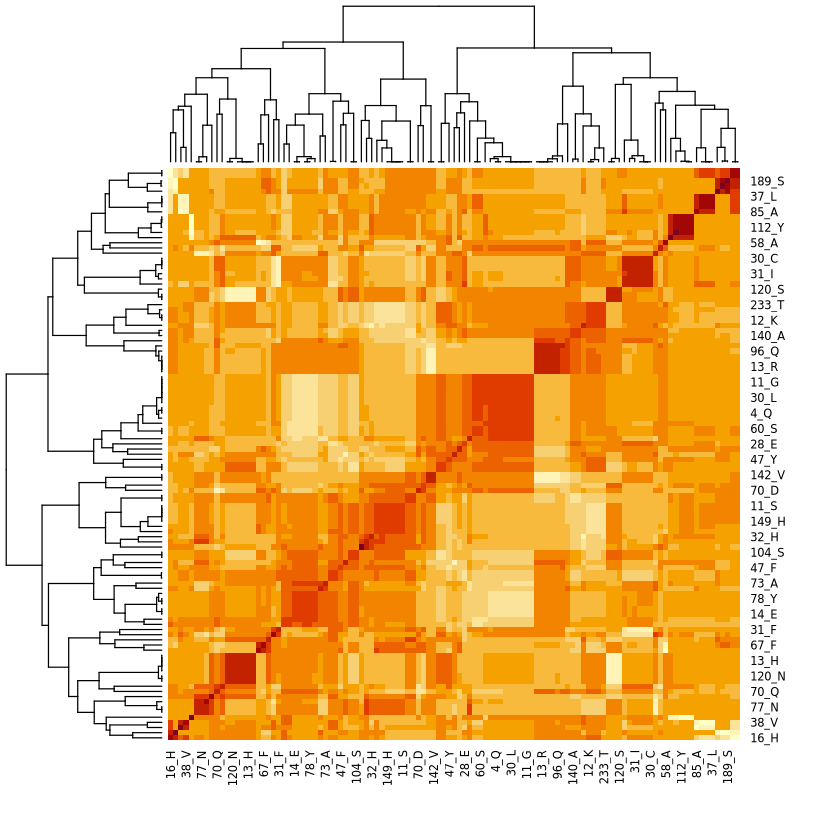

In [48]:
melted_hla <- melt(cor_mat)

In [53]:
melted_hla

Var1  Var2  value      
1     4_R   4_R    1.00000000
2     4_Q   4_R   -1.00000000
3     9_W   4_R   -0.42283504
4     9_E   4_R    0.45371022
5     10_Q  4_R   -0.35649150
6     10_Y  4_R    0.35975910
7     11_L  4_R    0.16206374
8     11_P  4_R    0.22433487
9     11_G  4_R   -0.97482689
10    11_V  4_R    0.13279692
11    11_S  4_R    0.35975910
12    12_K  4_R   -0.35975910
13    12_T  4_R    0.35975910
14    13_F  4_R    0.10627184
15    13_R  4_R    0.22433487
16    13_Y  4_R   -0.97482689
17    13_S  4_R    0.34082378
18    13_H  4_R    0.13835065
19    13_G  4_R    0.06258512
20    14_E  4_R    0.97482689
21    14_K  4_R   -0.97482689
22    16_H  4_R   -0.06258512
23    16_Y  4_R    0.06258512
24    25_R  4_R    0.97482689
25    25_Q  4_R   -0.97482689
26    26_L  4_R    0.15880075
27    26_F  4_R   -0.19403172
28    26_Y  4_R    0.09236458
29    28_E  4_R   -0.63826966
30    28_D  4_R    0.66586047
⋮     ⋮     ⋮     ⋮          
12292 86_G  233_R -0.2738699 
12293 86_V  233_R  0.2738699 
12294 96_E  233_R -0.3012225 
12295 96_Q  233_R -0.3629946 
12296 96_H  233_R  0.6831715 
12297 96_Y  233_R -0.3227382 
12298 98_K  233_R  0.5099744 
12299 98_E  233_R -0.5099744 
12300 104_S 233_R  0.5099744 
12301 104_A 233_R -0.5099744 
12302 112_H 233_R -0.2036487 
12303 112_Y 233_R  0.2036487 
12304 120_S 233_R  0.3276316 
12305 120_N 233_R -0.3276316 
12306 133_R 233_R  0.3571523 
12307 133_L 233_R -0.3571523 
12308 140_A 233_R -0.7247449 
12309 140_T 233_R  0.7247449 
12310 142_V 233_R  0.3571523 
12311 142_M 233_R -0.3571523 
12312 149_Q 233_R -0.9350262 
12313 149_H 233_R  0.9350262 
12314 180_V 233_R  0.3227382 
12315 180_L 233_R -0.3227382 
12316 181_T 233_R  0.3475906 
12317 181_M 233_R -0.3475906 
12318 189_R 233_R  0.1322656 
12319 189_S 233_R -0.1322656 
12320 233_T 233_R -1.0000000 
12321 233_R 233_R  1.0000000

In [161]:
a_df <- as.data.frame(a_matrix) 
a_df$sites <- sites
a_df
length(unique(a$AA))

F    R    K    G    Q   E    N    M    H    T    D    A    L    I    Y   
1  1066    0    0    0   0    0    0    0    0  127    0    0    0    0  340
2     0 1192    0    0   0    0    0    0    0    0    0    0    0    0    0
3     0 1161  345    0   0    0    0    0    0    0    0    0    0    0    0
4     0  107    0 1190   0    0    0    0    0    0    0    0    0    0    0
5     0  235    0  637 877  212    0    0    0    0    0    0   51    0    0
6     0    0    0    0  51 1172  235    0    0    0    0    0    0    0    0
7     0 1182    0  212   0    0    0    0    0    0    0    0    0    0    0
8     0    0  794    0   0    0 1016    0    0    0    0    0    0    0    0
9     0    0    0    0   0    0    0  345    0    0    0    0    0    0    0
10    0    0    0    0 618    0    0    0 1088    0    0    0    0    0    0
11    0    0    0    0   0    0    0    0    0 1190    0    0    0   77    0
12    0    0    0    0   0    0    0    0  636    0 1081    0    0    0    0
13    0    0    0    0   0  342    0    0    0    0    0  455    0    0    0
14    0    0    0    0   0    0  620    0    0    0 1023    0    0    0    0
15    0  336    0 1158   0    0    0    0    0    0    0    0    0    0    0
16    0    0    0    0   0    0    0    0    0 1158    0    0    0  336    0
17    0    0    0    0   0    0    0    0    0    0    0  336 1158    0    0
18    0 1158    0    0   0    0    0    0    0    0    0    0  336    0    0
19    0  336    0 1158   0    0    0    0    0    0    0    0    0    0    0
20    0    0    0    0   0    0    0    0    0    0  541 1097    0    0    0
21    0    0    0    0   0    0    0    0    0    0    0    0  231 1013    0
22    0  744    0    0   0    0    0  457    0    0    0    0    0  768    0
23  212    0    0    0   0    0    0    0    0    0    0    0    0    0 1181
24    0    0    0    0   0    0    0    0    0    0    0    0    0    0    0
25    0    0    0 1079   0    0    0    0    0    0    0    0    0    0    0
26 1190    0    0    0   0    0    0    0    0    0    0    0  100    0    0
27    0  801    0    0 294   55    0    0  808    0    0    0    0    0    0
28    0    0    0    0   0    0    0    0   55    0  981    0    0    0  808
29    0    0  843    0   0    0  977    0    0    0    0    0    0    0    0
30    0    0    0    0   0    0    0    0    0  694    0    0    0 1050    0
31    0    0 1147    0 414    0    0    0    0    0    0    0    0    0    0
32    0 1050    0    0   0    0    0    0  694    0    0    0    0    0    0
33    0    0    0    0   0    0    0    0    0  135    0 1185    0    0    0
34    0    0    0    0   0    0    0    0    0    0    0 1161    0    0    0
35    0  303    0    0   0    0    0    0 1177    0    0    0    0    0    0
36    0    0    0    0   0  480    0    0    0    0    0  440    0    0    0
37    0  345    0    0 293    0    0    0    0    0    0    0  997    0    0
38    0    0    0    0   0    0    0    0    0    0    0 1161    0    0    0
39    0    0    0    0   0 1155    0    0    0    0  367    0    0    0    0
40    0  540    0    0   0    0    0    0    0 1098    0    0    0    0    0
41    0    0    0    0   0 1108    0    0    0    0  514    0    0    0    0
42    0    0    0  514   0    0    0    0    0    0    0    0    0    0    0
43    0    0    0    0   0    0    0    0    0    0    0  857    0    0    0
44    0    0    0    0   0    0    0    0    0    0    0  897    0    0    0
45    0    0    0    0   0    0    0    0    0    0    0    0    0  882    0
46    0    0    0  882   0    0    0    0    0    0    0    0    0    0    0
47    0    0    0    0   0    0    0    0    0    0    0 1190    0    0    0
48    0    0    0    0   0    0    0    0    0    0    0 1162    0    0    0
49    0    0    0    0 897  882    0    0    0    0    0    0    0    0    0
50    0    0    0    0   0    0    0    0    0    0    0    0  768    0    0
51    0    0    0    0   0    0    0    0    0    0    0    0    0 1182    0

[1] 19

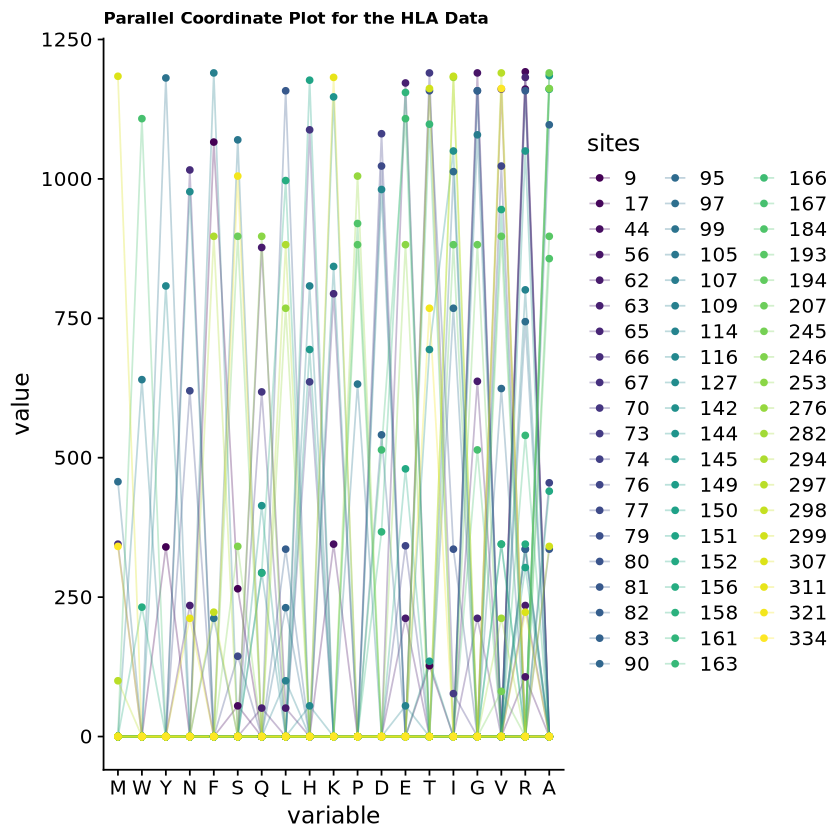

In [162]:
# Plot
ggparcoord(a_df,
    columns = 1:19, groupColumn = 20, order = "anyClass",
    scale = 'globalminmax',
    showPoints = TRUE, 
    title = "Parallel Coordinate Plot for the HLA Data",
    alphaLines = 0.3
    ) + 
  scale_color_viridis_d() +
  theme_cowplot()+
  theme(
    plot.title = element_text(size=10)
  )

Warning message in compute_group(...):
“'StatBump' needs at least two observations per group”
Warning message in compute_group(...):
“'StatBump' needs at least two observations per group”
Warning message in compute_group(...):
“'StatBump' needs at least two observations per group”
Warning message in compute_group(...):
“'StatBump' needs at least two observations per group”
Warning message in compute_group(...):
“'StatBump' needs at least two observations per group”
Warning message in compute_group(...):
“'StatBump' needs at least two observations per group”
Warning message in compute_group(...):
“'StatBump' needs at least two observations per group”
Warning message in compute_group(...):
“'StatBump' needs at least two observations per group”
Warning message in compute_group(...):
“'StatBump' needs at least two observations per group”
Warning message in compute_group(...):
“'StatBump' needs at least two observations per group”
Warning message in compute_group(...):
“'StatBump' needs at 

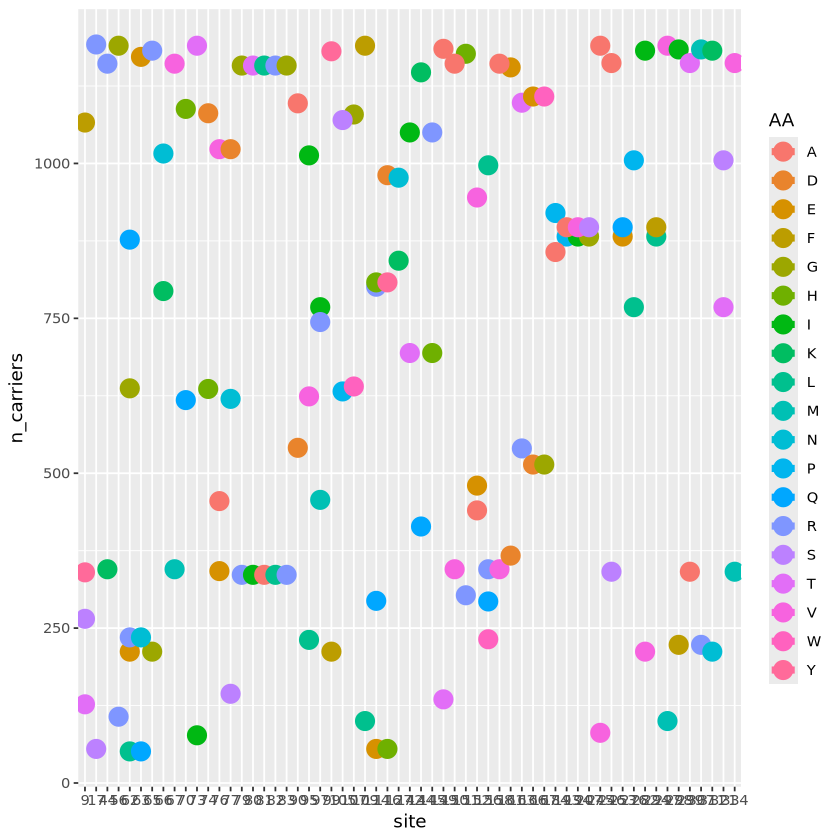

In [134]:
ggplot(a, aes(x = site, y = n_carriers, color = AA)) +
  geom_bump(size=2) +
  geom_point(size=5)

In [59]:
a$site <- factor(a$site, levels = sites)

In [116]:
a_matrix <- a %>% pivot_wider(names_from = 'AA', values_from = n_carriers)
sites <- a_matrix$site
a_matrix <- a_matrix[,-1]
rownames(a_matrix) <- paste0(sites)

a_matrix[is.na(a_matrix)] <- 0
a_matrix

Warning message:
“Setting row names on a tibble is deprecated.”


F    R    K    G    Q   E    N    M    H    T    D    A    L    I    Y   
1  1066    0    0    0   0    0    0    0    0  127    0    0    0    0  340
2     0 1192    0    0   0    0    0    0    0    0    0    0    0    0    0
3     0 1161  345    0   0    0    0    0    0    0    0    0    0    0    0
4     0  107    0 1190   0    0    0    0    0    0    0    0    0    0    0
5     0  235    0  637 877  212    0    0    0    0    0    0   51    0    0
6     0    0    0    0  51 1172  235    0    0    0    0    0    0    0    0
7     0 1182    0  212   0    0    0    0    0    0    0    0    0    0    0
8     0    0  794    0   0    0 1016    0    0    0    0    0    0    0    0
9     0    0    0    0   0    0    0  345    0    0    0    0    0    0    0
10    0    0    0    0 618    0    0    0 1088    0    0    0    0    0    0
11    0    0    0    0   0    0    0    0    0 1190    0    0    0   77    0
12    0    0    0    0   0    0    0    0  636    0 1081    0    0    0    0
13    0    0    0    0   0  342    0    0    0    0    0  455    0    0    0
14    0    0    0    0   0    0  620    0    0    0 1023    0    0    0    0
15    0  336    0 1158   0    0    0    0    0    0    0    0    0    0    0
16    0    0    0    0   0    0    0    0    0 1158    0    0    0  336    0
17    0    0    0    0   0    0    0    0    0    0    0  336 1158    0    0
18    0 1158    0    0   0    0    0    0    0    0    0    0  336    0    0
19    0  336    0 1158   0    0    0    0    0    0    0    0    0    0    0
20    0    0    0    0   0    0    0    0    0    0  541 1097    0    0    0
21    0    0    0    0   0    0    0    0    0    0    0    0  231 1013    0
22    0  744    0    0   0    0    0  457    0    0    0    0    0  768    0
23  212    0    0    0   0    0    0    0    0    0    0    0    0    0 1181
24    0    0    0    0   0    0    0    0    0    0    0    0    0    0    0
25    0    0    0 1079   0    0    0    0    0    0    0    0    0    0    0
26 1190    0    0    0   0    0    0    0    0    0    0    0  100    0    0
27    0  801    0    0 294   55    0    0  808    0    0    0    0    0    0
28    0    0    0    0   0    0    0    0   55    0  981    0    0    0  808
29    0    0  843    0   0    0  977    0    0    0    0    0    0    0    0
30    0    0    0    0   0    0    0    0    0  694    0    0    0 1050    0
31    0    0 1147    0 414    0    0    0    0    0    0    0    0    0    0
32    0 1050    0    0   0    0    0    0  694    0    0    0    0    0    0
33    0    0    0    0   0    0    0    0    0  135    0 1185    0    0    0
34    0    0    0    0   0    0    0    0    0    0    0 1161    0    0    0
35    0  303    0    0   0    0    0    0 1177    0    0    0    0    0    0
36    0    0    0    0   0  480    0    0    0    0    0  440    0    0    0
37    0  345    0    0 293    0    0    0    0    0    0    0  997    0    0
38    0    0    0    0   0    0    0    0    0    0    0 1161    0    0    0
39    0    0    0    0   0 1155    0    0    0    0  367    0    0    0    0
40    0  540    0    0   0    0    0    0    0 1098    0    0    0    0    0
41    0    0    0    0   0 1108    0    0    0    0  514    0    0    0    0
42    0    0    0  514   0    0    0    0    0    0    0    0    0    0    0
43    0    0    0    0   0    0    0    0    0    0    0  857    0    0    0
44    0    0    0    0   0    0    0    0    0    0    0  897    0    0    0
45    0    0    0    0   0    0    0    0    0    0    0    0    0  882    0
46    0    0    0  882   0    0    0    0    0    0    0    0    0    0    0
47    0    0    0    0   0    0    0    0    0    0    0 1190    0    0    0
48    0    0    0    0   0    0    0    0    0    0    0 1162    0    0    0
49    0    0    0    0 897  882    0    0    0    0    0    0    0    0    0
50    0    0    0    0   0    0    0    0    0    0    0    0  768    0    0
51    0    0    0    0   0    0    0    0    0    0    0    0    0 1182    0

In [114]:
sites <- levels(unique(a$site))

In [63]:
#row_dend <- as.dendrogram(hclust(dist(mat)))
col_dend <- as.dendrogram(hclust(dist(t(cor_mat))))

# Order the matrix based on clustering
ordered_mat <- cor_mat[, order.dendrogram(col_dend)]
# Convert the matrix to long format for ggplot2
melted_mat <- melt(ordered_mat)

In [64]:
melted_mat

Var1  Var2  value       
1     4_R   47_Y  -0.44182395 
2     4_Q   47_Y   0.44182395 
3     9_W   47_Y   0.26445159 
4     9_E   47_Y  -0.27782725 
5     10_Q  47_Y   0.53191511 
6     10_Y  47_Y  -0.54674420 
7     11_L  47_Y   0.35921429 
8     11_P  47_Y  -0.35234488 
9     11_G  47_Y   0.43107368 
10    11_V  47_Y   0.40765013 
11    11_S  47_Y  -0.54674420 
12    12_K  47_Y   0.54674420 
13    12_T  47_Y  -0.54674420 
14    13_F  47_Y   0.38649843 
15    13_R  47_Y  -0.35234488 
16    13_Y  47_Y   0.43107368 
17    13_S  47_Y  -0.59523827 
18    13_H  47_Y   0.39450444 
19    13_G  47_Y   0.06321921 
20    14_E  47_Y  -0.43107368 
21    14_K  47_Y   0.43107368 
22    16_H  47_Y  -0.06321921 
23    16_Y  47_Y   0.06321921 
24    25_R  47_Y  -0.43107368 
25    25_Q  47_Y   0.43107368 
26    26_L  47_Y   0.28288220 
27    26_F  47_Y  -0.02699453 
28    26_Y  47_Y  -0.29458510 
29    28_E  47_Y   0.55642788 
30    28_D  47_Y  -0.56592190 
⋮     ⋮     ⋮     ⋮           
12292 86_G  189_R -0.150859827
12293 86_V  189_R  0.150859827
12294 96_E  189_R  0.065201927
12295 96_Q  189_R  0.125135378
12296 96_H  189_R -0.188532479
12297 96_Y  189_R  0.076717104
12298 98_K  189_R -0.098467041
12299 98_E  189_R  0.098467041
12300 104_S 189_R -0.098467041
12301 104_A 189_R  0.098467041
12302 112_H 189_R  0.003354147
12303 112_Y 189_R -0.003354147
12304 120_S 189_R -0.082011757
12305 120_N 189_R  0.082011757
12306 133_R 189_R -0.120498312
12307 133_L 189_R  0.120498312
12308 140_A 189_R  0.175080740
12309 140_T 189_R -0.175080740
12310 142_V 189_R -0.120498312
12311 142_M 189_R  0.120498312
12312 149_Q 189_R  0.227791618
12313 149_H 189_R -0.227791618
12314 180_V 189_R -0.076717104
12315 180_L 189_R  0.076717104
12316 181_T 189_R -0.058495319
12317 181_M 189_R  0.058495319
12318 189_R 189_R  1.000000000
12319 189_S 189_R -1.000000000
12320 233_T 189_R -0.132265616
12321 233_R 189_R  0.132265616

In [65]:
p <- ggplot(melted_mat, aes(x = Var1, y = Var2, fill = value)) +
  geom_tile() +
  scale_fill_gradient(low = "white", high = "black") +
  theme_cowplot() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  labs(title = "", x = "HLA-DRB1 allele_site", y = "HLA-DRB1 allele_site")
ggsave('../plots/hla_DRB1_correlation_heatmap_grey_clustered.jpg',p, width = 12, height = 4)

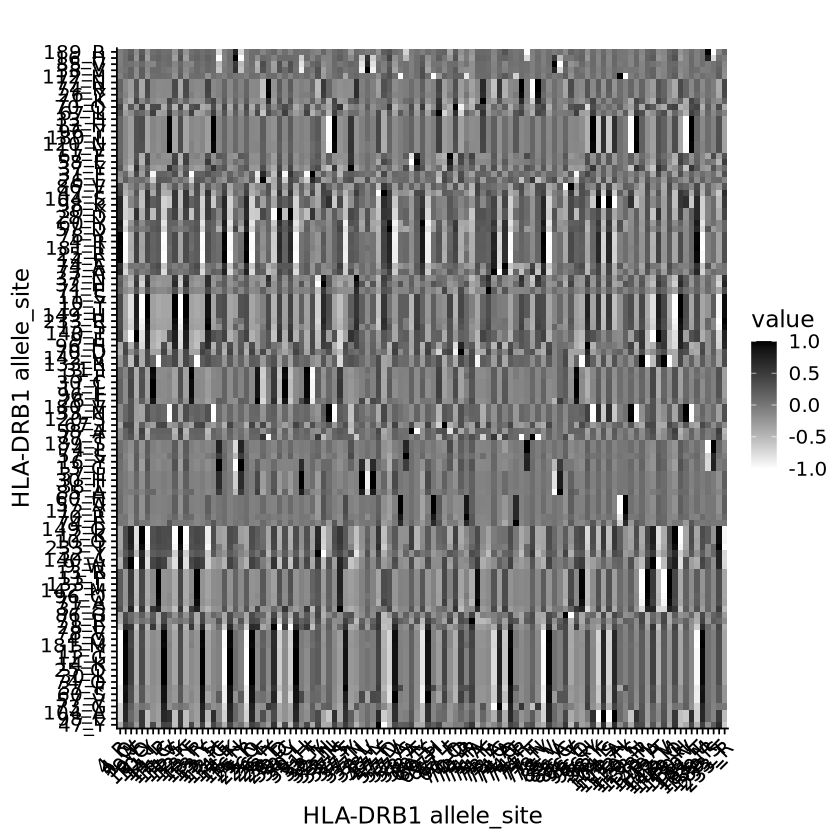

In [66]:
p

### Experiment with circular barplot

In [289]:
data <- hla_variation %>% select(gene, site, AA, n_carriers) %>% distinct() %>% arrange(desc(n_carriers))
data
 

gene site AA n_carriers
1   A     17  R  1192      
2   DPA1  11  A  1192      
3   B    143  T  1191      
4   B    147  W  1191      
5   B    158  A  1191      
6   C    113  Y  1191      
7   C    193  P  1191      
8   DPB1 205  V  1191      
9   DQB1  56  P  1191      
10  DRB1  38  V  1191      
11  DRB1 112  H  1191      
12  DRB1 189  R  1191      
13  A     56  G  1190      
14  A     73  T  1190      
15  A    109  F  1190      
16  A    245  A  1190      
17  A    297  V  1190      
18  B     30  D  1190      
19  B    145  R  1190      
20  C      6  R  1190      
21  C    248  V  1190      
22  DRB1  85  V  1190      
23  B     62  R  1188      
24  B     65  Q  1188      
25  DPB1 194  R  1188      
26  DQA1  41  R  1188      
27  DQA1 130  S  1188      
28  DRB1  16  H  1188      
29  B     66  I  1187      
30  C     35  R  1186      
⋮   ⋮    ⋮    ⋮  ⋮         
676 C    248  M  90        
677 B     97  V  87        
678 DRB1  74  L  82        
679 A    245  V  81        
680 DRB1 189  S  80        
681 DQA1  69  T  78        
682 A     73  I  77        
683 DQB1  70  E  73        
684 DQB1  71  D  73        
685 DPB1  76  I  71        
686 DRB1  57  A  70        
687 DRB1  60  H  70        
688 DRB1 112  Y  69        
689 DQB1  56  L  67        
690 DPB1  55  E  65        
691 DPB1 205  M  64        
692 DRB1  30  H  62        
693 DRB1  37  L  62        
694 DRB1  38  L  62        
695 B     97  W  56        
696 A     17  S  55        
697 A    114  E  55        
698 A    116  H  55        
699 C    193  L  55        
700 C    113  H  54        
701 C    156  Q  53        
702 A     62  L  51        
703 A     63  Q  51        
704 C    116  L  51        
705 DPA1  11  M  51

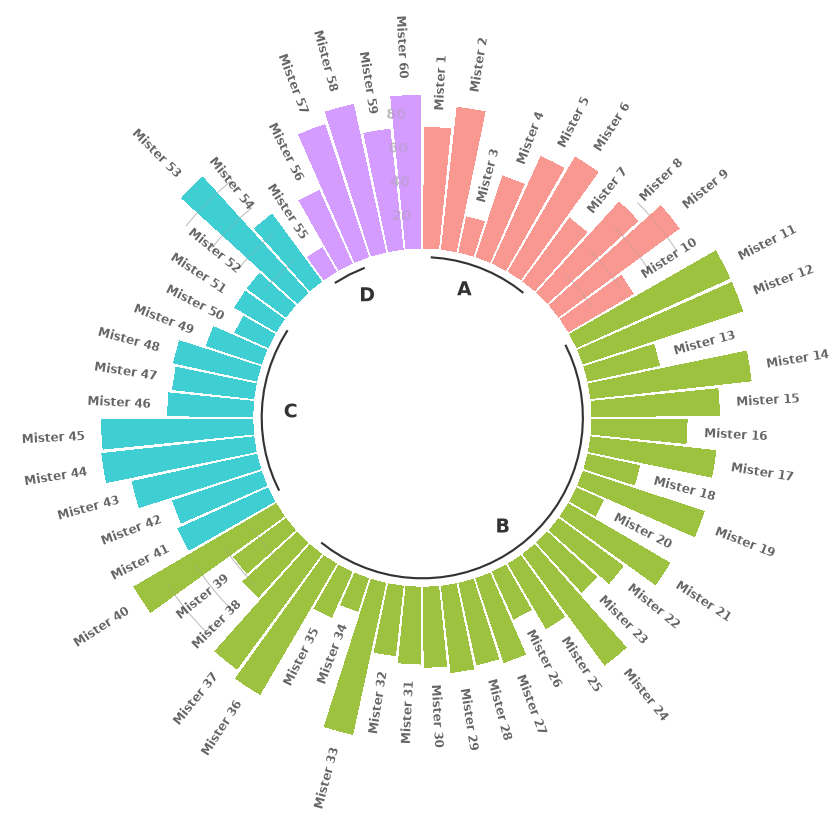

In [273]:

# Set a number of 'empty bar' to add at the end of each group
empty_bar <- 3
to_add <- data.frame( matrix(NA, empty_bar*nlevels(data$group), ncol(data)) )
colnames(to_add) <- colnames(data)
to_add$group <- rep(levels(data$group), each=empty_bar)
data <- rbind(data, to_add)
data <- data %>% arrange(group)
data$id <- seq(1, nrow(data))
 
# Get the name and the y position of each label
label_data <- data
number_of_bar <- nrow(label_data)
angle <- 90 - 360 * (label_data$id-0.5) /number_of_bar     # I substract 0.5 because the letter must have the angle of the center of the bars. Not extreme right(1) or extreme left (0)
label_data$hjust <- ifelse( angle < -90, 1, 0)
label_data$angle <- ifelse(angle < -90, angle+180, angle)
 
# prepare a data frame for base lines
base_data <- data %>% 
  group_by(group) %>% 
  summarize(start=min(id), end=max(id) - empty_bar) %>% 
  rowwise() %>% 
  mutate(title=mean(c(start, end)))
 
# prepare a data frame for grid (scales)
grid_data <- base_data
grid_data$end <- grid_data$end[ c( nrow(grid_data), 1:nrow(grid_data)-1)] + 1
grid_data$start <- grid_data$start - 1
grid_data <- grid_data[-1,]
 
# Make the plot
p <- ggplot(data, aes(x=as.factor(id), y=value, fill=group)) +       # Note that id is a factor. If x is numeric, there is some space between the first bar
  
  geom_bar(aes(x=as.factor(id), y=value, fill=group), stat="identity", alpha=0.5) +
  
  # Add a val=100/75/50/25 lines. I do it at the beginning to make sur barplots are OVER it.
  geom_segment(data=grid_data, aes(x = end, y = 80, xend = start, yend = 80), colour = "grey", alpha=1, size=0.3 , inherit.aes = FALSE ) +
  geom_segment(data=grid_data, aes(x = end, y = 60, xend = start, yend = 60), colour = "grey", alpha=1, size=0.3 , inherit.aes = FALSE ) +
  geom_segment(data=grid_data, aes(x = end, y = 40, xend = start, yend = 40), colour = "grey", alpha=1, size=0.3 , inherit.aes = FALSE ) +
  geom_segment(data=grid_data, aes(x = end, y = 20, xend = start, yend = 20), colour = "grey", alpha=1, size=0.3 , inherit.aes = FALSE ) +
  
  # Add text showing the value of each 100/75/50/25 lines
  annotate("text", x = rep(max(data$id),4), y = c(20, 40, 60, 80), label = c("20", "40", "60", "80") , color="grey", size=3 , angle=0, fontface="bold", hjust=1) +
  
  geom_bar(aes(x=as.factor(id), y=value, fill=group), stat="identity", alpha=0.5) +
  ylim(-100,120) +
  theme_minimal() +
  theme(
    legend.position = "none",
    axis.text = element_blank(),
    axis.title = element_blank(),
    panel.grid = element_blank(),
    plot.margin = unit(rep(-1,4), "cm") 
  ) +
  coord_polar() + 
  geom_text(data=label_data, aes(x=id, y=value+10, label=individual, hjust=hjust), color="black", fontface="bold",alpha=0.6, size=2.5, angle= label_data$angle, inherit.aes = FALSE ) +
  
  # Add base line information
  geom_segment(data=base_data, aes(x = start, y = -5, xend = end, yend = -5), colour = "black", alpha=0.8, size=0.6 , inherit.aes = FALSE )  +
  geom_text(data=base_data, aes(x = title, y = -18, label=group), hjust=c(1,1,0,0), colour = "black", alpha=0.8, size=4, fontface="bold", inherit.aes = FALSE)
 
p

### Visualisation of manova results of Permuted data

In [3]:
manova_permut <- paste0('../permutation_test//manova_results_permutation/', list.files('../permutation_test//manova_results_permutation/'))

In [35]:
f <- read_tsv(manova_permut[6]) %>% separate(pair, into = c('gene', 'site', 'cdr3_length', 'IMGT'), remove = FALSE)

Rows: 40612 Columns: 13
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (2): pair, model
dbl (11): Res.Df, Df, Gen.var., Pillai, approx.F, num.Df, den.Df, Pr..F., Om...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“Expected 4 pieces. Additional pieces discarded in 3432 rows [25741, 25742, 25743, 25744, 25745, 25746, 25747, 25748, 25749, 25750, 25751, 25752, 25753, 25754, 25755, 25756, 25757, 25758, 25759, 25760, ...].”


In [11]:
bonf <- 0.01/20000/12

In [8]:
f %>% arrange(Pr..F.)

Res.Df Df Gen.var.  Pillai     approx.F num.Df den.Df Pr..F.      
1     1918   1  0.6160476 0.02747373 2.680911 20     1898   7.790967e-05
2     1918   1  0.6160476 0.02747373 2.680911 20     1898   7.790967e-05
3     1918   1  0.5981722 0.02636268 2.706224 19     1899   9.451078e-05
4     1918   1  0.5981722 0.02636268 2.706224 19     1899   9.451078e-05
5     1918   1  0.7035026 0.02567381 2.500646 20     1898   2.527325e-04
6     1918   1  0.7035026 0.02567381 2.500646 20     1898   2.527325e-04
7     1918   1  0.6367099 0.02447876 2.507980 19     1899   3.263532e-04
8     1918   1  0.6367099 0.02447876 2.507980 19     1899   3.263532e-04
9     1918   1  0.7035026 0.02499589 2.432923 20     1898   3.895244e-04
10    1918   1  0.7672318 0.02410634 2.468881 19     1899   4.146894e-04
11    1918   1  0.5682245 0.02458877 2.392298 20     1898   5.035825e-04
12    1918   1  0.5682245 0.02458877 2.392298 20     1898   5.035825e-04
13    1918   1  0.6721456 0.02425445 2.358963 20     1898   6.207471e-04
14    1918   1  0.8106141 0.02327601 2.381815 19     1899   7.025492e-04
15    1918   1  0.6141337 0.02286284 2.338547 19     1899   9.099097e-04
16    1918   1  0.5981722 0.02262356 2.313505 19     1899   1.055705e-03
17    1918   2  0.6721456 0.03793115 1.834628 40     3796   1.093698e-03
18    1918   2  0.6721456 0.03793115 1.834628 40     3796   1.093698e-03
19    1918   1  0.5981722 0.02241596 2.291788 19     1899   1.200156e-03
20    1918   1  0.6311626 0.02241413 2.291597 19     1899   1.201509e-03
21    1918   4  0.6272803 0.06437475 1.552273 80     7592   1.225959e-03
22    1918   2  0.6704853 0.03615519 1.840072 38     3798   1.321203e-03
23    1918   1  0.6160476 0.02294127 2.228245 20     1898   1.389658e-03
24    1918   1  0.6160476 0.02294127 2.228245 20     1898   1.389658e-03
25    1918   1  0.6160476 0.02294127 2.228245 20     1898   1.389658e-03
26    1918   1  0.6311626 0.02204631 2.253144 19     1899   1.505511e-03
27    1918   1  0.5682245 0.02275695 2.209925 20     1898   1.552828e-03
28    1918   4  0.6967608 0.06116736 1.552114 76     7596   1.561235e-03
29    1918   1  0.5528869 0.02187897 2.235659 19     1899   1.667033e-03
30    1918   1  0.5528869 0.02187897 2.235659 19     1899   1.667033e-03
⋮     ⋮      ⋮  ⋮         ⋮          ⋮        ⋮      ⋮      ⋮           
39873 1783   NA 0.8323717 NA         NA       NA     NA     NA          
39874 1783   NA 0.8322129 NA         NA       NA     NA     NA          
39875 1783   NA 0.8325770 NA         NA       NA     NA     NA          
39876 1783   NA 0.8323841 NA         NA       NA     NA     NA          
39877 1783   NA 0.8325984 NA         NA       NA     NA     NA          
39878 1783   NA 0.8322802 NA         NA       NA     NA     NA          
39879 1783   NA 0.8325108 NA         NA       NA     NA     NA          
39880 1782   NA 0.8323647 NA         NA       NA     NA     NA          
39881 1782   NA 0.8325338 NA         NA       NA     NA     NA          
39882 1779   NA 0.8328143 NA         NA       NA     NA     NA          
39883 1782   NA 0.8325810 NA         NA       NA     NA     NA          
39884 1783   NA 0.8324391 NA         NA       NA     NA     NA          
39885 1783   NA 0.8323841 NA         NA       NA     NA     NA          
39886 1780   NA 0.8323446 NA         NA       NA     NA     NA          
39887 1783   NA 0.8326248 NA         NA       NA     NA     NA          
39888 1783   NA 0.8326002 NA         NA       NA     NA     NA          
39889 1781   NA 0.8326835 NA         NA       NA     NA     NA          
39890 1783   NA 0.8324101 NA         NA       NA     NA     NA          
39891 1782   NA 0.8326694 NA         NA       NA     NA     NA          
39892 1782   NA 0.8325246 NA         NA       NA     NA     NA          
39893 1782   NA 0.8325227 NA         NA       NA     NA     NA          
39894 1781   NA 0.8325897 NA         NA       NA     NA     NA          
39895 1783   NA 0.8324253 NA         NA       NA     NA     NA  

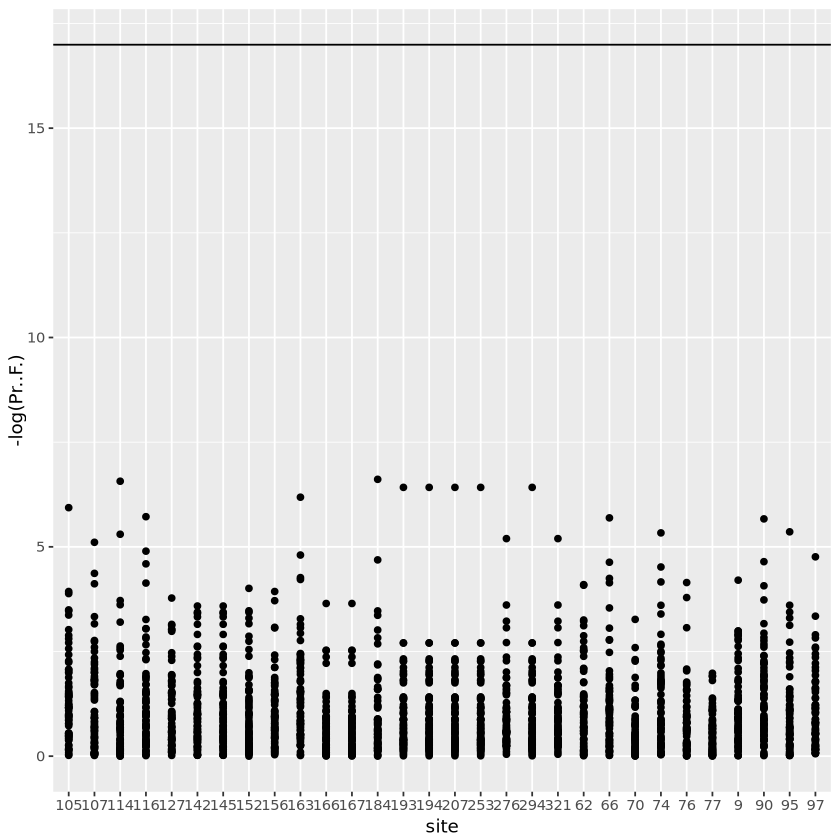

In [36]:
ggplot(na.omit(f)%>%filter(gene=='A')) +
geom_point(aes(x = site, y = -log(Pr..F.))) +
geom_hline(aes(yintercept = -log(bonf)))




In [37]:
manova_v3 <- read_tsv('../manova_results_v3.tsv')

Rows: 39760 Columns: 13
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (2): pair, model
dbl (11): Res.Df, Df, Gen.var., Pillai, approx.F, num.Df, den.Df, Pr..F., Om...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [42]:
manova_v3 %>% filter(pair == 'DRB1:13:12:P109')

Res.Df Df Gen.var.  Pillai    approx.F num.Df den.Df Pr..F. pair           
1 1891   NA 0.6455484        NA       NA NA       NA   NA     DRB1:13:12:P109
2 1896    5 0.6852495 0.9877962 24.32176 95     9385    0     DRB1:13:12:P109
  Omnibus    model P_val variance_explained
1 0.07002146 null  0     0.07410217        
2 0.14412363 full  0     0.07410217

### HLA frequencies in Healthy vs IBD

In [144]:
hla_genes <- c('A', 'C', 'B','DRB1','DQA1','DQB1','DPA1', 'DPB1')

In [2]:
hla_site_variation <- fread('../data/hla_site_variations_healthy_and_ibd_all_variable_sites_v3.tsv')

In [9]:
hla_site_variation <- hla_site_variation %>% mutate(database = ifelse(str_detect(patient_id, 'H'), 'Healthy', 'IBD'))

In [76]:
hla_site_variation

site AA n_allele_carriers patient_id gene homo_hetero variat n_variat
1      4    Q  534               H1         DRB1 1           R Q    2       
2      4    Q  534               H103       DRB1 1           R Q    2       
3      4    Q  534               H106       DRB1 1           R Q    2       
4      4    Q  534               H107       DRB1 1           R Q    2       
5      4    Q  534               H11        DRB1 1           R Q    2       
6      4    Q  534               H110       DRB1 2           R Q    2       
7      4    Q  534               H115       DRB1 1           R Q    2       
8      4    Q  534               H116       DRB1 2           R Q    2       
9      4    Q  534               H120       DRB1 1           R Q    2       
10     4    Q  534               H123       DRB1 1           R Q    2       
11     4    Q  534               H126       DRB1 1           R Q    2       
12     4    Q  534               H127       DRB1 1           R Q    2       
13     4    Q  534               H134       DRB1 1           R Q    2       
14     4    Q  534               H149       DRB1 1           R Q    2       
15     4    Q  534               H152       DRB1 2           R Q    2       
16     4    Q  534               H153       DRB1 1           R Q    2       
17     4    Q  534               H155       DRB1 1           R Q    2       
18     4    Q  534               H157       DRB1 1           R Q    2       
19     4    Q  534               H16        DRB1 2           R Q    2       
20     4    Q  534               H161       DRB1 1           R Q    2       
21     4    Q  534               H166       DRB1 1           R Q    2       
22     4    Q  534               H17        DRB1 1           R Q    2       
23     4    Q  534               H170       DRB1 1           R Q    2       
24     4    Q  534               H171       DRB1 1           R Q    2       
25     4    Q  534               H173       DRB1 1           R Q    2       
26     4    Q  534               H175       DRB1 1           R Q    2       
27     4    Q  534               H176       DRB1 1           R Q    2       
28     4    Q  534               H178       DRB1 2           R Q    2       
29     4    Q  534               H180       DRB1 1           R Q    2       
30     4    Q  534               H189       DRB1 1           R Q    2       
⋮      ⋮    ⋮  ⋮                 ⋮          ⋮    ⋮           ⋮      ⋮       
740062 228  T  3333              I97        DPA1 1           T P    2       
740063 228  T  3333              I970       DPA1 2           T P    2       
740064 228  T  3333              I972       DPA1 2           T P    2       
740065 228  T  3333              I973       DPA1 2           T P    2       
740066 228  T  3333              I974       DPA1 2           T P    2       
740067 228  T  3333              I975       DPA1 1           T P    2       
740068 228  T  3333              I976       DPA1 2           T P    2       
740069 228  T  3333              I977       DPA1 1           T P    2       
740070 228  T  3333              I978       DPA1 2           T P    2       
740071 228  T  3333              I979       DPA1 2           T P    2       
740072 228  T  3333              I98        DPA1 1           T P    2       
740073 228  T  3333              I980       DPA1 1           T P    2       
740074 228  T  3333              I982       DPA1 2           T P    2       
740075 228  T  3333              I983       DPA1 1           T P    2       
740076 228  T  3333              I984       DPA1 2           T P    2       
740077 228  T  3333              I985       DPA1 2           T P    2       
740078 228  T  3333              I986       DPA1 2           T P    2       
740079 228  T  3333              I987       DPA1 2           T P    2       
740080 228  T  3333              I988       DPA1 2           T P    2       
740081 228  T  3333              I989       DPA1 2           T P    2       
740

In [80]:
hla_features <- fread('../data/hla_features_wo_duplicates_healthy_and_ibd_those_with_cdr3.tsv')

In [81]:
hla_features <- hla_features %>% mutate(Dataset = ifelse(str_detect(patient_id, 'H'), 'Healthy', 'IBD'))

In [82]:
hla_summary <- hla_features %>% group_by(Dataset, gene, allele) %>% 
    summarise(n = sum(homo_hetero), .groups = 'keep') %>% 
    filter(gene %in% hla_genes) %>% ungroup() %>%
    group_by(Dataset, gene) %>% mutate(total_n = sum(n), freq = n/total_n) %>%
    arrange(freq) 

In [85]:
for (hla_gene in hla_genes){
    freq_levels <- hla_summary %>% filter(gene==hla_gene) %>% pull(allele) %>% unique()
    freq_hla_plot <- ggplot(hla_summary%>%filter(gene==hla_gene), aes(x = factor(allele, levels = freq_levels), y = freq)) +
        geom_bar(aes(fill = Dataset),stat = "identity",position = "dodge") +
        scale_fill_viridis_d()+
        #facet_wrap(~factor(gene, levels = hla_genes), ncol = 8)+
        labs(x = " ", y = 'Allele frequency') +
        theme_cowplot() +
        theme(strip.background = element_rect(fill = "white"), axis.text.y = element_text(size = 8),
             axis.text.x = element_text(size = 9), text = element_text(size = 9), legend.position = "bottom") + 
        coord_flip()
    ggsave(paste0('../plots/',hla_gene,'_freq_stacked.jpg'),freq_hla_plot, width = 5, height = 8)
           }

In [ ]:
for (hla_gene in hla_genes){
    freq_levels <- hla_summary %>% filter(gene==hla_gene) %>% pull(allele) %>% unique()
    freq_hla_plot <- ggplot(hla_summary%>%filter(gene==hla_gene), aes(x = factor(allele, levels = freq_levels), y = freq)) +
        geom_bar(aes(fill = database),stat = "identity",position = "dodge") +
        scale_fill_viridis_d()+
        #facet_wrap(~factor(gene, levels = hla_genes), ncol = 8)+
        labs(x = " ", y = 'Allele frequency') +
        theme(legend.text.position = "bottom", legend.text = 'Dataset') +
        theme_cowplot() +
        theme(strip.background = element_rect(fill = "white")) + 
        coord_flip()
    ggsave(paste0('../plots/',hla_gene,'_freq_stacked.jpg'),freq_hla_plot, width = 5, height = 6)
           }

### Manhattan plots with site variations for OUR data vs Ishigaki data

In [2]:
source('libraries.R')


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘tidyr’


The following object is masked from ‘package:magrittr’:

    extract


Registered S3 methods overwritten by 'ggtern':
  method           from   
  grid.draw.ggplot ggplot2
  plot.ggplot      ggplot2
  print.ggplot     ggplot2

--
Remember to cite, run citation(package = 'ggtern') for further info.
--


Attaching package: ‘ggtern’


The following objects are masked from ‘package:ggplot2’:

    aes, annotate, ggplot, ggplot_build, ggplot_gtable, ggplotGrob,
    ggsave, layer_data, theme_bw, theme_classic, theme_dark,
    theme_gray, theme_light, theme_linedraw, theme_minimal, theme_void


Loading required package: viridisLite


Attaching package: ‘purrr’


The following obje

In [277]:
hla_site_variation <- fread('../data/hla_site_variations_healthy_and_ibd_all_variable_sites_v3.tsv')

In [284]:
hla_site_variation 

site AA n_allele_carriers patient_id gene homo_hetero variat n_variat
1      4    Q  534               H1         DRB1 1           R Q    2       
2      4    Q  534               H103       DRB1 1           R Q    2       
3      4    Q  534               H106       DRB1 1           R Q    2       
4      4    Q  534               H107       DRB1 1           R Q    2       
5      4    Q  534               H11        DRB1 1           R Q    2       
6      4    Q  534               H110       DRB1 2           R Q    2       
7      4    Q  534               H115       DRB1 1           R Q    2       
8      4    Q  534               H116       DRB1 2           R Q    2       
9      4    Q  534               H120       DRB1 1           R Q    2       
10     4    Q  534               H123       DRB1 1           R Q    2       
11     4    Q  534               H126       DRB1 1           R Q    2       
12     4    Q  534               H127       DRB1 1           R Q    2       
13     4    Q  534               H134       DRB1 1           R Q    2       
14     4    Q  534               H149       DRB1 1           R Q    2       
15     4    Q  534               H152       DRB1 2           R Q    2       
16     4    Q  534               H153       DRB1 1           R Q    2       
17     4    Q  534               H155       DRB1 1           R Q    2       
18     4    Q  534               H157       DRB1 1           R Q    2       
19     4    Q  534               H16        DRB1 2           R Q    2       
20     4    Q  534               H161       DRB1 1           R Q    2       
21     4    Q  534               H166       DRB1 1           R Q    2       
22     4    Q  534               H17        DRB1 1           R Q    2       
23     4    Q  534               H170       DRB1 1           R Q    2       
24     4    Q  534               H171       DRB1 1           R Q    2       
25     4    Q  534               H173       DRB1 1           R Q    2       
26     4    Q  534               H175       DRB1 1           R Q    2       
27     4    Q  534               H176       DRB1 1           R Q    2       
28     4    Q  534               H178       DRB1 2           R Q    2       
29     4    Q  534               H180       DRB1 1           R Q    2       
30     4    Q  534               H189       DRB1 1           R Q    2       
⋮      ⋮    ⋮  ⋮                 ⋮          ⋮    ⋮           ⋮      ⋮       
740062 228  T  3333              I97        DPA1 1           T P    2       
740063 228  T  3333              I970       DPA1 2           T P    2       
740064 228  T  3333              I972       DPA1 2           T P    2       
740065 228  T  3333              I973       DPA1 2           T P    2       
740066 228  T  3333              I974       DPA1 2           T P    2       
740067 228  T  3333              I975       DPA1 1           T P    2       
740068 228  T  3333              I976       DPA1 2           T P    2       
740069 228  T  3333              I977       DPA1 1           T P    2       
740070 228  T  3333              I978       DPA1 2           T P    2       
740071 228  T  3333              I979       DPA1 2           T P    2       
740072 228  T  3333              I98        DPA1 1           T P    2       
740073 228  T  3333              I980       DPA1 1           T P    2       
740074 228  T  3333              I982       DPA1 2           T P    2       
740075 228  T  3333              I983       DPA1 1           T P    2       
740076 228  T  3333              I984       DPA1 2           T P    2       
740077 228  T  3333              I985       DPA1 2           T P    2       
740078 228  T  3333              I986       DPA1 2           T P    2       
740079 228  T  3333              I987       DPA1 2           T P    2       
740080 228  T  3333              I988       DPA1 2           T P    2       
740081 228  T  3333              I989       DPA1 2           T P    2       
740

In [289]:
alleles_n_variat_summary <-  hla_site_variation %>% dplyr::select(gene, site, n_variat) %>% distinct() %>% rename(Site_hla = site, HLA = gene)

In [291]:
our_manova <- na.omit(fread('../manova_results_v3.tsv')) %>% 
    separate(pair, into = c('HLA', 'Site_hla', 'Length_cdr3', 'Position_cdr3'), sep = ':', remove = FALSE) %>%
    mutate(Site_hla = as.integer(Site_hla)) %>% rename(Pvalue = Pr..F.) %>% dplyr::select(HLA, Site_hla, Pvalue, variance_explained)
bonf <- 0.01/nrow(our_manova)
our_manova

HLA  Site_hla Pvalue       variance_explained
1     A    105      3.264286e-01 0.0141778256      
2     A    105      1.053894e-06 0.0017274741      
3     A    105      2.904760e-06 0.0021277622      
4     A    105      2.144216e-04 0.0014171962      
5     A    105      3.054754e-09 0.0021277281      
6     A    105      1.542875e-02 0.0008558705      
7     A    105      1.225717e-01 0.0008077491      
8     A    105      3.886640e-01 0.0006032459      
9     A    105      2.707951e-01 0.0012799358      
10    A    105      4.908366e-01 0.0004014079      
11    A    105      1.075508e-03 0.0011815019      
12    A    105      3.839228e-11 0.0026967861      
13    A    105      1.694844e-08 0.0027130943      
14    A    105      4.510749e-10 0.0025386177      
15    A    105      3.748627e-06 0.0019532714      
16    A    105      2.876627e-01 0.0005952861      
17    A    105      1.607405e-02 0.0009902090      
18    A    105      1.078636e-01 0.0008539401      
19    A    105      1.322157e-01 0.0006521144      
20    A    105      1.625809e-02 0.0009211531      
21    A    105      1.510799e-09 0.0025606692      
22    A    105      1.114010e-12 0.0044515413      
23    A    105      2.328173e-09 0.0024252516      
24    A    105      1.395644e-18 0.0025752079      
25    A    105      3.748472e-06 0.0019525702      
26    A    105      4.957007e-04 0.0014331287      
27    A    105      1.819831e-01 0.0006557230      
28    A    105      9.785797e-02 0.0010507920      
29    A    105      6.854685e-01 0.0004317804      
30    A    105      5.305271e-01 0.0004950541      
⋮     ⋮    ⋮        ⋮            ⋮                 
19922 DRB1 98       1.070648e-53 0.0076198463      
19923 DRB1 98       3.630938e-59 0.0068533648      
19924 DRB1 98       2.426109e-36 0.0060605852      
19925 DRB1 98       1.407167e-65 0.0093382104      
19926 DRB1 98       7.048634e-45 0.0080692479      
19927 DRB1 98       1.179224e-24 0.0049998912      
19928 DRB1 98       1.753336e-18 0.0048499424      
19929 DRB1 98       9.608281e-02 0.0010049965      
19930 DRB1 98       3.697630e-01 0.0008475553      
19931 DRB1 98       5.114965e-23 0.0063047501      
19932 DRB1 98       7.154924e-25 0.0042006580      
19933 DRB1 98       1.660402e-18 0.0043216629      
19934 DRB1 98       1.233441e-50 0.0067335037      
19935 DRB1 98       6.346197e-34 0.0071311462      
19936 DRB1 98       2.999143e-33 0.0041476842      
19937 DRB1 98       4.366483e-28 0.0056685843      
19938 DRB1 98       1.148599e-40 0.0065391154      
19939 DRB1 98       6.458201e-13 0.0031583929      
19940 DRB1 98       2.217775e-11 0.0036790400      
19941 DRB1 98       1.289619e-10 0.0037605975      
19942 DRB1 98       4.731776e-18 0.0043403394      
19943 DRB1 98       5.047336e-13 0.0034484726      
19944 DRB1 98       6.245992e-20 0.0031909197      
19945 DRB1 98       1.448005e-22 0.0038528709      
19946 DRB1 98       3.656371e-27 0.0049652846      
19947 DRB1 98       1.123919e-10 0.0026117417      
19948 DRB1 98       6.725530e-21 0.0035579565      
19949 DRB1 98       2.241147e-22 0.0034375732      
19950 DRB1 98       1.397392e-06 0.0017902809      
19951 DRB1 98       6.736584e-02 0.0011930580

In [304]:
hla_genes <- c('A', 'C', 'B','DRB1','DQA1','DQB1','DPA1', 'DPB1')
for (gene in hla_genes){
    assign(gene, unlist(map(grep('.tsv', grep(paste0(gene, '_'), list.files('../conditional_analysis//IBD/IBD_downsampled//all_sites_in_downsampled/'), value = TRUE), value = TRUE, invert = TRUE), function(x) unlist(strsplit(x, '_'))[[2]])))
}
independent_sites <- list()
for (i in seq(1, length(hla_genes))){
    independent_sites[[hla_genes[i]]] <- get(hla_genes[i])
}

In [305]:
independent_sites

$B
[1] "156" "199"

$DRB1
[1] "13" "26" "37" "67" "71"

$DQB1
[1] "70" "71" "87"

$DPB1
[1] "11" "65" "69"

In [318]:
smallest_number <- .Machine$double.xmin

In [319]:
smallest_number

[1] 2.225074e-308

In [324]:
our_manova_with_variat <- our_manova %>% left_join(alleles_n_variat_summary, by = c('HLA', 'Site_hla')) %>%
    replace_na(list(n_variat = 1)) %>% mutate(adj_Pvalue = ifelse(Pvalue == 0, smallest_number, Pvalue))
our_manova_variat_condition <- our_manova_with_variat %>% group_by(HLA, Site_hla) %>%  mutate(min_Pvalue = min(Pvalue)) %>% 
    rowwise() %>%
    mutate(independent_signal = ifelse(Pvalue == min_Pvalue & Site_hla %in% independent_sites[[HLA]], Site_hla, NA)) %>% ungroup() 

Warning message:
“Removed 19900 rows containing missing values or values outside the scale range (`geom_label()`).”


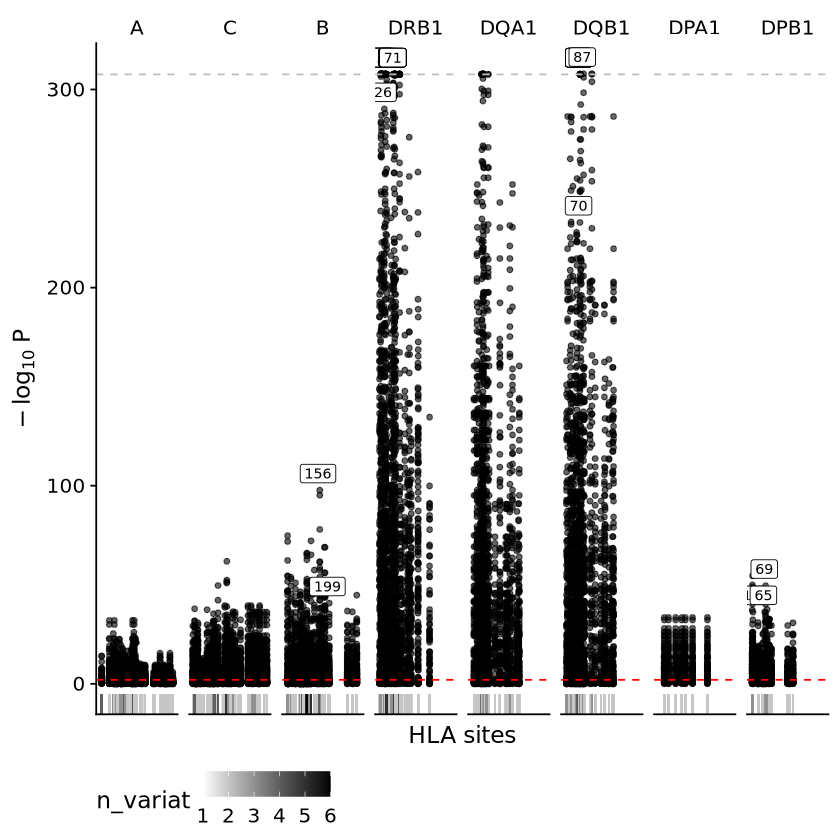

In [325]:
pl_our <- ggplot(data = our_manova_variat_condition, aes(x = Site_hla, y = -log10(adj_Pvalue))) +
    geom_point(alpha=0.6, size=1.3) +
    geom_rug(aes(color = n_variat), sides = "b", show.legend = TRUE) +  # Use n_variat for the color aesthetic
    scale_color_gradient(low = "white", high = "black") +  # Gradient for n_variat
    geom_label(aes(x = independent_signal, y = -log10(adj_Pvalue), label = independent_signal), 
           hjust=0.55,vjust=-0.4,size=3, show.legend = FALSE) + 
    labs(x = "HLA sites", y = expression(paste(-log[10], " ", P))) +
    geom_hline(yintercept = -log10(0.01), linetype = "dashed", color = "red") +
    geom_hline(yintercept = -log10(smallest_number), linetype = "dashed", color = "grey") +
    theme_cowplot() +
    facet_grid(~factor(HLA, levels = hla_genes), space = "free") +
    theme(
    axis.text.x = element_blank(),
    strip.background = element_rect(fill = "white"),
    axis.ticks.x = element_blank(),
    legend.position = "bottom"
    )
pl_our

In [326]:
ggsave('../plots/our_manova_with_variat_per_site.jpg')

Saving 6.67 x 6.67 in image

Warning message:
“Removed 19900 rows containing missing values or values outside the scale range (`geom_label()`).”


Warning message:
“Removed 2738 rows containing missing values or values outside the scale range (`geom_label()`).”


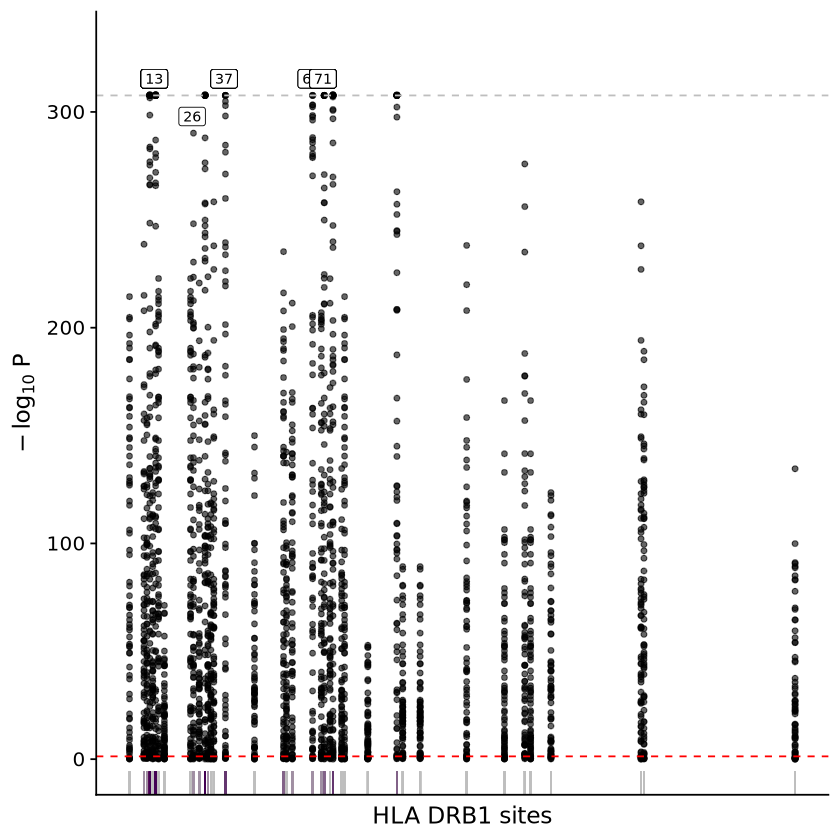

In [365]:
drb1_our <- ggplot(data = our_manova_variat_condition %>% filter(HLA == 'DRB1'), aes(x = Site_hla, y = -log10(adj_Pvalue))) +
    geom_point(alpha=0.6, size=1.3) +
    geom_rug(aes(color = n_variat), sides = "b", show.legend = TRUE) +  # Use n_variat for the color aesthetic
    scale_color_gradient(low = "grey", high = "#440154") +  # Gradient for n_variat
    geom_label(aes(x = independent_signal, y = -log10(adj_Pvalue), label = independent_signal), 
           hjust=0.55,vjust=-0.4,size=3, show.legend = FALSE) + 
    labs(x = "HLA DRB1 sites", y = expression(paste(-log[10], " ", P))) +
    geom_hline(yintercept = -log10(0.05), linetype = "dashed", color = "red") +
    geom_hline(yintercept = -log10(smallest_number), linetype = "dashed", color = "grey") +
    theme_cowplot() +
    theme(
    axis.text.x = element_blank(),
    strip.background = element_rect(fill = "white"),
    axis.ticks.x = element_blank(),
    legend.position = "none"
    ) + 
    ylim(0,330)
drb1_our


Warning message:
“Removed 2485 rows containing missing values or values outside the scale range (`geom_label()`).”
Saving 6.67 x 6.67 in image

Warning message:
“Removed 2485 rows containing missing values or values outside the scale range (`geom_label()`).”


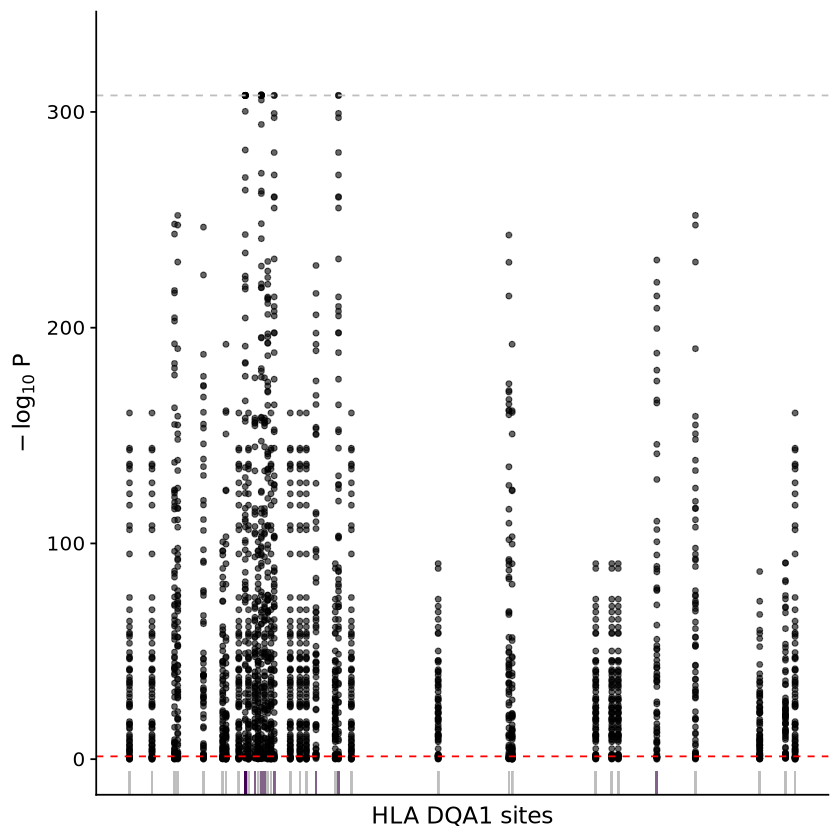

In [368]:
dqa1_our <- ggplot(data = our_manova_variat_condition %>% filter(HLA == 'DQA1'), aes(x = Site_hla, y = -log10(adj_Pvalue))) +
    geom_point(alpha=0.6, size=1.3) +
    geom_rug(aes(color = n_variat), sides = "b", show.legend = TRUE) +  # Use n_variat for the color aesthetic
    scale_color_gradient(low = "grey", high = "#440154") +  # Gradient for n_variat
    geom_label(aes(x = independent_signal, y = -log10(adj_Pvalue), label = independent_signal), 
           hjust=0.55,vjust=-0.4,size=3, show.legend = FALSE) + 
    labs(x = "HLA DQA1 sites", y = expression(paste(-log[10], " ", P))) +
    geom_hline(yintercept = -log10(0.05), linetype = "dashed", color = "red") +
    geom_hline(yintercept = -log10(smallest_number), linetype = "dashed", color = "grey") +
    theme_cowplot() +
    theme(
    axis.text.x = element_blank(),
    strip.background = element_rect(fill = "white"),
    axis.ticks.x = element_blank(),
    legend.position = "none"
    ) + 
    ylim(0,330)
dqa1_our
ggsave('../plots/our_dqa1_with_variat_per_site.jpg', dqa1_our)

Warning message:
“Removed 2683 rows containing missing values or values outside the scale range (`geom_label()`).”
Saving 6.67 x 6.67 in image

Warning message:
“Removed 2683 rows containing missing values or values outside the scale range (`geom_label()`).”


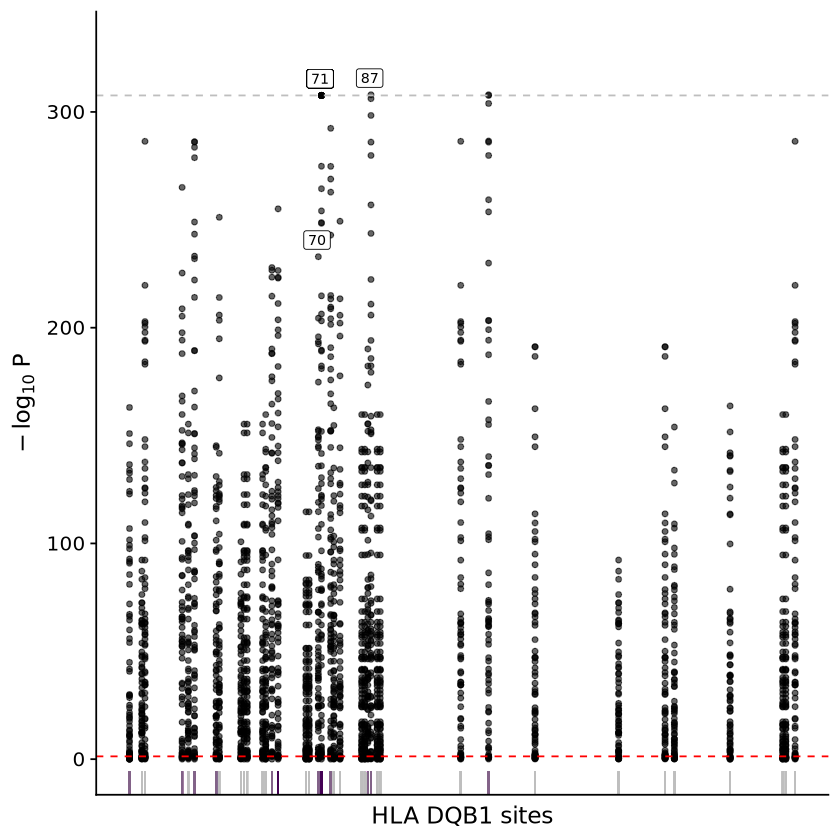

In [369]:
dqb1_our <- ggplot(data = our_manova_variat_condition %>% filter(HLA == 'DQB1'), aes(x = Site_hla, y = -log10(adj_Pvalue))) +
    geom_point(alpha=0.6, size=1.3) +
    geom_rug(aes(color = n_variat), sides = "b", show.legend = TRUE) +  # Use n_variat for the color aesthetic
    scale_color_gradient(low = "grey", high = "#440154") +  # Gradient for n_variat
    geom_label(aes(x = independent_signal, y = -log10(adj_Pvalue), label = independent_signal), 
           hjust=0.55,vjust=-0.4,size=3, show.legend = FALSE) + 
    labs(x = "HLA DQB1 sites", y = expression(paste(-log[10], " ", P))) +
    geom_hline(yintercept = -log10(0.05), linetype = "dashed", color = "red") +
    geom_hline(yintercept = -log10(smallest_number), linetype = "dashed", color = "grey") +
    theme_cowplot() +
    theme(
    axis.text.x = element_blank(),
    strip.background = element_rect(fill = "white"),
    axis.ticks.x = element_blank(),
    legend.position = "none"
    ) + 
    ylim(0,330)
dqb1_our
ggsave('../plots/our_dqb1_with_variat_per_site.jpg', dqb1_our)

Warning message:
“Removed 3214 rows containing missing values or values outside the scale range (`geom_label()`).”


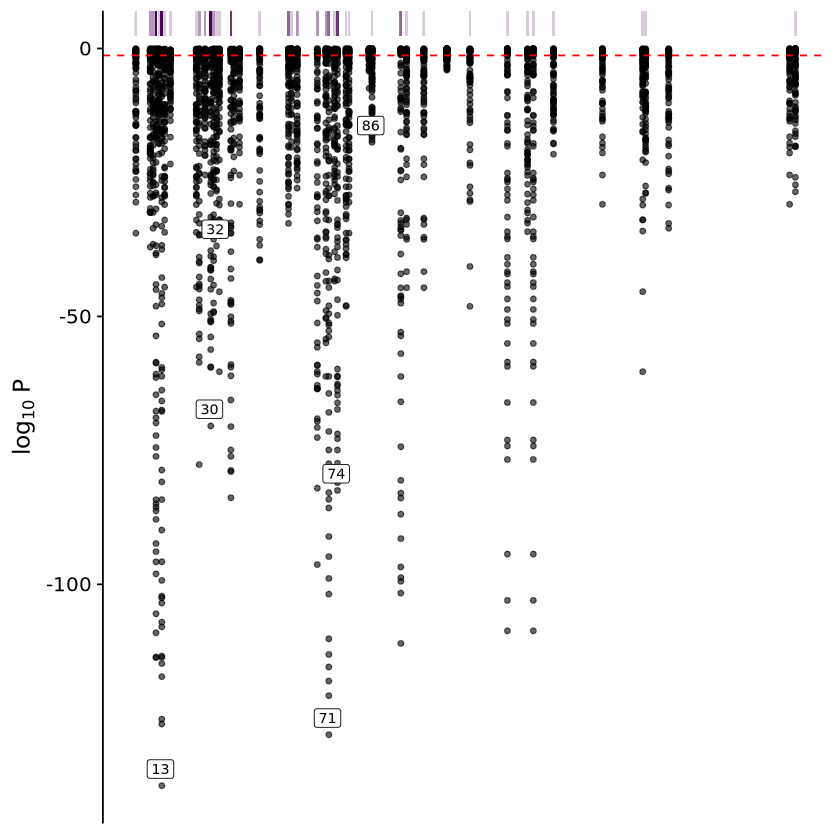

In [383]:
drb1_ishigaki <- ggplot(data = ishigaki_manova_variat_condition %>% filter(HLA == 'DRB1', Site_hla > 0), aes(x = Site_hla, y = log10(Pvalue))) +
    geom_point(alpha=0.6, size=1.3) +
    geom_rug(aes(color = n_variat), sides = "t", show.legend = TRUE) +  # Use n_variat for the color aesthetic
    scale_color_gradient(low = "white", high = "#440154") +  # Gradient for n_variat
    geom_label(aes(x = independent_signal, y = log10(Pvalue), label = independent_signal), 
           hjust=0.55,vjust=-0.4,size=3, show.legend = FALSE) + 
    labs(x = "HLA DRB1 sites", y = expression(paste(log[10], " ", P))) +
    geom_hline(yintercept = log10(0.05), linetype = "dashed", color = "red") +
    theme_cowplot() +
    theme(
        axis.title.x.top = element_text(),  # Add title to the top x-axis
        axis.text.x.top = element_text(),   # Add labels to the top x-axis
        axis.title.x = element_blank(),     # Remove title from the bottom x-axis
        axis.text.x = element_blank(),      # Remove labels from the bottom x-axis
        strip.background = element_rect(fill = "white"),
        axis.ticks.x = element_blank(),
        axis.line.x.bottom = element_blank(),
        legend.position = "none"
    )
drb1_ishigaki

Warning message:
“Removed 2450 rows containing missing values or values outside the scale range (`geom_label()`).”


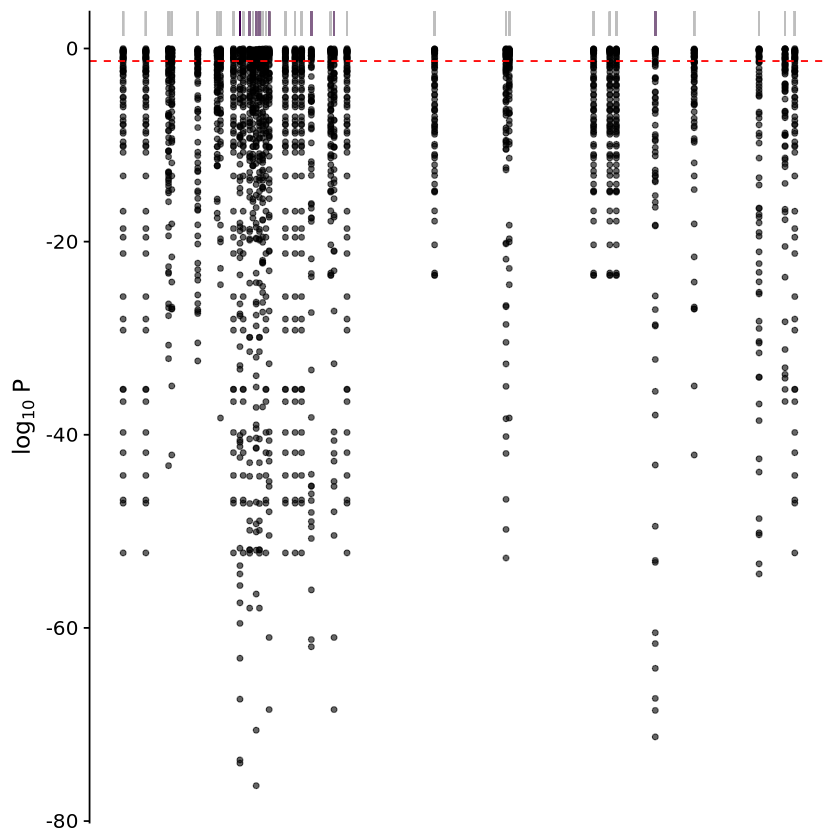

In [384]:
dqa1_ishigaki <- ggplot(data = ishigaki_manova_variat_condition %>% filter(HLA == 'DQA1', Site_hla > 0), aes(x = Site_hla, y = log10(Pvalue))) +
    geom_point(alpha=0.6, size=1.3) +
    geom_rug(aes(color = n_variat), sides = "t", show.legend = TRUE) +  # Use n_variat for the color aesthetic
    scale_color_gradient('low' = "grey", 'high' = "#440154") +  # Gradient for n_variat
    geom_label(aes(x = independent_signal, y = log10(Pvalue), label = independent_signal), 
           hjust=0.55,vjust=-0.4,size=3, show.legend = FALSE) + 
    labs(x = "HLA DQA1 sites", y = expression(paste(log[10], " ", P))) +
    geom_hline(yintercept = log10(0.05), linetype = "dashed", color = "red") +
    theme_cowplot() +
    theme(
        axis.title.x.top = element_text(),  # Add title to the top x-axis
        axis.text.x.top = element_text(),   # Add labels to the top x-axis
        axis.title.x = element_blank(),     # Remove title from the bottom x-axis
        axis.text.x = element_blank(),      # Remove labels from the bottom x-axis
        strip.background = element_rect(fill = "white"),
        axis.ticks.x = element_blank(),
        axis.line.x.bottom = element_blank(),
        legend.position = "none"
    )
dqa1_ishigaki

Warning message:
“Removed 2940 rows containing missing values or values outside the scale range (`geom_label()`).”


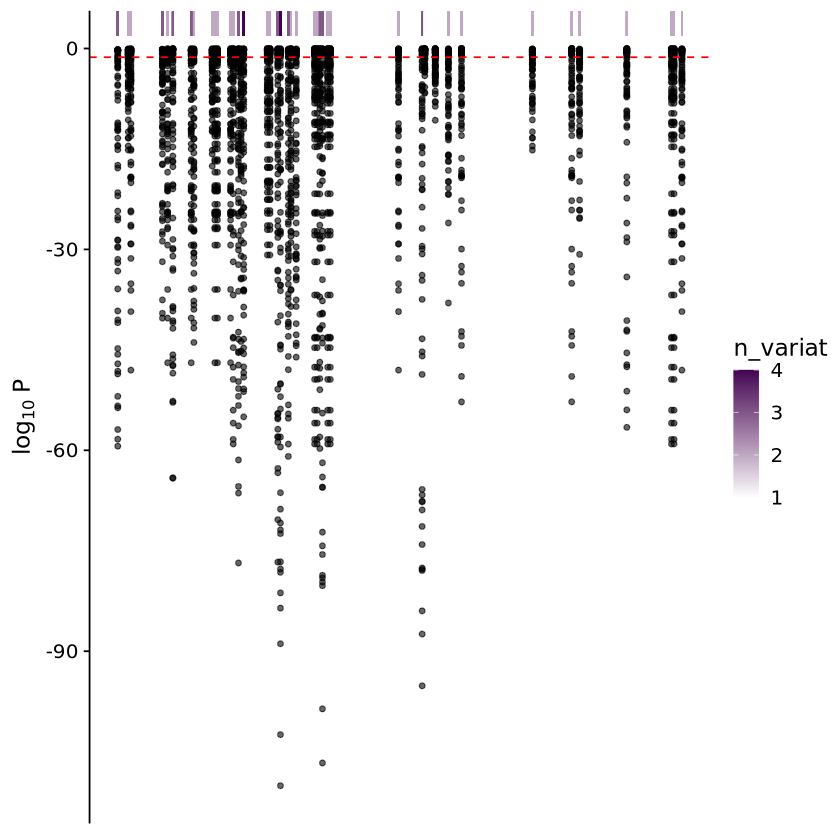

In [ ]:
dqb1_ishigaki <- ggplot(data = ishigaki_manova_variat_condition %>% filter(HLA == 'DQB1', Site_hla > 0), aes(x = Site_hla, y = log10(Pvalue))) +
    geom_point(alpha=0.6, size=1.3) +
    geom_rug(aes(color = n_variat), sides = "t", show.legend = TRUE) +  # Use n_variat for the color aesthetic
    scale_color_gradient('low' = "white", 'high' = "#440154") +  # Gradient for n_variat
    geom_label(aes(x = independent_signal, y = log10(Pvalue), label = independent_signal), 
           hjust=0.55,vjust=-0.4,size=3, show.legend = FALSE) + 
    labs(x = "HLA DQB1 sites", y = expression(paste(log[10], " ", P))) +
    geom_hline(yintercept = log10(0.05), linetype = "dashed", color = "red") +
    theme_cowplot() +
    theme(
        axis.title.x.top = element_text(),
        axis.text.x.top = element_text(),
        axis.title.x = element_blank(),
        axis.text.x = element_blank(),
        strip.background = element_rect(fill = "white"),
        axis.ticks.x = element_blank(),
        axis.line.x.bottom = element_blank(),
        legend.position = "right"
    )
dqb1_ishigaki

In [386]:
both <- (drb1_our / drb1_ishigaki) | (dqa1_our / dqa1_ishigaki) | (dqb1_our / dqb1_ishigaki)

Warning message:
“Removed 2738 rows containing missing values or values outside the scale range (`geom_label()`).”
Warning message:
“Removed 3214 rows containing missing values or values outside the scale range (`geom_label()`).”
Warning message:
“Removed 2485 rows containing missing values or values outside the scale range (`geom_label()`).”
Warning message:
“Removed 2450 rows containing missing values or values outside the scale range (`geom_label()`).”
Warning message:
“Removed 2683 rows containing missing values or values outside the scale range (`geom_label()`).”
Warning message:
“Removed 2940 rows containing missing values or values outside the scale range (`geom_label()`).”


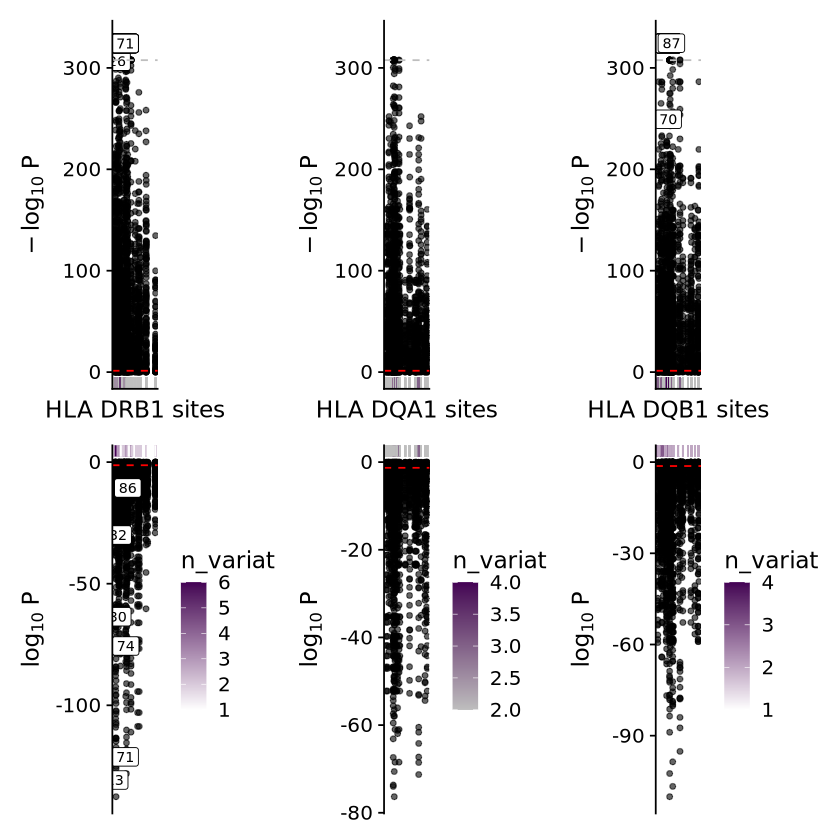

In [382]:
both

In [390]:
ggsave('../plots/both_hla_ii_labbeled.jpg', both, width = 10, height = 6)

Warning message:
“Removed 2738 rows containing missing values or values outside the scale range (`geom_label()`).”
Warning message:
“Removed 3214 rows containing missing values or values outside the scale range (`geom_label()`).”
Warning message:
“Removed 2485 rows containing missing values or values outside the scale range (`geom_label()`).”
Warning message:
“Removed 2450 rows containing missing values or values outside the scale range (`geom_label()`).”
Warning message:
“Removed 2683 rows containing missing values or values outside the scale range (`geom_label()`).”
Warning message:
“Removed 2940 rows containing missing values or values outside the scale range (`geom_label()`).”
